# Applying Infomap [1, 2, 3] community detection technique on the network

 - Using ['infomap' python module](https://mapequation.github.io/infomap/python/)

 [1] Rosvall, M., Axelsson, D., and Bergstrom, C.T., 2009. The map equation. The European Physical
Journal Special Topics, 178 (1), 13–23.  
 [2] Rosvall, M. and Bergstrom, C.T., 2008. Maps of random walks on complex networks reveal community structure. Proceedings of the National Academy of Sciences of the United States of America,
105 (4), 1118–1123.  
 [3] Rosvall, M. and Bergstrom, C.T., 2011. Multilevel compression of random walks on networks reveals
hierarchical organization in large integrated systems. PLos One, 6 (4), e18209.

In [3]:
import sys

# choosing the Brazilian state (e.g. 'AM-13-9', 'PA-15-12', 'BA-29-28', 'SP-35-63', 'RJ-33-9', 'RS-43-19')

print("Sigla do estado: ")
UF = 'RJ' #str(input())

estado_dict = {'RJ': ['33', 'Rio de Janeiro', '(-43.5,-22.9)', '(-43.7,-23.3)', '9', 'Rio de Janeiro'], 
               'RS': ['43', 'Porto Alegre', '(-51.15,-30.1)', '(-51,-32)', '19', 'Rio Grande do Sul'],
               'SP': ['35', 'São Paulo', '(-46.7,-23.5)', '(-46.1, -24.5)', '63', 'São Paulo'],
               'CE': ['23', 'Fortaleza', '(-38.57, -3.74)', '(-37.53, -3.9)', '22', 'Ceará'],
               'BA': ['29', 'Salvador', '(-38.4,-13)', '(-38.5,-14)', '28', 'Bahia']}
uf_code = int(estado_dict[UF][0])
capital = estado_dict[UF][1]
xy = eval(estado_dict[UF][2])
xytext = eval(estado_dict[UF][3])
regions_num = eval(estado_dict[UF][4])
uf_name = estado_dict[UF][5]


Sigla do estado: 


In [160]:
#regions_num = 3 #MACRO

In [161]:
import infomap
import pandas as pd
import geopandas as gpd
import numpy as np
import networkx as nx
from sklearn.metrics.cluster import v_measure_score


# import the municipalities shapes
#mun_df = gpd.read_file("../data/%s/%s_mun.shp"%(UF, UF))
mun_df = gpd.read_file("../data/%s/%s_Municipios_%d.dbf"%(UF, UF, 2021))
mun_df['code'] = np.array([item[:-1] for item in np.array(mun_df.CD_MUN)]).astype('int') # trim last char
mun_df['centroid_x'] = mun_df.geometry.centroid.x
mun_df['centroid_y'] = mun_df.geometry.centroid.y
mun_df = mun_df.rename(columns={'NM_MUN': 'name'})

# import the municipality-region-macroregion relations
reg_macro_df = pd.read_csv("../data/%s/reg_macro_table.csv"%UF)


# import the patient flow data
df = pd.read_csv("../data/%s/mun_sih_flow.csv"%UF)

# import patient flow data for diff diagnosis
#diag = sys.argv[2]+"_"
#df = pd.read_csv("../data/%s/diagnosis/%ssih_flow.csv"%(UF, diag))

index_df = pd.DataFrame({'year': df['year'].unique(),
                         'all': ['']*len(df['year'].unique())}).set_index('year')

communities_gdf = gpd.GeoDataFrame({'year': [''],
                                    'geometry': ['']}, index=[0]) 

df

<ipython-input-161-c80b08b16e89>:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mun_df['centroid_x'] = mun_df.geometry.centroid.x
<ipython-input-161-c80b08b16e89>:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mun_df['centroid_y'] = mun_df.geometry.centroid.y


year                                               from  \
0       1994  {'latlong': [-51.05680235888642, -21.576682209...   
1       1994  {'latlong': [-49.12613467591152, -22.253991891...   
2       1994  {'latlong': [-51.58404854599118, -21.556711918...   
3       1994  {'latlong': [-51.374275855807724, -21.69844470...   
4       1994  {'latlong': [-51.170653196042956, -21.53996214...   
...      ...                                                ...   
284729  2020  {'latlong': [-49.79187450243422, -23.018727031...   
284730  2020  {'latlong': [-49.689635459317536, -22.23104200...   
284731  2020  {'latlong': [-49.05416159932609, -23.471494556...   
284732  2020  {'latlong': [-49.96076066673852, -22.870879664...   
284733  2020  {'latlong': [-49.726539116943776, -23.04633382...   

                                                       to  hospitalizations  \
0       {'latlong': [-51.05680235888642, -21.576682209...               531   
1       {'latlong': [-51.05680235888642, -21.576682209...                 1   
2       {'latlong': [-51.05680235888642, -21.576682209...                23   
3       {'latlong': [-51.05680235888642, -21.576682209...                 3   
4       {'latlong': [-51.05680235888642, -21.576682209...                27   
...                                                   ...               ...   
284729  {'latlong': [-49.726539116943776, -23.04633382...                 2   
284730  {'latlong': [-49.726539116943776, -23.04633382...                 1   
284731  {'latlong': [-49.726539116943776, -23.04633382...                 1   
284732  {'latlong': [-49.726539116943776, -23.04633382...                 1   
284733  {'latlong': [-49.726539116943776, -23.04633382...               373   

          distance  
0         0.000000  
1       220.148591  
2        58.674978  
3        36.329901  
4        12.924331  
...            ...  
284729    7.534218  
284730   58.948901  
284731   80.899303  
284732   28.947322  
284733    0.000000  

[284734 rows x 5 columns]

In [162]:
mun_df

CD_MUN              name SIGLA  AREA_KM2  \
0    3500105        Adamantina    SP   411.987   
1    3500204            Adolfo    SP   211.055   
2    3500303             Aguaí    SP   474.554   
3    3500402    Águas da Prata    SP   142.673   
4    3500501  Águas de Lindóia    SP    60.126   
..       ...               ...   ...       ...   
640  3557006        Votorantim    SP   184.186   
641  3557105       Votuporanga    SP   420.703   
642  3557154          Zacarias    SP   319.056   
643  3557204         Chavantes    SP   188.727   
644  3557303      Estiva Gerbi    SP    74.144   

                                              geometry    code  centroid_x  \
0    POLYGON ((-51.05425 -21.40465, -51.05300 -21.4...  350010  -51.056802   
1    POLYGON ((-49.65795 -21.20333, -49.65645 -21.2...  350020  -49.653283   
2    POLYGON ((-46.97640 -21.96818, -46.97599 -21.9...  350030  -47.040320   
3    POLYGON ((-46.73501 -21.81891, -46.73431 -21.8...  350040  -46.691678   
4    POLYGON ((-46.60614 -22.44173, -46.60347 -22.4...  350050  -46.603672   
..                                                 ...     ...         ...   
640  POLYGON ((-47.37440 -23.52042, -47.37444 -23.5...  355700  -47.406526   
641  POLYGON ((-50.02121 -20.33394, -50.02084 -20.3...  355710  -49.989097   
642  POLYGON ((-49.99275 -21.03884, -49.99214 -21.0...  355715  -50.049414   
643  POLYGON ((-49.68630 -22.93787, -49.68446 -22.9...  355720  -49.726539   
644  POLYGON ((-46.93970 -22.18520, -46.93879 -22.1...  355730  -46.943078   

     centroid_y  
0    -21.576682  
1    -21.288685  
2    -22.049956  
3    -21.913710  
4    -22.474823  
..          ...  
640  -23.579875  
641  -20.457818  
642  -21.125467  
643  -23.046334  
644  -22.236074  

[645 rows x 8 columns]

**Removing incoming/outcomming hospitalizations out from the choosen state**

In [163]:
# df = df[df['mun_res']>uf_code*10000][df['mun_res']<(uf_code+1)*10000]
# df = df[df['mun_cnes']>uf_code*10000][df['mun_cnes']<(uf_code+1)*10000]

**Create dictionaries to favor the network creation process**

In [164]:
# # fetch municipalities name and positions
# mun_dict = {'name': {}, 'position': {}, 'color': {}}
# # 
# mun_dict['name'] = {int(item[0]):item[1] for item in mun_df[['code', 'name']].values}
# mun_dict['position'] = {int(item[0]):(item[1], item[2]) for item in mun_df[['code', 'centroid_x', 'centroid_y']].values}

**Config Infomap method**

In [165]:

# Partition network with the Infomap algorithm
def find_communities(G, regions_num=None, v=False):

    # limit number of modules to X (same number of health reagions)
    if(regions_num): im = infomap.Infomap("--silent --preferred-number-of-modules %d"%regions_num)
    else: im = infomap.Infomap("--silent")

    if v: print("Building Infomap network from a NetworkX graph...")
    for source, target, D in G.edges(data=True):
        s, t = eval(source)['code'], eval(target)['code']
        if D:
            im.add_link(s, t, weight=D['hospitalizations'])
        else:
            im.add_link(s, t)    
            
    for node in G.nodes:
        im.add_node(eval(node)['code'])

    if v: print("Find communities with Infomap...")
    im.run()

    if v: print(f"Found {im.num_top_modules} modules with codelength: {im.codelength}")

    communities = im.get_modules()
    nx.set_node_attributes(G, communities, 'community')
    
    return im

**Config plots methods**

In [166]:
import numpy as np

import networkx as nx

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.lines import Line2D

def draw_communities(im, title_initial, title_final, available_year, save=False):
#     color_map = mun_df.shape[0] * ['aqua']
#     mun_df['color'] = mun_df.shape[0] * ['aqua']
#     for node in im.tree:
#         if node.is_leaf:
#             if first: color = mun_dict['color'][node.node_id]
#             mun_df['color'][np.where(mun_df['code'].values == node.node_id)[0][0]] = color
#             first = 0
#         else:
#             first = 1

#     print(mun_df['color'])
    
    fig, ax = plt.subplots(figsize=(20, 15))
    fig.set_facecolor('white')
#     regions_shape = gpd.read_file("../data/%s/macroregions.shp"%UF)
    regions_shape = gpd.read_file("../data/%s/regions.shp"%UF)
    regions_shape[regions_shape['year']==available_year].plot(ax=ax, facecolor='none', edgecolor='k', zorder=2, lw=5)
    gpd.GeoSeries(mun_df['geometry'].values).plot(ax=ax, color=mun_df['color'], edgecolor='white', zorder=1)
    if(mun_df[mun_df['hatch']=="//"].shape[0]): gpd.GeoSeries(mun_df[mun_df['hatch']=="//"]['geometry'].values).plot(ax=ax, hatch="//", color=mun_df[mun_df['hatch']=="//"]['color'], alpha=0.1, zorder=1)
    if(mun_df[mun_df['hatch']=="."].shape[0]): gpd.GeoSeries(mun_df[mun_df['hatch']=="."]['geometry'].values).plot(ax=ax, hatch=".", color=mun_df[mun_df['hatch']=="."]['color'], alpha=0.1, zorder=1)
    
#     gpd.GeoSeries(mun_df['geometry'].values).plot(ax=ax, alpha=0, edgecolor='white', zorder=1)
    

    mpl.rcParams['hatch.color']='k'
    ax.annotate(capital, xy=xy, xytext=xytext, 
                arrowprops=dict(arrowstyle='->', lw=3), fontsize=30)
    
    regions_line = [Line2D([0, 1], [0, 2], color='k', alpha=0.8, lw=5)]
    gray_circle = [Line2D(range(1), range(1), color='w', marker='o', markerfacecolor='aqua', ms=15, mec='gray')]

#     plt.legend(regions_line+gray_circle, ['Limits of Health Regions', 'Municipalities without flow data'], loc=3, fontsize = 'x-large')
#     plt.legend(regions_line, ['Limites das macrorregiões de saúde'], bbox_to_anchor=(1, 0.02), fontsize = '42')
    plt.legend(regions_line, ['Limites das regiões de saúde'], bbox_to_anchor=(1, 0.02), fontsize = '42')
    
#     plt.suptitle(title_initial, fontsize=32)
#     plt.title('Detected '+str(im.num_top_modules)+' communities using \nInfomap network clustering algorithm'+title_final, fontsize = 'xx-large')
    plt.title('Comunidades detectadas pelo '+r"$\bf{infomap}$"+title_initial+'('+str(im.num_top_modules)+ ' comunidades)', fontsize = '52')
    plt.axis('off')
    if save: 
#         plt.savefig("/home/gabriely/Mestrado/dissertacao/figuras/macro_infomap_%s_2019.png"%UF.lower(), bbox_inches='tight')
        plt.savefig("/home/gabriely/Mestrado/dissertacao/figuras/infomap_%s_2019.png"%UF.lower(), bbox_inches='tight')
#         plt.savefig("../data/%s/images/infomap/%dto%d.png"%(UF, init_year, init_year+4))
    else: return plt, ax
    
def draw_nodes(G, clrs):
    communities = [c - 1 for c in nx.get_node_attributes(G, 'community').values()]
    num_communities = max(communities) + 1

    cmap_light = colors.ListedColormap(
        clrs, 'indexed', num_communities)
        
    plt.figure(figsize=(16, 12))

    # nodes
    node_collection = nx.draw_networkx_nodes(
        G, pos=mun_dict['position'], node_color=communities, cmap=cmap_light)

    plt.axis('off')
    plt.show()

**Choosing the palette in order to keep the same color to the same community over time**

In [167]:
# # get the "top nodes" (most significant node) for each community
# def get_top_nodes(im):
#     top_nodes = []
#     first = 1
#     for node in im.tree:
#         if node.node_id != 0 and first == 1:
#             top_nodes.append(node.node_id)
#             first = 0
#         elif node.node_id == 0:
#             first = 1
    
#     return top_nodes    

In [168]:
# top_nodes = []

# for init_year in range(1999, 2020):

# #     flows = df[df['year']>=init_year][df['year']<init_year+5]
#     year_df = df[df['year']==init_year]

#     year_df = year_df[['from', 'to', 'hospitalizations']].groupby(
#         by = ['from', 'to'], as_index = False).sum()

#     graph = nx.from_pandas_edgelist(year_df, source = 'from', target = 'to',
#                 edge_attr = 'hospitalizations',create_using = nx.DiGraph())

#     im = find_communities(graph, regions_num)

#     top_nodes += get_top_nodes(im)

In [169]:
# from palettable.colorbrewer.qualitative import Set3_12, Set1_9, Dark2_8

# top_nodes = np.unique(np.array(top_nodes))

# # palette = []
# # for a, b, c in [(2,63,165),(125,135,185),(190,193,212),(214,188,192),(187,119,132),(142,6,59),(74,111,227),(133,149,225),(181,187,227),(230,175,185),(224,123,145),(211,63,106),(17,198,56),(141,213,147),(198,222,199),(234,211,198),(240,185,141),(239,151,8),(15,207,192),(156,222,214),(213,234,231),(243,225,235),(246,196,225),(247,156,212)]:
# #     palette.append('#%02x%02x%02x'%(a, b, c))
# palette = Set3_12.hex_colors + Set1_9.hex_colors + Dark2_8.hex_colors
# mun_dict = {}
# mun_dict['color'] = {top_nodes[i] : palette[2*i%len(palette)] for i in range(len(top_nodes))}

In [170]:
year = 2019
region='regional'

available_year = year
if year < 2011: available_year = 2011
if year > 2017: available_year = 2017
if year >= 2019: available_year = 2019


# get available municipality-region-macroregion relations and the number of health regions/macroregions
if(region=='regional'): 
    year_reg_macro_df = reg_macro_df[reg_macro_df['year']==available_year]
    regions_num = len(year_reg_macro_df['region'].unique())
else: 
    available_year = 2019
    year_reg_macro_df = reg_macro_df[reg_macro_df['year']==2019]
    regions_num = len(year_reg_macro_df['macroregion'].unique())

year_df = df[df['year']==year]

year_df = year_df[['from', 'to', 'hospitalizations']].groupby(
    by = ['from', 'to'], as_index = False).sum()

graph = nx.from_pandas_edgelist(year_df, source = 'from', target = 'to',
                edge_attr = 'hospitalizations',create_using = nx.DiGraph())

im = find_communities(graph, regions_num)

In [171]:
# print("Ano: ")
# init_year = int(sys.argv[1]) #2015
# print(init_year)
# # init_year = int(input()) #2015

# # flows = df[df['year']>=init_year][df['year']<init_year+5]
# flows = df[df['year']==init_year]

# # Summing the hospitalizations for all years
# flows

In [172]:
# flows = flows[['mun_cnes', 'mun_res', 'nhospadm_total']].groupby(
#     by = ['mun_cnes', 'mun_res'], as_index = False).sum()

In [173]:
# digraph = nx.from_pandas_edgelist(flows, source = 'mun_res', target = 'mun_cnes',
#                         edge_attr = 'nhospadm_total',create_using = nx.DiGraph())

# im = find_communities(digraph)

In [174]:
reg = 'region'
if(region=='macroregional'): reg = 'macroregion'
R = {row['code']:row[reg] for _, row in year_reg_macro_df.sort_values(by='code').iterrows()}

year_df['from_code'] = year_df['from'].map(lambda x: eval(x)['code'])
for code in year_reg_macro_df[year_reg_macro_df['code'].isin(year_df['from_code'].unique())==False]['code']:
    R.pop(code, None)

index = v_measure_score(list(R.values()), list(im.get_modules().values()))*100
index_name = 'V-Measure'

print(year, index)
index_df.loc[int(year), 'all'] = index

infomap_result = pd.DataFrame(im.modules, columns=['mun_code', 'community'])
mun_df = mun_df.merge(infomap_result, how = 'left', left_on = ['code'], right_on = ['mun_code'])
dissolved = mun_df[['community', 'geometry']].dissolve(by='community')
dissolved['year'] = int(year)
print(regions_num, len(infomap_result['community'].data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAjwAAAImCAYAAABXQlBnAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjAsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8GearUAAAgAElEQVR4nOzdd3gc1aE28PfMzPZdVVsuci+4rXHDNhibYnBISOgECJDckAIJKdyEQKgJhIQESC+kfKTRkhDKDYTuBti4V42LbNmWLNmybFllpa0zc873h2wQxkVlVTy8v+fRY+9o9+zZ1e7su6cKpRSIiIiI3Ezr6QoQERERdTUGHiIiInI9Bh4iIiJyPQYeIiIicj0GHiIiInI9Bh4iIiJyPQYeIiIicj0GHiIiInI9Bh4iIiJyPQYeIiIicj0GHiIiInI9Bh4iIiJyPQYeIiIicj0GHiIiInI9Bh4iIiJyPQYeIiIicj0GHiIiInI9Bh4iIiJyPQYeIiIicj0GHiIiInI9Bh4iIiJyPQYeIiIicj0GHiIiInI9Bh4iIiJyPQYeIiIicj0GHiIiInI9Bh4iIiJyPQYeIiIicj0GHiIiInI9Bh4iIiJyPQYeIiIicj0GHiIiInI9Bh4iIiJyPQYeIiIicj0GHiIiInI9Bh4iIiJyPQYeIiIicj0GHiIiInI9Bh4iIiJyPQYeIiIicj0GHiIiInI9Bh4iIiJyPQYeIiIicj0GHiIiInI9Bh4iIiJyPQYeIiIicj0GHiIiInI9Bh6ijwghxH1CCHX4J8tlG0KI84UQPxNCrBBCVAghEkKImBCiTAixSAhxjxBiSmfr3c6fXx6jzPJW1/lbp58AIur1jJ6uABGd3IQQVwD4MYDRx7hKBMBIAOcAeEAIsRDAbUqptd1TQyIiBh4i6iAhhA/A4wCuOuJXEsBOANUAPACKAQxu9fu5AFYLIW5TSv2sA3f9ejuuu6UD5RORCzHwEFG7CSGCAF4DMKfV4YMAfgDgX0qpmiOuPwbAFwH8L1pCkADwUyHEAKXUd9pz30qpj3em7kT00cQxPETUEb/BB8POOwDGKqV+fWTYAQClVKlS6nYAUwHsbfWrW4UQ13VtVYmIGHiIqJ0Ojdn5QqtDawBcqJSqPdFtlVImgHMBNLQ6/AchxJDs1pKI6IMYeIiovb7f6v8WgM8rpZrbemOl1DYAt7U6FAbQrm4tIqL2YuAhojYTQlwAYGKrQ48farVprz8D2N7q8heEEPmdqhwR0XEw8BBRe1x2xOXHOlKIUkqhJfQcFgIwr6OVIiI6EQYeImqPs1r9v14ptbwTZR05vfyso16LiCgLGHiIqE2EEGEAY1sdWtPJIk0AqVaXp3eyPCKiY2LgIaK26ouW9XMOK+9MYUopG8CeVoeK2nK7dmwr8b+dqR8RuQsDDxG1VcERlxuOeq32aV3GkeUTEWUNV1omorbyHXE5nYUyW5cRaONt2rq1RHn7qkJEbsbAQ0RtdWSLTm4WymxdRl1bbsCtJYioI9ilRURtdWQgKcxCma3LaFPgISLqCAYeImqrAwCaWl2e1JnChBBFAPq3OlTWmfKIiI6HgYeI2kQp5QB4t9WhsUKIvE4UOfOIy+90oiwiouNi4CGi9ljU6v8agM90oqzrj7i8uBNlEREdFwMPEbXH3/HBmVVfE0K0e/LDod3RL211aK1SalVnK0dEdCwMPETUZkqpfQCebHVoAjq20/nvAXhbXX6kM/UiIjoRBh4iaq97AOxvdfkBIcTlbb2xEOJhABe2OvQmgH9lqW5EREfFwENE7XKoleezAOShQwaAfwkhvi+EOHJxwvcIIYqEEE8BuK3V4RoAnz20ezoRUZfhwoNEH1FCiNSJr/UBG5RSMwFAKfWGEOJqAE8A8KPlXHIfgJuEEM+hZTbXPgAeAMUAzgdwMYBwq/J2AfiEUqqmM4+DiKgtGHiIPrqO2RrTlusrpZ4VQuwB8BiA8YcODwDw9UM/x/MygC8y7BBRd2GXFhF1mFJqGYBTAXwRwDIAznGungDwXwDnKqU+xbBDRN1JsOuciLJFCFEA4HS0rKDcF4CNlgHOVQCWKaXa241GRJQVDDxERETkeuzSIiIiItdj4CEiIiLXY+AhIiIi12PgISIiItdj4CEiIiLXY+AhIiIi12PgISIiItdj4CEiIiLXY+AhIiIi12PgISIiItdj4CEiIiLXY+AhIiIi12PgISIiItdj4CEiIiLXY+AhIiIi12PgISIiItdj4CEiIiLXY+AhIiIi12PgISIiItdj4CEiIiLXY+AhIiIi12PgISIiItdj4CEiIiLXY+AhIiIi12PgISIiItdj4CEiIiLXY+AhIiIi12PgISIiItdj4CEiIiLXY+AhIiIi12PgISIiItdj4CEiIiLXY+AhIiIi12PgISIiItdj4CEiIiLXY+AhIiIi12PgISIiItdj4CEiIiLXY+AhIiIi12PgISIiItdj4CEiIiLXY+AhIiIi12PgISIiItdj4CEiIiLXY+AhIiIi12PgISIiItdj4CEiIiLXY+AhIiIi12PgISIiItdj4CEiIiLXY+AhIiIi12PgISIiItdj4CEiIiLXY+AhIiIi12PgISIiItdj4CEiIiLXY+AhIiIi12PgISIiItdj4CEiIiLXY+AhIiIi12PgISIiItdj4CEiIiLXY+AhIiIi12PgISIiItdj4CEiIiLXY+AhIiIi12PgISIiItdj4CEiIiLXY+AhIiIi12PgISIiItdj4CEiIiLXY+AhIiIi12PgISIiItdj4CEiIiLXY+AhIiIi12PgISIiItdj4CEiIiLXY+AhIiIi12PgISIiItdj4CEiIiLXY+AhIiIi12PgISIiItdj4CEiIiLXY+AhIiIi12PgISIiItdj4CEiIiLXY+AhIiIi12PgISIiItdj4CEiIiLXY+AhIiIi12PgISIiItdj4CEiIiLXY+AhIiIi12PgISIiItdj4CEiIiLXY+AhIiIi12PgISIiItdj4CEiIiLXY+AhIiIi12PgISIiItdj4CEiIiLXY+AhIiIi12PgISIiItdj4CEiIiLXY+AhIiIi12PgISIiItdj4CEiIiLXY+AhIiIi12PgISIiItdj4CEiIiLXY+AhIiIi12PgISIiItdj4CEiIiLXY+AhIiIi12PgISIiItdj4CEiIiLXY+AhIiIi12PgISIiItdj4CEiIiLXY+AhIiIi12PgISIiItdj4CEiIiLXM3q6AkRHY5qmB8A5SUter2visoNJqZZXpcMDInp6an+vZkv1atCj3ReNRjf0dF2JiKj3E0qpnq4D0XtM0+yTtOQvdU1cciDhyHcr05E11RlRm5TvXSfoEThzsE9dekow4dFxxakTJ77eg1UmIqKTAAMP9RqmafqTlly2cm8m+nJZ0qhrFXKOZlS+gVtmRJJeXXx+0qkTn+mmahIR0UmIY3ioVzBNUyQt+fTWg/aYJ0viJww7AFBWb+Ohd2OBlK3+tm5DyVe6oZpERHSSYgsP9QrrNpQ8V5t0Pv6DtxuD1omzzgcUBTXcPis3EfSIn3p18TyAFIDkoX8P/1jRaJQvdiKijygGHupxa9aXfF8IfL8yZosfL411qIw8v4YvTwk3FwQ06dGEMDRohiZ0XUDXNegCEFLBdhQspZCRSmUUkFEKaQWkFJD0aOJVvyHuj0ajTpYfIhERtdOaNWuKDMN4DEAUH+yRkgBM27a/NG3atP1tLY+Bh3rU2g0ldzZl5D0/XRYL3j07Fw+/G8Pe5uznDU0AhgZ4NAGvLuDRAOPQv4ePXXxKIFEc0TcEPNol0Wj0QNYrQUREbbZhw4YX+/fvP65v374xTdPeCytSSnHgwIHcffv2bZ40adLFbS2PgYe6nWma/QCcmXHURfGMvOpHS2PBhpTEJ0f5MSzPwO9WN/dIvTQBXDYmaM0d5o/5DHEDgFej0ajd1fdrmmYhgGIA3iN+6qLR6Oquvn8iot5ow4YNOydOnFjfOuwcJqUUJSUl+ZMmTRrR1vK4Dg91KdM0NQBjAcxOWHKeAOZomsgrb7DTmw9YkSWVKdGYbnktLyxP4+HzAugT1FCbaOdAniyQCnhua8KTyMjCy8YFX1QK9sp1G6ulwuaAIVbrmjABbAGwLRqNJo9WhmmaYQDzkpa8TCr4dU0c9Oqo1YRoBNAIIHbopxFATtySt2jA6dK2g7UNiaRtS1i2g4ztYNTgQq9pmvOi0ejS7noOiIh6Ee1oYefQLxTaOfGKgYe6hGmaRWlb3aUJfClhKbWtzhJbaq1QWb2N6iYHCvAdeZukrbC4IoVrxgfx2x5q5QGAsE9Daa1l/3pVk9E/rA8e0PIzb2iuES+O6Mjza4FV6zbW2QqlPl2s9uqiRCnli1vqOp8uplc02ulV1ZmclK0QNAT8hkDQI6yQV7NCHuEEPUIGDAGpIN6qSOWcNdSfytOVuvrOZ3Id5/2gN3f6CHzvy+f8wzTNU6LRaKrHnhAiIhdg4KGsMk2zb9pWdwmBm5bvSWuvlCV9B9swxfyw13em8NDcfBT4BepSPdPdOjRXx456W7ckUBlzUBlzgJZvEhEA0AXQJ6gVDQjrRQMjxuwhOXpCAWJtdSZoHrCQtNWHwhwAz6GfDymrt/13nZkrr543AU+/VvLe8YWrduLis8cWTh074J+maX49Go1WnajupmlOBTABwBoAW6PRaPc3lVGnmKYpAEwHUBWNRvf2dH2I3IJjeCgrTNMMZRz1Xalwl5RK+9mKmKho7Njg4+uiQdUvpOPnK5pElqvZJj8+N895vjShr9qb6bb7vGp80Jo10KNdcPNf9Yz1/vMWCnjxpUunZa48b4KUSj0e9HseALCn9RR70zS9Uqor48nMnbYjR5SU1cjxI4qQE/IZXo/+6Wg0+t9ueyAfcaZp6gAKAPQB0BdAaTQarWnD7QSA6cmUdb0Cro0nM4FQwNsY9Hui0Wi0rourTdQrZXsMDwMPdYppmoYj1RdsiYfMAxnv/F2p4HnD/c7Evl79FytiKKtv/5jffL+GH52bh58ui2FnQ5ePGf6AUwoM3DIjB99/qwG17WiZ6iyfDvxkbr589a1NeOSJpR/qly7ICeCGi6dmLj13HLwe3WPbMmXZTkJKFfcYev623bXi8ZfXh5esq4AjW97Tt14/y7rmglPvjkajj3TbA/mIWL+x5MqMoy6RCgMAFGkCBYYm8gwNActBJmFJK2Ep1SeoWz5DnBmNRkuPLMM0zTwA4wBMTqatH8biae9/3ykNvLm8TN9RVY9vXTcrc/FZY9eEg96zumPwPFFvc2iW1vi+ffs2cpYW9ZhD30gvTNrqd9VNdp+nzXiovFWLzidG+uX5w/24bX6D1pHYcP5wv7xsTFBbsSelHi9JdEtLzxmDvLhmfEi9tD2J+btS3d66NLW/FzdMCqlPfePvIhZPH/N6uiYQ9HsQCngRCniRytjYs//99YtGDsrH+TNHOZefOz5TkBu4OxqN/qI76v9RYZrmuJSt1jy7JR6IpRWaMxJNmZZ/45aCbHVKPXOwT107IdToM8RZ0Wi0pFUZImmrbY0pWdSYlhgWETnX3PkMqlr9HXVN4Hd3XJQYO6zP32dOn3pztz5Iol6A6/BQjzNNc1rCkr9PWmr802Y8tGG/9aHrCADfm5Mr98Ud8ce1zR0KD4MiOr4xPaI2HbDE4yXxzlb7mEbmG/jWzIhKWAqLK1LqlbJUj2258p3TI07d3hpxyyMvd6gO11wwUd786RmNAJ4K+DxPAVj5URzHcyiQD4xGo3uyXfaKtRvffXFbcuaC8ra9TqYP9OLzp4ZjPkOcd3iZAdM05x2IO8/fuaghDAB3zorYZaUVuOfRBR8YV/mJWaPxg6+eBwBDo9Ho7mw/FqKPEg5apnZZsXbjHwB87vmtCf87lWkhj5GXFYA/rG3SvjcnD2MLDWw92P4W+aomBxv3Z2SOT9M7VekTiHgFHAnxREkcJfutHhk3dNhbFWn94hGFHV55cc6Uoc0Bn+fGaDT6bDbrdTIxTTOYttUWXUPx6vUl/89viK+3d/Vs0zQHZxz1oFcXt0ej0erWvxMCtX5DtPmb4qq9GVhOU86Xp0QWmab5SanU0IyDR17angwfvs5fNsSNe88cjkFFOR9o5bn9f+akAFzDsEPUedw8lNrMNM1xmsD/fHdhQ+Ct3ccOO4fVxCX+rzShvjQl3OEWBq8uYJ/ojjppQ42FNfvS6uZpERX2CoQ8Ajm+nsk9ugY4Tscf8JihfQy0zND6KBvTlJH533qjXt/TZH8uacmXTdMMtqeApCUfqG52rknbavOGjSWzWv8u6NG+c+GogG204+y5vsbCo2uawrZUCyoa7EcfXd3U792q97sta+ISFY2O85Urp38gmJVVHrQs25lpmia/nBJ1EgMPtVnSkne/sTPlSdlt/zxeWJ4Shia06QO8HbpPjyZUezcTbS8F4MmShEjZSv1kbj5+Ni8fD56bjxF53fMZIwB4D7VhhTwaHEd1KG0V5AQQ8BkCQHnWKndyGl3d7CBpKzyyLBYsq7fPzjjq7rbe2DTNIZoQV/9iecz45+Z4XtJWPz7iKqMa09J22vm63HTAwtderTN+tDQW3lz74W7gl3ak9FmnDvlAa+Z9f1wY2bLrwDfjyUyJaZpT2nePRNQaAw+1iWma/XVNXLGoPNWu7iVHAW/sTKmLTwl0qJvGkkpEvG3vPugoqYCH3m3UfrMqhptfqcPGmjSujQa7ZezLaQO8+O3HC3DfWbnysrEB/OvV9R3qwisuykEybVdxV3j4CgKa7tUAWwL/V5rwS4UvHhrXc0JJW92/qDylN1sKa6sz8BlipmmaPqBlbFDCko88vzUR6siT7BznRqPzPaiobvjA+2TPgSZ88Qf/F/rZk0vHNCczS1euXvfL9rZWEVELBh5qk7Sj/nd5VVo0W+0/zb9VkRKFQV0fEG7/y21heUofU+gV3m54pe6LS5QetCEBjMj3OEsr093Sr+XRBfbVJZzn/rtK+8lji/HvBZs6VE59LAlD1/KyXL2T0VMFfu3Vr0+PJHQBVDQ6iKVlJG2rR0zTPG5To2maQ3SBa17bkfQAQNxS2B930gDmHLrKBQlLDV1Tnf01mkYX6Gr9tn1Hfc299HapuPw7Twfe3bj7xkTK2mma5seyXgEil+MsLToh0zSDGUfV3Pd2Q3h/vGONHl+eEpYeDdqja9q/ZcR3z8iR++OO9teNXTdT60gPn5fnvFKW1BZXdH3oOWuID2f3U86V33mqU4OzfV4Di//0BdvQNa+bWnkOba46FC0brA6ypRqcttVoCQzVBQYKwPEZ4i5NiH8cnpFmmqYnaas3F5Wnznh+a8Kb4xP44uRwYkS+Z0/AEJdHo1HzKPdjpGz118UVqauf3ZJ4b1Xs2YN9zrXRUMZReBpKzXq8JD4u24tSnl7sxXXj/fjqj1/Cph3Hn2V7xsTB+P5N5yZ8HuPVcND71Wg0eiCrlSFyKQ6EoxNypLqh9KAlOhp2AEApqPTx2vOP4/nShPbN6RH1hBkXdjdNsP735oT+2VNDWFaVRrrDc6ba5sxBPrlq3bZOz0RLZ2zYtuMYulYA4GAWqtblTNOcmLDkD6VCviZQ4TfELk2IPQDqMo46w5Lq4qAhRlpSqZ31TszQEBico3v/vSWB+pREfUoixytwzYTQHwoD2vdN07wFLRuzjtMF/PGM9ABALK3wixVNwdmDfaM+MyG0ct2Gkh94dPFTAGOVUufFLXWpTxcz65KOPNy6c9iSyrResj8TOG944HPDcnV7dZbDzpT+Hlw33o+7fzf/hGEHAJaVVOLSW58O3nzljIsuO3fcxzZs2PhNXdf+7qaQS9QV2MJDx2Wapp6yVdUvV8T6d2TVZAAwNODBc/PUq2VJsaji2AvqHc+9c3Jlxpba6ztT2FhjoTtyz68+lq9+ujwmDu2l1SUGRXTccWYO5t30F6QynV9M98VfXNc0oE/kzNaL3LXFoVlAnwQwUCpVBGCVJsSr7fkQPdRdNBTACAAjMo4aIxXCfkMsA7ASwObD08NN0xyVsOQjArjgpe1JX03c0fJ8GvL8mioMaMlcv2bvarBD5n5Lr0tK3HFmjgKAHJ8mBID6pMTumK0eXdOyxtOkfh4YmsDlY4PNjlSyqsnRdzfaocUVaRw5yL5PQMONU8PxobmGp9lSlrk/o5kHrEBprYVYpnvOh/l+gdEFBkbke3DmQAM/+NNizF+5o93ljB3WBw989bx4n7yQGQ56r49Go2VdUF0iV2ALD53IJbUJJ9zesNM3qOHGqWFpOVABj9CkglxUke5wK8Zf1zdrF50ScG6cGtHX12Twp7Vdv5u6RxeiPpX9aOXTgT5BHdXNDi4cFXDWbq7SUhk7K11n++vickCfyCAA7Qo8jlQ3NaTkw1sOWiKWVv4ZA72JoEdsMk3zpmg0uv5YtzNNU7elutmWuMejobA5o5K1Scepbna8+5qdgC2BUfnGNSPzDRXxaZ7lazeWagJVmhBz39iZMt7cmTSOaEETAD40KPfHS2Ni7jC/2tVg4+bTIugT0rG32RYagHtm5zqDcnX9xpfrsKY6Ez7ytkeqTUr8eGkslOMTaEyrjk0f7IRTCgzcdkYO6mJJtaPqoHPfHzfrC1ft7NDff2t5La6585nQZz5+6mk3Xn7axlVr1v3v9GlT/pTtOhO5AVt46LhWrtu48e8b4xPbO0jzotEBNWuQT71bldb8hsDrOxKIdbInwKcDP59XgI7u0dUeYS/w0/ML8JVXsrtv4+AcHd+cHlF+Q8BoaazAp297GnsONGWl/C9dOs257sJJT50+fer/tPU2h1rx9vxiRazfjkPPqyaAs4b41DUTQmlDE32j0eiHEqZpmiJpyTX74vKUJ0uaQ5UxB8dbQShgCAzLM9A3qGFNdQbxDgyABwCPBlw2NuicPcSvJ20ppYLmN4T65uv1PbpoZHvcPydHlW6rVN/99RtZG44/fGA+Hn/gioTfawzmhqNEH8ZZWnRMpmnOshyMWNuBGSmnF/vU/F1J7aXtSfx7S+fDDgBM7u9F2lGyq8MOAEwq8qEpnd0VDwOGwN2zc7F+825x1hf+JC679Sl846GXshZ2AOD5hZt1j65dZZpmQVtvI5W6fH/cCe1o9bxKBSyuSIu9TU4awKxj3NTwGWLyj5Y0hioajx92ACBpK2yptfD27nSHww4AWBJ4ZnNC/9nyGFbvzeBvG+LQhBDj+hjwG8BD5+U5D83Nc+6YldPFo686JscL5Psgnlu4Oavn311767Fg5U4tlbZvzWa5RG7BwEPHlLDk914uSwbb+9HUJ6AhP6Bpi8o7Nl7nWDa17NmlzRvuy2q5R+oX0nDNhKD6v9JkVstN2gpv7EiqmROHqMLcIGoONmPNlr1ZvY+6WBKL1+xSGcu5qS3XN01TpGz1wIvbEkftCtq4PxO2HHXeMW7udyR6bBfvnQ02/rk5oZUetPD6jqT82mk5eGhuvmpMSbG0Kq0PyjH0i08JYFp/T6860X19Wth5Z12Fs9KsynrZj72w2g+BWw7txE5ErfSm8wD1IqZpjtKEOHtpZft3DZ/S36tqE057F6I9IQVAF0CyCz9igwZwx6xcuag8pZZWZX9K+uhCj5KOhOV0XePDk69sCNiO/HYbtyM4J2WrQRtqPrzyLwBsrbX0tKMuPMZtB9hS9XgriqOAl7YntdsX1OPNXSk8URLX8v2a9OnApH5e+ZloWP32EwV48Nw8p7gDa0FlW4EPYsHKHV2yP9yB+jhsR+oA+ndF+UQns55/91OvY5rm8JStFr24LaF3ZEr2GYN8atXeTNZP6BP6epB2lLOkMrstR63deWaus+2gpZ4vTXbJe+PVsqSmNF28+MvPqa9dfXqXTDbbWl6LyppGH4CLT3TdhCXvf2lb8pirBu+st+E3xBjTNEOtjx8av/PX13akes3Eh4Sl8N/tSVEZc/DajqR2+4IGPPBOo/ad+fXinkUNOJBwxIWjAz1dTayocbQbLz+tS/72V54flUqpd6LR6NauKJ/oZMbAQx9gmubUtK3WPLc1MfCNnSnPiW/xQTlegQFhXXtzV3a7gwBgb5MDny669DXbJ6jrT5rxLtudfeN+C99+sx7PlibFReeM77IZA39/aV2kOZG+3zTNYz5fpmmeqoDTlu05doDMSGBvk5MEcEbr47ZUX6lLyUmv7kj2msDTWk28ZY2ew+pSEuv3ZbQhuUaPdcEd9vL2JIYPzNeC/na/vY4r6PfgS5dOS0eCvm9ntWAil2DgIQCAaZraxpKSO9K2WvLY+ub8ReWpDr02Jvf3oj7lOKku+FhJ2goBj+iyxDMgrEEqoKmL12JRAHbV2/B59C57/y1YuROVNbHh6Yz9naP93jTNqYmUtVjatn9MwfEzS0NKCgD5rY85Eg/8dX1zqIs3ss+qypiDiFfrsjDbFlP6e3Dr6RG1vfKgTKSO3o3YUdd+/FQHUK8fbRVpImLg+cgzTVPfWFJyTdKSOxtT8r6MVIHtdR07EU8s8uCq8SEs2NW+DUbbwqcD356Zozbsy8iuWnRwbB8PahNZH3p0VPUpCZ+hiTMmDuqS8qVSuOM3b4QcKe8zTXPS4eOmaepr1q6/J57MLHnwL2/lP/qv5fjq1BBG5B77TxbxaRJAfetjtlR1Qpw0s8ABAA0pCZ8uRJ7//dOe1o0P4atTw7ghGsCKVdvU3b+bn9Vzb07Ih89+crIVDvpuy2a5RG7SK5ujqWuYphkAMA5ANOOoKRlHzfBoYkJN3NGf25oIbzpg4dbTI/Jrp0XEw+/G2r1F+afHBVVlzBYLsjw7CwCKIwbyA5q4d3Fzl31EDc8zUNXUwf0v2iluKTxZElcPfetCfOm+58S23dnfCWLvgSY8+Je3A9/78rkrly5fvSHo97yczjgX79pbP+bO374ZqDnYDABi6tiBztzhg/Sd64++V1nQIwSAD6zrooCt/ULa6F0NWa92l9AEcOPUMBKWxE1Tw2pDTQbnDPUjYAhx39uN6IoFJo+0tiaDsfk+9Zt/LddS6ew2gX7uU5MtKdVzXGmZ6NgYeFzMNM3BtlQ3pmx1hi4wwauLPnUpmahstLXyRie0p8kWe2IOapPvn6BIZrkAACAASURBVOx/saJJ+8ncPHnpmABeKE22K1w8urpJ3D07F/OG+/DmruyGnp0NNmoTjrxyXEB7Zkv2xwcBwICQLtfsy/5g62NZWpUWUwd41c9uvVBedMsTXdLa+vqyMizdsNs7+ZT+02dMGDR574Em7V9vluit1xt9e12F/vVxgxwAR33sQUPoOKKFJ2CI9f3D+idxkrQSXz0+KIMeIW5f0CDump3jnFHsE6+UJfWp/b3y66dF8MCSxi5/HCv3ZHDNGJ+87Jxx2j9eL8lacC/ICeCqeVE74PPcla0yidyIgceFTNPMSdvqXgh8bcnulKeszjaqmhzsjztwFHKOd1upgIeWNmr3n5OH7XU2zANt797aF5f4zaom3DIjBwcSEuuPMdW5oxaWp7S5w/zOM1uSXRJKcnya2tfcPbOsNQFcOyHojM7Xtdt+/nqXftg2JzJYsn43lqzffdRRsivNKuQFDd3QgKNtzuozhAdHBB5dE1sHRYw4gEhX1DmbJhZ5MGuQT9y9uEE4Cnjgndh7573tdZZ275zuWbJGATDrpPrCJdOcZ+ZvMrK1cMMXL52WUQpPRKPR3VkpkMilTopvZ9R2pmkOyziqfH1N5mv3LGoI/GNTwlhVnUF1s4O2dtYcTCk8tq4ZN00NozDQvpfItjobL25LqOuioaz3EXg0gUwX9jgFPEKr7obAE/QI3HZGjpxYKMRVt/9DrNy0p8vv83jqYknUNiTUzIEfXtBRE4ChwQAQO+JX2wdE9JNiyHLEq6Epo5xY+sPVNTRAKqV+8bF8fHZiSE7o64HRhWfF13ekjIDfMCLB7G3hNW/mSCvo9/wyawUSuRRbeFzENE2RsOQTr+1I5bxS1rlWkPU1Ft7ZncItMyL4wTuNR/3mfzQ+HYgWedT2+uxshtla0COQtFRWW3dyfAJnFPsQLfIory5EbaLrx3LcOCXsaMlmcfGt/9YybX1iu5qCsqT60N8saAjYEqmpk6JHVnR7gV/r+UVt2qCszkKOL3TUc11lTOLrr9WLU4s8OGeoT3xxclj6DaGVHrSclXvSuiYE5gzxOav2ZsSCDs5cbO1AwoEuBBqaUp0t6j1py5bgl1eiE2LgcRFHqmub0mrK6zuy0+XzzJYkRuR7cH00hL9tbBnQ2vKNGEfdN+n84X515bigaEpL/HFtQ9YDT9grnJBXZC3wjC008K2ZOdjb5MjNtRZe3JYUXT1k2acDYwo9+hXfeRm9JuwAKMgNaBWbPrwDfcAjAMAxTTMnGo2+18oTjUYb1mwoSeX6hKfxKC0nvcn+QyF2WK6O8sajt+Bt3G9h435LABADwhrmDffrl4wJHr6yPiRXz0rT3+BcHfVZDDsAEE9aEjh+VzUR8VuBa5imWWhL/O6x9c2hbH5o/3JlEyYWeXF6sRc+Hbj/7Dz18Hn5+NgIPwr8H3z5NKSkaEpL57YFDVpzFjYLPdLiirTu1YX6xbx8OX1A57sEDiYlHAXc/06j9u8tCW17XdevSTehrxexRMaprv1wuOgpRfkheHQdNfEPB7DahMTyPWlvylalpmmefvi4aZqGUkgUBHp0WZs2GRTRIQDsj7cts1Q3SzxeksAdCxv0OxY26Ob+DIojhshGV9eMAT7U1DVnNenGkxmAgYfohBh4XCJpyUeXVqYCuxqy+6GdshV+viKG6yeGcOvpOUop5fxzUzNmDvSqH56bh2ujQRsARhcYOHuoT4a6cGG3PU0O7l3cKBZXpLSrxgc7/Y37wKFv/rm+7luMZfpAr7ParOw1KeELF0+Vzz5yDbbWHn0TEQXg8Y1x35/XN/dPWnLh2g0l3zNNU0/Z6ucVjXakPMuvt65w6digs6U2oxIdrOoLWxMYENa1K8e2ex/d93xqlA8/nxtRE/Mknvjv+o4Wc1RN8bQAAw/RCbFLywVM0zzPkvjUc1sT2RsJ2cqeJgdLK1OYNcgvbl9QbyRtYHW1JQoDGh44J88YV+iRuX5NbKzJiNverDtxgZ2gAGQchbqk7HRKOWeIDxlHIWF1T5eMLoBTi7z6l/+woVvu70RmRgfhcxdNEb9anUBZvX3cELZuXwbfa7ADX50W/m5xjnFd2laDHl3d1PEE0E0GhHWMK/Todyzs+OuyX0iHVwfOHuoX04t9ak112nnaTLTr3Dkiz3D8Hl1/dUmp89a6iqwG3lgio4OBh+iEGHhOcqZphlK2euKvG5qDHdnos61eLkvhrCEB5Pt1JA/NZDqYlJi/MwkJaC+WJtFdI1LG9fE4pXVWpz40Jvfz4PJxQfVESVxY3VTx0QUG0pYjt+w60OMtq5oQuOPzc9TbVZYoq29b00d9SuLHS2PBc4f5R5cetES8m4JiR+T6BAblGPjEyIDadjCjmjIdb83e2ejgppfrUBjUMLbQI66bGDL+YSbQnkf/69VxfXS+ga/OHiO27z6I/7yVvb09d1c3+BKpzC2maS6ORqM7slYwkcsw8JzETNMclbLVa6v2pvNK9md3zZsjxdIKDWlpzyz2Gi+Uvr/w3/OlXbMI4PEMyzP0ZzYnjnudw1tR7I7ZYnOtjQ01GUgF9AtpuGlqRPYNadoLW5NYtbcLBhsdw2kDfHLT9upu349h9uQhmDt9hNOvMIw+uUGRF/GLSMgnYilHPreqqV3BUQFYWJ7qlXtKGBrwjekRZ0SeoeuaQMJSTkPKwZ/WNne6RUWipQv0R+eGoAmBqQO8WFPdvtfO9nobL+7IaF+5crr67zulwsnSRmR/+c9aI5m2xt90xfSNa9dtuMPr0X8XjX5oVh3RRx4Dz0lqY0nJZZaDx5/bEg8uqkh3S4vBxpoMTi3yWC+UJrO7zfMJBAyBsYUGpvT3qlH5hq0DRlWTc9wPXSGAYXmGqGpycPnYAOYM9sGWSk0o8oolu1P46fIkEtaHp2F3lTy/hukDvdrdz5V0112+56ypw5yzZozWl1VlUFrnYF+lheqmJGKZo6+sfLIa38eDITmG+OmyGCpiDnCMlaM742kzjmkDvJg71K/WVGfa9foJewUm99VVQY5fTBjZDxu378tKnaRSeOrVjfqSdRXBB78+78cD++Zcb5rm1dFotDwrd0DkEgw8J6FV6zbeZUnc/ZtVTcFsD1I+npL9ljGj2JfVb459ghoK/Bp2NtgfWOtnWK6Oz04MZQoCmubRhaEJoapitpV04M0knWNug3BYygZiaemYByz92S0J3DsnV+2LO+r+txrE/oTs1i6ls4f41KfHB0XJtn3O0vW7uz1kLFm/Wz//9NFqV4Ml1uzr2pbAnjRjoM/ZXmfph8JOl1hckcb6fRk8ODdfaOLoyzMcyxnFPqTr68W1v1qCHVXZH+tWsa8Rn733udD1F06a9qXLpplr1234jdejPwdgLVt8iAD9vvvu6+k6UDuYpjlUKjxz39uNwe5YFbi1hrTERaODYlV1Gh0Zv6ELwN+ykB0AIN+v4ftzcnHaAJ+8ZExQTO3vlYUBDUII8T+TwqouKbX5u9L6i9uSeGZzQrxTmdYn9/c6lY2OXtKGLS/GFBoi36/J1dUZbUF5SqzYk+n2cSdFIQ1fPy0i7vr163j03yt7ZOxO1f4Y/B4dN84dLjbWZNDQy9fNaauBER0j8w0cSEjMGuTDBSMD2uMl8S7fCDTlAHOH+eWswT6VtJXY03Ti96HfAD4/MaBemF8ilqzvuh0gFIAN2/dpC1ft8kqlZvYrDF+va+K2yqrqUQ31B18vKirq3pMGUS/CFp6TTNKSP11QnvJ0x+7OR8o4wN4mx5k9yKc/X5qERwPOHORDyQELZxT7sLQqjeuiQWtoriFsCfnvLXFvRaODg0mJ8X08+NKUMIIeAYGW6e66JlBam5G/Wd2s5XiBMwf7tYlFHnXmYL/0G0I7mHRwIOGgdbAbFNH1/iFdXiWhPbPl+ON4UrYSPr17h5v0D2m4YVJYGhqQsJXUhNASGQdvr6vosYHKjiNRWlErmhIZVd54/K7Ak8GgiI77zs5D0pJwFKRPF1rSVvJpM67tbOMA7M767sJ67ZYZOfj0uCBW7Dn+WJ55w3341Aiv2rh9n3x9WVm3tPBVVDfgl08v8/zy6WWeIf1z8cDN5107ZmifFQAe6477J+qNhFLu+Lb3UWCa5pSEJZfeNr8+0JUzso7nk6MCau4wP5K2lAUBXU9YCiGPgKNaWnBsqfDPzQn0C2kYme/BoIiO5oxExKfhuS1xbKm1MbPY5+xpsvVYWqKs/ugPJOwVuHCkH2cO9qudDXb6Vyub/AAwoa8HQ3MNzB3mVxtr0ni8JHHMD/AHzsl13tyZ0t/end2d249lbKGBr50WwdK1u9TGsn0iLxxAXsSPreUH8MKiLd1Sh2MZNbgAv7/zYuxJQP5qVVw7mfs3zh3qw3UTw1hcnsSTZgLj+xjYXNv96wGdPcSHT48PYeXetByco+O3q5q01qtODwhr+OrkoBPQpP7Dxxbj7XUV3V7Hw86YOBg//Nr522fNnHZKj1WCqIcx8JwkTNP0JS359vNbE9MXVaR77Ft6/5CG6yaG5NrqjLa+xkJDSuKr08JycUVaK2+0YWgtM7oOG1No4MtTwrhncSNSdvtfazdNDadHF3jwnfn1H9jZckBYx92zcxBLK1sIQAOEJloGK286YOlPlsTxs3n56ifvxsTeNnQ5dNacwT51zYSg+N0/l+Efr3f/wOS2KMwN4le3XSgLCiL4yfK41tu3hDieEXkGvjEjgmWVKTyzpftnCh42e7APU/t71IS+XrGrwVY/eTcmACDiFfjhWRH18jul8rf/Wq4n0z27QKMmBBb+8YZUKOCdEI1Gd/ZoZYh6CMfwnARM0xyWtNWSbXX2Kc9uSXh68mOq2VJYVpUR5Y3OewFmVXVGHEhIWBI4suUp5BGYUexTr5Z1bCrzuELD6BPUnfm7Uh/ofm3OKGyosbC3ydHM/Za2viajrdlnaeZ+S5vc3yuvGh+Ergnxr03H7/bqLAHgqvFB58KRfnHbz18Vry0r69L764xk2sKLb20VQ/vnqi+c0R8VTU63bJbaFepTEsur0rj4lCDOKPZhTXW6zRvcZtPumIMVezPinKF+DIwYwpFwttfZ2t1nROytO/ap7/1+gWE7Pf8cKwBD+ufaI4sL9vfv329pT9eHqCdwDE8vt7Gk5FOWg6dfLE0E39yVOmmmEYc8AkUhHfGMhEfreINU0gHso+ziDbSsAH20AaMb91va6AID/UK6Ui2ZpMsUR3TMG+7Xf//sSiw3qzBmaB9cNS+KUYML5I0/elFLZ3rX1gu2I/HDxxZrZlmN+vb1s/CvLSksqeq+tYiyqTGt8MiyGH56fj5OL/ZhUUX3dF0ezSPvNuLjowK4+JSAftYQnwxq0rjxz2/1WH2O5o3lZf6zpw77HwAP93RdiHoCW3h6KdM0jcq9NY+kHPXwr1Y2hVZXZ3p8dd72mDPEj5unhTGur0dGvJr2SlnHuh1G5RvoF9bVW+1ca6guKbE71vUDdGMZhZSt5GdmD8WVc8eJi88djxoRxsiikBqQH1SrN+/J2gJz2bS1vFYUFYTlqaOKsHxP+9aT6U2umRCy8gOa+tO6eI++P+JWS4tjypZozigxJEfHwcaE3LzzgOgtf/19B5vxhYunRurrDv69qKgoduJbELkLW3h6IdM0+yYt+XJlzJnw6JqmQHOmt5wy2y7HJ7Cj3kbGUTJgCIUOLgK3t9nGxwJ+Y0BYR3dPw2+rN3elNJ8h7I+PDOo/WdIoqpol5pentTtPHyUvPnsstu8+6Ly1Zpe2eE252LW3vqer+55hA/LUnibnpArSrQ3PM3B6sc/43epYrwls83e1tDJtOuDBjVdMx6fmjHHufnS+Xr63oYdr1tK69/a6cnX+zJFXAPhVT9eHqLudtCc7N0vZ6odr9mUmP7IsFjwZww4AFPg1pzbh4OcrmozbFzR0uCtuTbWFReVJ3HlmDgbn9M4ePZ8ODAjrQikAh7rv6lIKty1u1u5fEkO5DOsXnDdZ/e3+y3Hq6P49W9lW4skMphXpMqdLtpzteklLQiolttX1rm5DANiw38L3lzRrB0RIf+KBK7Hqia/gmZ9c3dPVwnMLNgcsy3loxaq1d/R0XYi6GwNPL2OaZkATuO6lbckeHZzcWXkBDfWp7DyC50tTWFOdxvXRUK/7ZCuO6HjgnDw1OEfHXQvrRdURq/zWxCVeKE3ix8uatdfKM/j1bRdi5KD8Hqrt+yJBL04bX6x7dYgBkZOzoXdfXGJPk4Op/XtnYmtMK/x1YwI/WNIEAHj85fUIBXq2rutKq/Hos6t8AEb0aEWIegADTy8jlbqsvMGWB5M9P7OjM3K9mqhNZK8LakutjTy/1qter7oAvjkjorbWWuJ7bzXqTSdY/PmVshRW7LPVH+66BP0Lw91TyWPQNA2GruHbC5tE6cFelyPbbHejjQHhXvWy+JD9CYkNe5P2bZ+bjWcfvgafmDUaht5zdR5QGLaDfk/vnU5I1EV695niIyhpqW8tKE9FeroenRX2amJ/FgPPsFwdXT3j6kQEWhYXzPO3vG3OG+5XGiD/siHe5jKe3pQUZTHI/3fvJSo37O+imp5YIpWBx+idXYRt5TcEJvfzOPn+3n8a+83ahPHthTFEQl784Kvn4d8PXyPPn9E9jSw+rwGvp+Vv7fPo+NgZozJCiHe75c6JepGTsy3bpUzTHKUJRDfUnJzThFsLeoTY15ydVqpR+QbOGurHw+++Pzh1Ql8PRuQZ8pWypCYVkB/Q0C+ko19Iw4CwLhtSUr26I7vT+HUNuPm0CAKGQNxS8OpCPLo61u77+MO6uPbd08POMw9drTc2p6QmhPjmIy+LvQeaslnd47JsCakU/EbLRqsnE10AF48OYO5wP+pSUo8WeW0g0evPZXk+DZbSHNhKH9Anon3r+tmqX2FEPPXqBhTmBRFPZpDK8gKFQgD/+fm16byw35BKqYzlOFKpxdFodElW74joJNDrTxIfJWlb3bS0Mq31xAJq2eTVWsbuZmu/r0+PD9rvVqW13bH3ZxTNGOh1Zhb79I+N8MOrC1gSSNnKiWckDiYd/fRin/LqQv5nWzJrX/9tCfxtQxw3TAqpJzY2CwAwD3TsA+qh5c36WUN8CHm82iWnBFAf6/7VgtMZG2MKPNiw/+TZQX3ecB8+OTqoqpsd8fCyGKqbHfxkbr7+mwvylQLEn9c3Y0NN73w8987JVSX7M3h2axKfPzUkk7Yuvnj5dLV6yx7x5ANXomp/DBBC3vD957SGplRW7nPM0D7weYyDuq4N0oGAx9ALAVRnpXCikwwDTy9hmqYB4Etv7U73zhGY7TB1gBcJS0lkqcs036+pt3d/cPr04BxDPL8ljsomB5UxG80tjWLvtbYURzRx55m5qE9J9fbu7G3FsXZfBtMHeuUnRwfxg3caO9WC9PbuNK4eH0RJWY2TTNvd3r/0q38sU9+6bpZ4erPAshNsgNnTZhV7cfm4oMw40P60tllsrn0/1Pzg7QYR8AhMLPKqG6dEYEmFJ0uaxerq3hN8/DoQ8Ajxt41x3ZbAL1c2aQLAD8/JVX+//woAQGXGKwv8uvjtdy+SP3xskba1vLbT9zt78lCpaeKFaDSqACQO/RB9JDHw9B4zEpb09Na1Ztoq7BG4NhrCP8zsLQTn1YVx8IjxQH2Dmra1zsbuxqM/X3uaJP60tll87bQIllSmkc21/x7fGNcfPDcPnxjpx6s7OvZNvF9Qw2cnBuSwXEO7/49mjwymeWHRFmE7Et/8zCy5bE/vXdiyb1DDDZPDWLE3o/15XTOO/FPGMgqxjELNrpTYUW/jtAFeXDIm6Kyu7lwgzaY+QR2Wgw9sf6EA3P92o9A0cXibFi3Pr+HmaTnqr/dfgefmm1hXWg0BYP7Kjm1/df6Mkc1Bv+f/svAQiE56vfYk9xG0JuDRmscUntwZ9DPRkLM/IZ1sthjsrLedb0zPwRVjAzJgCIQ8Ah5dHDPsHNY/pKEm7shsL3SctBX+W5bErEG+DvVnDcvVcf/ZudhbvhfX3PEvzF+5I7sVbIe8SAAOtF6dsgMegbSjVFNaOif6U+5qsPHajiT6BHS9N60vVBTSELc+/ErMtHTFvne5ISXx4NKYtmR3Wl5xfhT33HQ+7vziuR16Bc+ZMhSD++fqAN7peM2J3OPk/nR1kWg0ml61buMrxRHjhpN1mvDYQgOT+nn1uxbWZbXcX69qMobl6vjC5LA6d5gfq/dmVNJqWebveLebUexzVu7tmpaLiFeozAk/fo9ud6ODykbLGVGcrzUne7bbRdeEStiyV3zxmdzfg4FhHUlLIW4pxDMSRSEdV4wL4ZWyhHqlrG2D0AMeAQX0yGaix9I3qCOWVhJtXHH8KTOuPWXGMXuID+f2a/8DueHiKfYNF09t8nr0T0Sj0Z7bZIyoF+kVJzpqYSsUx9K96CzdDoYGfHFyWL25I4FYFwwHKW908L23GvU/rGnCmEKP3B8/8RbU/UK6tn5f1+wT1T+kW83W0Tc1PREJ4A/rEnpRYQTTxxdnuWbt8+rSbaIoqOuXjQlgbBe0LhZHNOT6jv809Q9ruP/sXOeGSWFMKvI6Zw31y0vHBOUNk8PqU6cE1d82NOOVslSbz1VzBvtV0lYq08NvpcE5OmYP9mJAWEdhQENDqu0NaerQT+lBC/5wCC/96nPyorPGwOc98d/o1NH98eXLTssEfJ6J0Wh0RccfAZG7sIWnFxFAv6aePkt30EWjA9JRUP/Z3rU7upsHbNy56MRbVUwq8sBWEFVH2U09G4pCuqqKtW+g8enFXpw92Cv7+oGgz9DWbN0r315X3qPjTGrq4nh+4WZ55fkTtPOG++3lVRn5lBn3ZqMX8JYZETWm0CMcqdQvVzaJHfU2zh/uw9xhfserCzy/NaFPLPKoU/v5xJLdKbxQmkTKVp1+PhaVp8QphYb80Tl58rsLO76tSUcZGvDlKeFMtK/XW1Zv4bIxBnJ8Am/uSrU7IO+PS9y7uEFcMMKvvnvD2erW/zkLjbGktWZzlffBv74N+yjNWJt21KA5mUF+JNAXwJ5sPCYiN2Dg6UU0gb6x9Mm5ocT4vh61tDLdawaJzij2wqcLPHBOrrQcYHOtpZ7dksha/fL9mrbpQPvC6VWn+NSby7eLN5aXiZKyGli27BXPV07Yr7YftNTGWlu/5JSgVhDUrN+vbvJYsmWxxY68Iofn6hjXxyNum1+P0wZ48e2ZOXCUUglL4c2dKc1RCtdFw6iM2eqH7zSK6mYna89FXUpiS60lokVZyW3tUhTUcOvpkVTIq3t/u7oJWw7NJgt5BCxHdahF3VHAKztS2rI9GYzIN9A/pHvmnX4KzB01aIqn8eUrZjqGoalvPfKyUVHdAE0T8Oi6AND2FTGJPgIYeHoRjybymk7SLq3KmINBvWhzzydK4lhbnYHf0LSAB/jU6KBSSsnntnZ+XR5NACGvMBrauc6Qo6R68e1SbfPO/Uf9/dD+uRg6MB+rN+9BItU9Y3sG9o3gvBkj9O+/04SDSQlzvyW+c0aO+vHcfGVoED5D4C/rm7Fqb/v6KYtzDFQ3O6opo8SiirTY2+zAkRBl9e+PT3urIg3VRd3qw3INFdCF8OtAO3qSOmVMoYFvTI9YtoT+0LuNWmWrfdXiVuezV31KYk11BgDEyHzDvvWzc4yMBObvTImIT+DJB6/CCwtMDOgTAaB2RqPR7Z2+UyIXYeDpRaRCsl9YDzbXn3yDlvuHdNGYlgo9vP3DYSkbWLPv/dCwab8l7pqdi5nFPlUVc5ydDba+p8kRe5psHIjLdrVi5Pk0WA5EZax9n6RKAV7jg5/vg/vlYt7pI9VFZ41FYW5ApCwpgz5du/1Xb+DdDbvbVX5HnDq6PxxHqbglBdCyIeft8xv0c4f5sKfJQdir4fOTwhgYTrZrEcchOTo2tBo/dbSB+F3Z/PLHtc3aV6aFnYfOy5cvlCa0JZXpdg1iHt/HQHWzbPPimQLAZ8aH7OaMUg8vi3nrungvvFfKksaSSg3razKQqiU0luy3cN3sCbIwqGmaEI91aQWITkIMPL2IoeHW66Oh397/TmPP7izZTrMH+1RxRBe/WBHrFWHnSLk+gVP7efHy9oRIOcDwPMO4cJQfKUtJXRPCZwhRm5BqSWXKeW1H6rjviQl9PbguGsLm2gy21bU9mHo0wO/RtUT6/RBm6Br+8eCn0ZRReH1XWry1MgYJaD87P8+eOKqf0R2BZ9WmPfB6NDEyz8Cm2pbHIwEsKH9/Yk91cwO+c3ouzh/uh6EJlNVb8ufLm7TjBZZcn4a9zT03Ay1pK/x3e1L/9swcfHykH1ePD6E24aCyycamAxbWVVtI2Ed/BDdPC8sJfb0aAGyrs+TiiqT2uQlBOb8io726I4WQATh4f0uOT40OoDiiI9evGfcsbshKa86JlB3lS5F5wMKvVzVp987JbfLq+E2XV4LoJMPA04vomvjPgIh+Un0zy/druC4aEo+ta4LVC3vjLhrtxwUjg9jbZKvahBQT+nrg1QWqYrb9i5VNRsJS8BsC0b6G+NKUiLGv2cH6o2xNMCCs47MTQ2pAWMfTZrNY1c5VfK+LhrCzqk5uqzj4XiuJ7UgsXLVL9hsxRFtU0RIwPjnKDy+kvqCb1ua544Y5Tnm9LTbV2sdsvdnTJHHbgnptUERHU0bhjlk5uGJsUL1dmRICQF1SfuhvX5uUmDHQpxZXZG+V6/YYlW/glhk5+E9pAq/tTMGnAyPzPRhdYODcoX51fTQsUraSz29NaO9Utjz3fgO4e3auo0Fo33urAR4NuHZiCF+ZmoOX3tqifWLWKEwf4JF9A0IDgK11jioOCWWl02JPTZ309SvWfbrolsBzLAcTDlK20r26mANgcY9VhKgXYuDpXUYfTMoEgJyerkhbSaXg0QXOGx6QOxscLVv7Z2VDtK8HnxgVxEPvNqKi0Xnvg7coqOFgUhqHl9FJ2Qqrqy30DSbwmQq1bgAAIABJREFU2YlhZR6oF627PwKGwF1n5mDtvoz42fIY2rv8jt8Aphbp+MbDyz4UKoYX58FsaPm23ieg4YJhXjzw58WirDK7axkdy+B+uWL5PuuEXVW2bFkaAAAefrdRu2t2njz7/7N33tFxVGcbf+69M7N9V8WSLcu2bMvd6yp3G1xoNiVACBB6voSEQAidUA2YmpCETgiEFkpiegnggDHuuMtFa1uWJRcVq5ftZebe+/2hmGJcVHa1AvZ3Dudw5NXM1eyUZ97yvHkmAkAaAnjNEySbqmOwqQSXjrLF3Nma9q/tyamZzU9XcN1kJz4qaRU7ABBtLVzHjgYdH5SECSNAQY5GL3LbMGeAmb9XHGK/HGsXpU0GntvsJzHeOo09zUSxY0+deOilFfTFDzbhmgumysfXlKKhJYSrfjaRv/dlDX35P5uJwQV7acE5YnZ/G+JRJ9ZRYgL457aA9Yrxjk82bSl61qSQP7nd7ppkrSdFiu5ESvB0L0Yc8PNumRY6Et6oxB+WNOO84VY8ODsN/y0N4YPd8Rl82BkIgCsL7MbW2hjf7+Wmb/5bXejwomxRWQSz8sziQreNeup0EtQFShoNnDbIIpojQr60NdihquxxPVstf/dXt3zn3/r3Tqevrm6dku40UVBKUFHj7chuOkQooiPbZmnX79SHJa5f3HzwoU4uclv5L8bY6Kn5FtHTTiUlhD2/OYDCBHkgHY2BaQqun+zEx7u/FjuHg0tg/YEYPPU6zh9hxdUTHfiwJIyPdocZ0Npafv0kB+fhsPz1fe8pQGsL/x1Pf/7VOXD1wx9/6/75zJtr6WM3n47+aYpRHeB0d6NBN1R3/YyyrbU67lzaYjljiOXKib1NZwEY0OWLSJGiG8LuueeeZK8hBYCt24rO1zmefX9XyFYTFN8r0aMLiXNHWIkupFhTFSMHusE8sP4uhil9TOKtnSGtsR0FpGVNOj1xoFmM66mJEwZY6NbaGC4ebSdPb/DTlg5aBlT6OUZnq+In0wbi7SXbv/pue2c5cM6ckXh7V+uDuTki0MvOxKVzhsiPV5WQcDSxxetzpw3GGTOH4fktQdKZTqaiOp0WVsdImpnQGJfcZaYs3UxJWYuRsPTO9D4mcdlou5ica5Lje6liVLYmR/RQ5HkjbPST3aE2zzjTBbClVqeLysIobjQI0CqWr57gMHpZJDn35n8rehurnavq/fCU1gLRMM1QBTltTBaKG4w2Fz7Hk7AhUVSnK2cMsdgb6us/ys7OTkV5UvzoSQmeJODxeLS6urr8urq6iXV1dSdXHKi9JajLmx5d57Pt+t9N9/sEAXDOcCuu/bSZVHUDsQMA8wZZZI5dkf/2hNqVXmiJSizdF6VVfoMW5JjQ16kIX1TIj0rbbxr3TSb31qRDAXXZzfLyswpEZZ2PThieK4cNzhFf7P96/MWWWp2cMMBizBjTh3+0chcTMjGCoUeaFU/+4XS84gmTvceYSdYWgrpEUb2BtVUxtnhvhAztoeJCtx1WlehlzTrr4BSOI3LeCKvQuWSlTQY1BKjCQB0apUv3RfD5vvZPUvjmlKtzh1v1sdkqu+j2N1iLv33Ryqo6H9Zvr0KTN4R504fgy8oY2mtfEC8kgJoAp+5s7dK6urq6hvr6zdnZ2UlZS4oU3YFUSquL8Xg8tqghd0QMmVEf4rwmwLUDAW5ZWR5F+AhdI90dk0IgJGDXkJCxEh1hbE/NWL4/wjp6RM8YbDUAKCYG8dc1vk5fJ72sBFyo/LgZbkoJYff8ZrbMTLOSZ7d82wxRAnh0Q0C9c3oG5kwciM/WlnZ214dFNwQIAZoTYHRpCODFLUHUBoSYm2/G9L4muWCFl8Qz0tHbrtCXtvrhqY9/FCzXwYjXF5JOuwk1jYEObePsOSPQEpGo8CXXYmJjdQxVfq/l2kmOx6wq6QdgflIXlCJFEkkJni4mYshHiupiWc8WBtpXONGNOXuohdcEOHyxtg1GTDQ9rRQOE1VXV3RsZuLlY22yn0thrxcF5erKaFyukT8s838VxaEAHj3RiS11hvTUfzeid0J/E2oa/Fi6cU88dn1YfMEIYjrH6YPMeGJDxx7qx+Lj0jDdWhujvxlvF7PyTHhvV7jT0ct0c+tsLrtGSHGChuy+uSOkzOlvkk/d8VNoVMrTrv4nCbbTCPLOv32Of9z1U1xVkIYnN/gT6jl0LKoDHFtqY8rx/cyp+32KHzWp4aFdiMfjmW0IefGrRcEfjNjp7WCY1sfMntno7xZi58QBJsw/Pg2f7w3zhnaav1EC3DjFgfwMldy/yktWVyampVoAuP5zH3lha+g72y/opWFyjorr/roIba0d6QhSAsX76kVfOxHWBD4GK/0cb+8M0RMHWMjdx7mMybkalA7edfJcDPfOdOG6yU7pjQqeqMNzIMDxmidEbl7Sgl1NXN7569kAWmuurj5/Mv714Llixti8o25DSuDKB94HAl5cNtqWmIW2EUqAaX1MXGPkpaQuJEWKJENkgmoEUnwbj8fjiBqy9O+F/uyiuuQZssWb26Y5RVNEkGcLA0mtPVIocMNkh8h1KPTZwgB2NLT/GF86yoZcJ8Nf1/iQrBmuj8xxyD++tJwsXpt4H57Rg3vi2TvOxCtFIXxZ2bFoWFuxKMClo+18ZJZKCCBXlEfF0v0RteEIHXOH0s/JcPNUJ5bsDeP9kq7rAkw3U9w/y4WoLrhFY4wQQOdSXnz7G6S8Dd10NrOKj5/6hXx+a5Ak67pXKfDU3AyDUeJwu93Jb6FMkSJJpEKcXUTEkP/cUhtL+yGJnfG9NPRyMPLntcl3WL59uktwCTJ/WQt8sfaL+Em9NUzorWH+spakiZ10M4VZZWTJusSlsg7SM8OGJ/9wOj4pCydc7ABA2ACeLQwwu0Zw3nBrbGaeic7qb9bfLQ6xJXsjx4z5zMwzCyFB08wMPx1qQUtUojnC0RQWaAoLBGIyIWmj5ojAC1uCsCiEbauL4c4ZLvnxF9vaJHYAIBjRcaDeJ3rZNFaE5Fz7ugAawiLU08bGAliblEWkSNENSAmeLsDj8RAh5PHjemra2UMt8tM9ERJKohtrvJiVZ+LrqqIsgZmXNrOvRae97Ar3xWS7U2sKBS4dbcOzhQF4kzitfnwvFRW1XiFkx6Zqt4dMlxW6IcSHJccWG/EkEJN4cWtQ+6AkjAtGWiNnDbWw/HRFf3lLQD2a0PxsT5jGuBR2jcq+LgXDVEKsKiFpZkbMCsHq8ghe2pYYo8PCmq8r8T/aHcZZc9ziyTfWtfm4lVU0sMxefZI6Z66kUdeyrXQSUoInxY+YVA1P1zA1JmB+aLUXI7JUPHxCOs4cYhEWJemBkU5BCGS4mwi3N3eG0D9NYRmWjp3SGiPYXp/c6NvQTBXbSrrGLuVAgx82s0JtanLOwcawwFMbA+a/rPHRgWkKvWOGSx5tJbVBgTd2hOgLWwLs8fV+9uBqH/1gVxgEwPb6GH/d0zWuzusPRInFpNATJg1s0+cpIRiZ39OwqSSprwWlzYY5pMvZyVxDihTJJiV4uoCQLuZ/Uhq2Vvo5HljlI4+u82FaHxN+OdbWPUxrOoBKgZ42xgLJyv8cwsA0BUICHYmcGQLQeavTcTLpZZG8qKy2SxbR4o/gPyt34Yx807E/nED2ezme2uBnWTZG2vvNDc1URKXPkI+u87OuOA0VClw7ySmqG/y8rR10L97zU8PqsNG3d4aSWtS/q1GHQsncwq1F93s8Hmsy15IiRbJICZ4E4vF4rBs2b3s5YsiZqyu+Nq4razawcHuQ5rk62q+SfC502zgXEIv3Jr7+oy1c6LbxT8vCItIBL6OrJ9iFISX0eLvjtYPhPRS4zIzu2tfQZfvcU9kMm5b8KOOwHgoaQrxdkuWaiQ4xtY+ZZViOOrQ9brSOKnEIJ9Fx4a0LmWjDap++7Qyek5PBHlzlpYQk9zg3hATmL28xeyPiZi7k3UldTIoUSSJVwxNHPB4PAeAGMDrG5Tgucf72Bj3z5a1BS/SQWM7ORh0uEyWMoN3DKJPNhBwNE3prdP7SluQ/LQGM6KEgzczY53vb14Bi14Dbp7u4IUAXLPcmZcr1qflmnNxflQDIZ2t2i7LKpg5FAkYMzMYlp44xevVwyEAoSqvqfLSyzkfqmoKoawqgtimI+uYgjP/pCotJwajBPWVUJPdJnGWl+MkQq3yvONSu31tTGaVDM1WsqYx2yUtDHyfD0AyFnnLVK4i1oWgtzWHG+GG92Z5mQ1wyyi7G9tLYs4V+bDiQPGfOTAuF00TDjJJHkraIFCmSSErwxJezI4Z8vbhB1/e2GPY9LQbZeYT26IgBxLiUeS6F7PnftGwCYFS2ih5WJr/Y17lRBonklHwzX7ovyjo6WyreXNAa3SFho33FvrdPT+PlXoO8sCVA9CRl5spaDPhjiki3MKYwigG56Tg4KV1TGf794Lny6TfXky82fDeFoioUuiEwJC8Tf7vtdJR5pVLh5yBWBzIHZSF3iISFCrhMFJlWBrPG8NOb/o2axgDOP3kUZk8YQF4uap/Q6ChZVoo5/c0YkKaInnZmUIDGuJQmhSirKqJy6f72CZcKnwFDSFCCLikGbgoLMEoQirTN7LDFH8FPrn0VN1wynVhMGh7+7z5cc9F0AK0R3qZ2ekTFgwFpipBADYDEOE2mSNHNSQme+JK9sToqX94adLTlw2urorhhihOvbAvArlE5L98MlRGpUkL3thjY25JcW/ojEdJlt8mFDu+hIL0D0R0AiBiS7GzQabLEDgDsajQwf2WA5Toozhs+gLw4OR8VNV5RvL9BmlWFZrhsuOs3s5HhsuDtz7d/63f/ueAcGYzESH5uhtzVLPnfNgWOej0/dJyND+6XyWoaA4jqHPUBna+riiW0tuRitxWje2rCqlK6pSYmdzTodEttTIsaElEOBGIC+7wGmZ1nwn4vR7nPwLECKDl2hlumOVFYHZVvF3fevbktBHUJIYG8HBf2V7etJb2+JYTbnlxM8D9BNrh/D/GzgoFSJxZ65zJvl7/QfLYnQqfkmnL7uZRZAD7u6v2nSJFsUoInvriCMam29cOve0JkT7OBi0fZZFCX4qPdYba8PEouG23FRW6buH+Vt7voiq8YnKEg16HQSl/3qLe+sIPRHQBYWR6hJw20yOXliXFUbg9VfoFH1weoSoG5+Vaak98fNpXixaIwqgMct507BT1cVvH3dzZQi0nB9DF56NfLRdYd0LG62iDv7ooc81re65e45zdz8Pz7G3HFTyfgzV2JFTuMALP6W/DUBh8tqtPB5eEjMWcOscgTB5jBZWvb+vxlLeRg2MamEjDa6iVzw2SnyHUwSgiwrioq/1n0XafqRNIY5mLCiFzaVsFzKA++sJw+/NJKLH3hckzJ1RCISTACMEpACdAQ4tgXh0GuRyNsyO5x4aZIkQRSgieOGEJmhHTZrmO6piqGNVUxAnw9h+rVbSE8dko6uXmqkxc36LTca5CSJiOpw0WzrBQXjrTxwZkqW1UeJm/tDCdtLQcxK0CWlbEl+zpmHrtsfxQ/HWbFmGwVW7uJIaQugP/s/vrYUgKMylLhNwh+PncUnT1hgMjNdlJ/hPPVVTH2r+1t/x6e2xJi0/uY8IuzJojdLRyrE1z/wiVQF+To61Tkllr9K3FiUwn6pymo9BnwRiWO62eSH5SE6Od7o3jkpHTxyEnpRGMEKgO4ABgF9rYYhlkhuGNpM22KSKALPW1sKoFdI8i0MFqyv7FT2zKEwKJVJfzsgoEQUkJKCSGkdNk0pdIv5MNrfO3uVmsPIV0qXMjhSEV4UvwISY2WiCObtxbdu6oiesvrnqDW2W31tFHMyjNjQJoiMy1UEELog6u8pCmOE6fbgkUhOHOIhR+fZ2Yljbp4rtBPQ90k03ZCfxNm5pnFXcs7Hgk7sb8JZw+zYU1VhL+5I8QIgGwbQ7aNwcwI1h2IHjPFkigm5mjy4lE2SQDhiwr+5EafaUZfC5bvj6C9c8KSRbqZ4N6ZaVh3IAabSozBGYqwqVSJcgmNEbq1NiZHZWvk+s+aoIvWQvI8p4KGkEB9SKCPk+H2GS7oXIq7V3hpV9e+qBR4cm4GpASKSmv5Ffe/n5Co2C/PHI+LzxgvKaHkyQ1+lDYn5iLLsTPceZwrZGLkt1LKbC5RM3b0qNcTsrMUKboZKcETRzweT58ol7tv/rzZHG8n5asK7GJgukr+ssZLaoJdc9OflWeS5wyzkqaw4M9t9rMqf/d6yN442SErfFy+uTPUqUhFpoXiukkOnmVjjAAIG1KGDckVAkIJoUv3R4iUACGtYQVCgEof/5YDb7zp72K4eaoLH5aEsL1eR22QI5m1Rp3hghFWzOxvhs4ldjUacmeDjuXlEdLDQnHJKJsMGZI/vfHI9UfnDreguEFHUX1ylPbPhlnF6HQhz7zu1YSmAC+cNxq/PW8K7viiY+NR2sqUXI1P72sOZlmpzaaS1yeOG31ZwnaWIkU3IiV44syGzdve+G9Z5JyPS8Nxvzn+ZpxdjOml0bAupacuJrbV6WxzTSwhM4TG99Lwf2Ns8uWtAbKppnukew7ltwV2aVeJ/Mtaf1xSMz2tFA1h8S2bgJMGmDAhxyQlACElkRIAIch1MOmNCvlvT5AWN8b3QWxXCe6dlYbVFRG8U5z81GE8mJqr4eR8C+9pY6zCZ4iXtwZpdeD7UU6iUuChOWnyjU8KyfPvbUrYfs45YQSuvXCGrA5y+VKCj49CgSdOyYhpjNwD4HG329017XopUiSRlOCJMx6PZ2RIFxtuXNxsScQbOQUwrpeKybkmDM5QRU2A4+mNfhqIc0RpwUyXKKrV6dvt9EfpSqbkavjVWDsWrPCi0t+1D08K4LyRFkzva5YVXi7+vT3IKuJQyK1S4PrJTsEo5EOrfUl1500EZgX4/QQHKCX8T19+f/6+Udkqrhhnx6lXvwx/KHGRPbOmYMmzv8SzmwPYWpu4Fw0CYGaeCcf1M4d72thLE8aO+l3CdpYiRTeh23UBfd9xu93bpUTxiKw2N2u1CwFgU42Ov20K4OYlzZQQyPtmpWFAWvzqz4dkKMgwU/JuNxU7To3ghskOXDDShn9sDnS52AFav4eF28O4aXEz8ccEvXWaC7dMdYgBaR1/hk/ro/Gn5mbAZSLyz2u+P2KgPUQM4MkNfvR1MjYovfv3TDACHN/PhF+OscMXinLGEnvLPOeEEVAYgZBIaAJTojUt2xIRJgL82uPxdP8vI0WKTpI6yRMBQXpLFxQXGwL445c+dvYQM26a4kRtkItyn4EKH6fVfo79XqND7sFnDrXywpoY624lI5QAc/qbceYQC1ZXRvG3TQF0ZJREPIly4JlNAZJuJrj7+DRy6zQXKnwGf35zgNUEBRQCCIk2Pb3OGmql7xSH8NmeyA9S7BxEoQTlLYa8fKxV3rrU1y1fugiAybkafjbcJrmui0dfWc7+s2JXwr+XNxdvx0lTBhkz+7lYURw7BxUKmBWCQEzCqRHceZxLmhWCsmYDMS4Nk0KGAth+zA2lSPE9JiV44ozH49HMjPQ50IVRh/dKIlhVGcPobJX2cymYkKMhcyAVFoXQl7YG21Vc29fJ0N+lsCc3+BK44o4xrY+G0wdb8OBqH7pb/UdzRGLZvjAZ18uESh/HXcenoSUieJqZsnKvIf745bEf7A6Nkk3VyRs90BWcPNCMc4dboRuC+IIRXDXeKv5W2Lmi83gzKlvFxW6bVCDkP976kr7xmafLBKhucPzxpRXKY7edHbdtZtsobp7qlEICty5pIYMyVLhMlFz/WRNCBsjvJzr4mJ7aWKQET4ofOCnBE3+GeqMirAu0yW05XtSHBJbsiwL4apgnnZVnwi/H2jHqQNRYuD2ouMwULWGBI02WzjBTXDfZKddXRRAxus7npK3sbNChMgLW7VbWyj4vx7xBDPes8LKPS8NwZ6msJihw9QQHVf9nnnckXKbWGQmN35N2844yu6+qv/LRFmXppr2kxRcmrz9wLpnT34Qv9h19CO3obBUXDDNxIaUUstXjh0tCllbobFVF/AbY9rRR/Ha8Ay++t4G8+GFhUs60kv2NsCpAhoV2egSFQoFrJjqwq0HHyCxNXjXBQUb0UPFqURAH7SUKa2L2oZnqAo/H84nb7W6Ow5+QIkW3JCV44s/o8gS7pbaV1nVIuLNV+WTfDMQ40Bji8sHVXnLoMFOnieDW6U5RH+Tin0WhbnleNIYlfBHBe9kZS0bdzrE4fbAFy/ZHhARofUhg6f7WB3FdkIsrCxxUZZAfloTJ7qbvdnVl2xgihhT4AdfVZVkInCaqvrHYg/rmIADgticX40/XnoyoAayubD1eTg04e6gVIzOooASoi4BkWYhctHIn21xcDU1VYNIY0hwW/PqsAqgMWHoMwdRWfjHGLtZs3Zc0sQMAQkqUVDRiTE8bVpdH0NPOkGGh2NVotDuFe8FIGwdAnt8SpCcMMMhpgyziz2u89JuOzqsroujrZH2n9zEt93g809xud2rWVoofJN3ywfZ9xePx5EQM+fDG6qg92WsBgHmDLHpZs8EeXedXD05lv3mqAzdMduLPa31fGerZVYLbprl0IYE/r/Elpto6TqiMEP+RQlRJZFY/DQ4TxduH8QT6pCxMzxpqlVxIXDDSKgkhYY2CRDm0vc0GK6qPoa9TQVAXP2jBc9YwqywqreX1zcGv7jtriirw51dWiavOnUzOHepAICZFuoWxrSU1/KH3PMwXjGLKqL5yxMAs/P3tDQhHvy0Wi/fW46/XzwUF/hfh7DgTcjTk2Aj5xVOLkx5DXLGhDPNOniCn5mqyp40SjVHyj82BdqWn89MVTM7VyDMbW20bluyNYsnew7trL9we0qwKGTKml/YWgHntXa/H47EBiLjdbn7IzwkA1e12/7BztSm+F6QET5zweDxZEUOu+W9ZOHtt66iIpOI0EYzMUtnrRQEK4Ctvmb+s8ZMbpzjwuwkOPLPJD0YI/jDNGXWZqemdnSFM6WNCtZ9jTzcdXKpSEH83mdJ+kAwzwc9G2PDXtf7Dpq02HIhhw4EYOa6fCRe7bagPCVrarNOaAGfH55kxMVcDI8DGA4mdbRUPTAw4b4QVS/dF290dN9RF5P1vFX3nnvOfFbvof1bswqhBPTGobwZbvmkfmnxf+1gVFld/NYDzUDbsqMIHK4px2oxhYsm+zo3KmNrHxJes2c1iybLW/gbvLyvGledNIQDISb99Ce89dgnvYaXtOj8m5miGBOSOBqNNx2VDdcw0uqfWoy2fXb952/MATBaFrNcF+lGC3xPgFgCPH/yMx+NRwrr4yKSQk9Zv3vb3SeNGp1rfUySVlOCJAx6PJz1iyC+/2Bfp/dHucLc4ptlWhhiXYp+Xf+tmJwE8us6PKwvsePzkDIQNKVUKRedSzhtk5mFdkgwLY4vKwuLj3WHavaQFICTkuF6aPFAa7jaRkJumusSy/VGyt8U4qtBdWR7F6ooohIT54M8WlUUwKlvFz4Zb5aBMhRNA6W7H/CDz8s04dZBF+qISk3PNKG3SI5/tCVsqffyYzsBzB5rBCOiqLeVH/ExRaS2KSmvbtaaTJufLM2cOI09u6lzhc56LocJnkDNnDcf67ZX4bG1ZZzbXaXzBKO55Zgmy0m0IhGN47NWV7NZfzpKD0pXYq0VBk78NTszjczS5pSbW5tlceS5FaoysONbnPB7PTEPggg9LQtY8l/IzLoG9LYbpwpG2+7ZuK+KMkucBxCKGfG2/lx+3pipKzx1u7dvGZaRIkTC6xcP5+05IF3/bcCDW793iULdJBzlNFJSA1Rymm4lL4KmNAWRZKcb30siGAzH2vxldCgAMTGO4ZpITgzMU/mxhgMV7TEZneHS9j/5hqlP6okKurEj+lPMRPRTYNELf39U2zyJxmENZVKejpNFLFsxMY1cW2PnfNgW6XaTntulOI8vK2AtbAmRLrY55gyzGaYMsan6GCgqgJmDg5W1BHGq+ODhDwe/HW2UwHMPDr6yUnIu4CtVZEwbwzXVcKTlMXVRbYAQ4f4RVzBlgoZuqo1RIia272ye6EsWna0u/+v+PV5WgJRAhD/3+FPbg7DTjX56gsqbqyFmiLCuFTaXKZ3sibb5GBmcoAY2RdUf69/+Zqt5PCZn7uieotXYURr8S7wf83HH2UMsf89PVewnB2togP/6JDT7r8EwVjGCkx+NR3W5397RtT/GjICV4OonH48lQKTnrveJQpweGxhO7RmAIGFziiCKsPiTw6Z7vThrf08Jxy5Jmess0F793Zpp8fL2PxMNFOB6Uezme3ugnV09wojEssKMhufdPk0IQ1qU0ROe62qIceHSdj8w/Lo2d0N+Mjk6AjzdXT7CLGJe0t52xh9d8fR4sKg0ri0pbx14cNOf7w1QnKv0cL20JwKwAw3tomNNPla9+sgXPv7fpiGmpzmDWFIQ76MWUYab4/USHpHoE5bU+MSrbQa95+CPUNnbPmt3VW8pxwW1vKH+4dEbkQncfdnw/s/HCloB66CDZHhaKqX1MiHLJK3y8zff4PJfCAMDj8QwH4APgBxAAMC6kiwcBHLeoNKwt3R9lhyue3tti4JF1fluei9km5JhOXlQWZjEObK3TUe7jvfqnkfkA7ur4EUiRonOkBE8nMYT8v621MRHv0Q6dxWmiCMYOF09oG1EO3LvSyy4YacGt01x4pzgk93sNEuMSrf8BIV3g0G6vrmBng4GwIYTTRLpNWise1AYFnt/sx6/HOVDWrGNfN+j2G5qpkj3NhogJUF/08LUtXAJL90ex7kAMPxlsEffNSqNRLlEXFNxEBVu2cW/C1ucPRcmckQrcGTajIUrYf3ZHyOEmjfdzMhzfz6xP6K1JEyMspEtmVoBFq3eRB19YTiaN7AOn3YR1nqqErTUeVNX5cO1fPjEP6J2G+393EhbMzMBzm/1ya63+lZi8YYpTZloo+bi0fen1smb1+W9iAAAgAElEQVQDWVb6nEUh1KQQplKiKhRKUJeRj3aHzSv2R0hb+gX2ezn2e0PfilI+vzlgvW9W2k0ej6ckrIuTKCE/MaT80qbSJwEsPrTYOUWKRJCapdUJPB4PCeui8vH1/t6Hu8kmk4vdVp5hYfSJDf5Ov1WPzlZxkdvGVUoIpQBtnSJOAOCOpc3wxqGI+LLRVjmuV+tbqT8qSH1IsAqfgbWVMTQd4lo9OVfDBSNtuHFx87cGfSaDcb1UnD/CJm/9oiVu0Yuzh1r4zDwzuXVJM40k+THw9LwM3LqkGW2pGTkIJV+n7u6ZZhPPv/Ul/XhVSYJWCORmOzG8fxbOmj0MGTk95Z/WfPuc72mjmH9cGppCPFofFjwQE7Sfk5mdquQnXvFit0sftoe/Xj8Xx4/vj8LqKA/EJMm0UjIoXSW3ftG+7+xIHDyQ8bjMJvfW5FnDrMGV5VHr5poYHZKhYM4As7+HhRkSuGHC2FEvx2E3KVIckVSEp3PM9seks7uJHQCIcpB4GfRtq9Ox7YuW7zwYbp/uFGcNtcp/bgt26qFx3SSHzHUw8swmP2wqVbJtFDl2xgtyTGRuvoXct9JL6kNfi56zhlj5J6VhymVyzRFH9FBx/ggbD+oyruma93eFWX66ym+b7jLuXuFN+DVa0EtFjp3ho9Kv02gaBW6e6uQRXba7huubccXyIOiYwb3Ex6tKEhaNq6rzoarOB4dNwyVnZwsATGNAX6eCfi4FJw80y6K6KJ4tDJoO/o7GgPtmpdHn7zpbXH7ve9/bSCEXrddFugixEbkuSAEZ5VLcNNUpi+p0vL0z1KlrM57vE+sOxMi6A7GvLDuqAxzLy6OOET1UXFlgfwjAy3HcXYoU3yEV4ekE6zdv++Td4tC8Zfvj5/QaL6bmajh9sMW4Y1niHpg9rRR3z0zD3ctb8E1B0lYYAe6Y4RIKBfnzGh853BvpBSOtfGJvE7l9aTONGMCwTAVXT3TixsVNSUmnHYQAeOSkdLH+QBQfloRpR2aWHQ2bSrBgZpr01MXw8rZgwoSdRQEePiFd6gIkxiV/rzjE8jMUTOptEvtbDDy3OdCpv21ohoLfjDbh9OtegxASXEhwnpi271kF/XHflScirHPOCChjjHh1GKVNhvJqUfA7D2+7RnBTa/oHoYgu51710vdO+GgKQ2aaBS8sOJe/VRJjTo2I/AwFE3NMtCbIcc8Kb7KXeEwIgCfnZkTMChnsdrsrk72eFD9cUhGeY+DxeNIAeN1ut/zGz0bGuHxCoWTG2qN0SiSTAwEOm0YTegOvDQnsatDFXce56K5GnX+6J8IO5yJ8OMwMuPv4NNESEfjTet93nJ8PsnB7iPWyM3H5WDue2hjAz0fa+NJ9YRLlyTXoK8hRYVEJfbc4lBDhFdQlHlvnI7dNd6HcZxxz9EJH+f1EpyhtNuTTG/3s9EEWct4Imyz3GeLNHSH2ZWXn97mryYAuzXzps79kAGAYAsdd/nynt3s4Nuw4gD+/ugqUEHbzpTOwtDyKt3YeuY4lEJN4cJWX5DoVXDfJQaaP7YfVR2mb747EDI7qhgBMKiONYY7CGk6XlUexqDSMW6e75N9PzSA6l9AFZIxLvL8rhO7gE/ZNJICmMI/1dihDAKQET4qEkRI8R2Hz1qLfMYonDIHw2sJtxSolawEwCVxGCczb62KxZE/rPhLVfg6zQqhCgUT6qD2+wU8Hpyv45Vg7m9Rb47ubjGOG0NNMBPOPTxOlTTqeKwzQo9XhSADbanU6N98sfzHGRrJtjC0+TGdZV3NKviV0wM9JlMOSqH1U+jn+XujHr8fZMb2PSTy5wU9b4mi6OG+QGf1cCr1jaTMMAbxfEqbvl4QBIK51Lbcub22zTzcRPDDLFc9Nf4tgOIYPlxfjwd+dGIlxobxTfOyi3Zho7S5aXREV91wxh7zwwSay8L9FCVtjolAVSr8ZIT0QELju02Zi1wC7RuEwUXLucCv6uRTR3QSPy0SQZWUqgC+TvZYUP2xSgucIeDyeQULi4XuWtdCIIW19nEpBXycrcGhU/3RPWF1wfJocnKlqY7JVbK3rftYSMQEEY1IOzVDI9obE1hjtbjbgiwk5vIdKTxxgxvZ6/atp5jaV4Fdj7WJopiK4aO3oUSiULyujWLg91CZjw70tBlqiQpoYES9tCVBfTCb9ht3DwpSl+yMJv36K6nTc+kULzhtuxQOz07F0XxhvF4fBCNDTxhAyJFoi7VO07iwFl49zSJ1LPFfoJ/EoOm8LmTaGcDTx18rYoTlsXbVB2tOjuHhvhOY6bLjs9PFi974Guqm4OnELTAAaIwgc0kUnAPhigC8mgIBAQ0hgZj8zHZapin9uC9D93aALEADG55hgCPnfcWNGJf9NJsUPmpTgOQwej4eFdfHmhyVhc22w9SbirdexvV4H0Opr8+BqL7l0tE3M6m8m3VHwaAzQFJCuCkA9vcFHTsm34ri+Jn7WUAvz1Oly2f4IuWK8w6gNcvZJaUQJ6gIhXaI5IrC7qW129wCwp8XAA6t83aa+QqEAo1B3NuhdIrxCusTL24J0RXkUl4+zy5n9zVApIYGYhFkhCMSELKqNkde3t8388JJRdr5kb4R+tDvcZhfeeJBuIuBCQlMZYnriHraMUXVtVfvScc0RgeXlUfzfGBu956qTxRnX/LPbnG9HQ6EU82YMhkTrS87ReK4wgCGZCibkaPSmKU48uNr31YtJMqnwGqCEnOzxeArcbvemZK8nxQ+XlOA5DELKCxrDYujneyNHvOnVhwTeKw7TqyY45B/npIkXtgTaXL/SFczOM8tAVIpdjcdOMcUDXwx4a2cIb+0EO2OwGacPtpJR2RoIoHjqdKyujLY7EtHd6OdiuHK8g2daKdM5yJ4u7s7b02Jg/rIW0tvBUBvkiPHWwu9hPVRyVYEDqyujx/TumZijwawQ9t+ycFw7cNrCtjodZw8xidfu/xl5auFaIgEwSlDdEMCu/Q1x2Ud2ug0Ws4qaQLjdv1tYE0NRXQyPnZxBZxUMwLJNifMP6gwWs4oFV8zByME5PN1uYr6okJ+UhjmOcT8XAIobW8/ZaX3NyLDQbiF4SpsNLCoL2+bmW/4BYHyy15Pih0tK8BwGSsjmHlZGXGZ61If0nhYDt37RTOblW8h1k53Y12KInQ06dWgENpWgqF7HuiQUNasUOHWQhbyyLTkjCtYfiCHNTLGuMoprJrswtpeKU/LNoIQgEBN8bWWEvVfSfaPXNpXgm51JFMBvxtvl6J4a+XxPmHxSFoFGkRQPIC7xrfENXALb63VsOBDlZw+z0kfXHd136ZzhVv7R7jDVO+kM3RGiHLh9eYBePtYqb/3VbC4BSECmW1Xl4jvfxt4DzZ3ex7UXTpWFNTHSUfdlXQBF9TF9wW9nY+av96oAkJvlwIsLzpHzn15MevWw49M1ZYjGkvNyQwjwt9t+As2VJt8pjbDdjSH8L8Xbpnt5PxfD1RMdcuH2ILbXd02E8lg4TQQnDTCHzQq5MdlrSfHDJtWWfgQ2bSl6sKRJv/bx9X5rWz6fYaE4Z5iVp5kpQrpAWJcY01NjIV3y14oCbHuDAY0Co3uqGNFDxe4mA0ebhdMZZueZ5Nx8i7jlMN45XcmZQyyY0FsT85d5KQCkmSkGpim4ZJQNFT6DP7LO361M3yiAu4538V52xj4sCeHkgRYpJaRCQWoCXL6wJUBrgt0zSpXnYrhpilNe82nzYdNUGgN+MdomR2Zr5ObFzcdMf3QlD850ipffXUvf+nx7p7YzuF8mXrjrLNy81I/ONBOMzlbxm/F2LF1fBn8wgtmTBgmDqrSXnSGkS1TUtMiHX1pGcrOdWFtUiRZ/14n3W385ExPGDcJDX/ra3YxAATx2SrpcVBqWi8qOHL3uak4eaMaZQ6xvFIwd9fNkryXFD5tUhOcImBSyYHCGevH4Xpq1sObYwqQpLPCPzd+OqGg0iBMGmMmVE5wwhJRmhZCGkJB1QY4L3SZsqI6ReHdQMQL8ZIiVvLWjc2aA8WBaXxP/eHf4q3W0RAQKa2IobdZx/SQneWh2Gr9/ZQsLdoNMoEKBe4538bAhyc4GXZw5xEqf2xwgDSFOKCE41iT0ZLPfyxGISczpb8KSb7SwMwKcN8KKaX1MsjrAxV/W+Fh3EjsAoBGBXfsbO72dQX0y4IsIHjFkp8797fU6Fu+JiMy+fWWOSuRuvySvbPOCEYASgifnZpCnbjkDlBAZCEeNU695Ve2K98ZHbpzHRw7twxas8Hao81JTABMjZFFZ2weKdgW+qIAupDPZ60jxwycleI6A2+2OejyeCy8bbftsZ4Nu6UiIPCaARWURurw8ip42Rip8BgwBQgDcNytNXDbKRlZVRFEdMOCLU7BnWh8TDCH5l1WxpAqefi4Gh0bZ+gPf/cN8UYkHVnvpr8baxf2z08X1i5uT/rZ50xQn90UleWydj1pUggwLw96WbqDE2sGisjDOGWaVG6pjxBeVB80RZUCX8u+FAbq9Xk+6CD4UswI4rCo9flweTpg0UDhtJumwmeQHy3aylZv3t+vBvG13DZxm2um/kUvgg5Lwd85JA4DGJFqCOjZ6yvHM2+vJg1efpH7wyEXylic+JTv3xqcO6XDk5bgwbXQ/Nn9ZCzpiBHnBSCsGpimCkOT6Vx3KyCwVF4y0hSnBsmSvJcUPn2518nc33G73KkrJwnNHWDsVsw7pEntbjK/eyiSAl7cG6LgcE35b4JAPzsnACXmmo26jrUzK1US6hbFn5mVgZI/k6dmfDbOKTdUxfqTUgiGAZwsDlFHQiTka5uabu3iF36anjZG3d4ZoTADeqPzeiR0AWFEeJZtrYvKu41xCpa3nmSEgPysLk+31OtLNFC5Tt3q5R4wD2+tiYuq0kRg5bhjtMSCP5Q/qo1w0b0y7v4Cqej8MQ2BweuLO+4JeKgxdx/3PL0N5jReXzn8Hzb4wueNXMxMaNyuv8aLeG5YFOZq0qQQWhcDE2jbPZFY/EyblmlBYE6N/XetL5DLbRUGOhqsKHE02jZ4+cdzoh5O9nhQ/fFIRnmNgZvgyzUTPi/d2S5sNXP3fJgAgwzIVXDHegbE5mnxyvb9NE4mPxKPr/FSlwL0z0+S8QRZCSQTFjTr0LkxjUAAD0hTyyDr/MQX1zgadX1HgYADgzlLxxo4gKnxdm3MxK4BFJbTS9/0TOYfyz21BetUEu3hwdpr4bG+YLt4TpucMt8qgLvF/Y+wgBNC5FI+t99PuIOqEBJ7YGPzWeTIlV8NFI7IUQoD2pIoG9c0ApQQZFgp0vv75O2RYCC4YYcHv//QRgpFWK4qTpuQjLydNXnjHWwl9eZQSuP2J/5Knbz9LnjHECgJAZQTv7AzKY6WohvZQsa0mxheVRbpVhG9GX5PfpJBr3W73F8leS4ofB+yee+5J9hq6Nfuqal96vyTUtzaBxaoNYYGVFVGMzFJxodtGNAq4zBQqbX0Dbo9YkWgNydcGOclzKsbcQRZy0kAz+jgZL6zRuySid0q+GTl2Rb5THDrmC2hhTYzubjIQMaSIGhLnjbCT6oCBmkDXiZ6JORryXIr4bG/3qm3oKIXVMZJhofyEARYM7aERSggpyNGwcEcQL2wJYFgPlRTkmPQV5dFu9QA8CCHAlN6qWLl5P232ta29fMyQXnjmtjPEHh/4O7u+m47q9JoAzJ9mF+98XoSPV5UQAFAYxYt3n42tJdXkzcWdK7huC3VNQbz0wSby4vubEIrEMGJIH/ni1uBR6wAdGnD+CJtcuj9CK/3JbUEflqlgbC8NOQ6GbBvDSQMtYJT8Ljs7u20GUilSdJJUhOcoeDyewZRgsKcLjAVDusQzmwLkqbnpGJiuSnc2QbqZEoeJQudSvu4JkvbM7Sqq01FUpysKBS4dZUOGhXXZdz2zn5kvPoqH0TcREtjRoGNHQ6sY29Ggy8vHOsh/SkL472FGSNx1nIvXBTl9a2eINIbbLoqm5Go4cYCZp5kZuJDQhZQxDhLlkmVaKEoau+mMkA7AJfDv7SFl4fYQ/jYvA8vLw9hZp2NrfWtEZ21VDOePsIqRWepBM81uRXNEgBCCsUN7oayy6bCfMZsUzC4YgP6902VVvY/cdPF07jOI/tRGb0Jyoxe5rfC2BMg/3t34lSg2uMCNjyzC4zefhvNPciO/bwaEAP7yyioYIvGC3RsVMmwc2XVco8Bdx6eJbXUxuTbJNX0AcPYwq7efU1kV4zIkgHRDyNLxY0bVJ3tdKX48pATPUYhx+avVlVHWVX4rCgVUSvD0Rj/5ZlRnQo5GfjHGhoIcTTyzMUDbcys1BDCsh4o3tgfjvt7DkWOjcJkpa6/T7UHWH4iR5ogP10x04Ph+Jr63xWDrD8TQHBWYl29BhoWyhjDn981KY01hzhfvibDl5VFQAKcPsUBK4GCBeZaVor9LETkORnQBrCyP0F2NYaIxwKIQWFQKq0JgU4nYUJ38B0K8IaT1nHpzRxjfHLOwviqKc4ZZcMFIa2T+Mq+5uym9QEyCg/HTZwxlG7dXYX9N68RvQoCC4b1x9uwR4vjx/ak/wnldWLI0DVh5wGD/LQsn7Fod4KT8zY92Mn7IvIr126tQ0xiQl5w+VpZWNIoeLhv95MlLcO8/ltHC4iqEIolJG+4oq0eG5cjDgSmAu2e6eKWPk5e2Jr9jEwDMCoHKyP3jxoxam+y1pPhxkhI8R8Dj8QyQEletLI9qXbVPEyOQAJwmim9GLzZWx7C3xcDVExz40wlp4tF1PnqgjSmfC0daYFGI3FTTNSZj5wy3yq21MRHSO94avLvJwJ3LWuDO0tjILJVfOtpOzQohuxp1/vdNflbcaDC7SjC1j4meNtgifzrMioghISSwz2tA55LEeKv3TG8Ho4+v96P06K7IP8ji/YtH2XhLREDIbw8DjQngyQ0B0/WTHWJ8joZN1V1vjnksbl/Wol043IGX7v0ZvP4wNu2skjPHDyAgROxqkfT+1X7UBEWXPMhn9jOhh5XSyrrDF/yefeO/CFqzXpQQ4PyT3fKB350Ak6qAMQrd4Hj0tS/x8epduOCU0Xjhg8JOr2nn3jpYVYIjDQe+bYZTBGOSPr3R366ZYonEzAgBEEj2OlL8eEkZDx4Gj8eTETHk5neLQ32+2Ne1Bl2XjLLxwRkK7lru/c7NnBHgrKEWMae/ha4/EEHEaHVV1hiBSglCusBrntBXIwOuHG/HkEwVKiNYsjcMi0KgMYKF24OIJCid/8Qp6fKJ9X5yDIERVwZnKJjU2yQ+2h2ihw7CXDDTJZvCnPyjMIBQ8mt0u4yZ/UzinOFWcvdyL2k+glv4b8bbjfx0hdz2RQvrLg/FQyEAzhlmwdQ+Jjy3OYBdjV33JU7vY8LZg1Vh6AZ54f1CvPvFDiLaeb8kBJg7dTBu+cVxB3+ReEprxYrN++klp40Rl8x/h3bUuPDDxy/ljYbCntnkR/Qb1/M1E+0i26aQB1Z5O+w4nQgeOzk9aNfoSLfbvT/Za0nx4yRVtPwNPB5Pr8rq2lsMgX8t3x9J+7g0rHb1GnY16vS0QVYKAGWHiAYJYGeDQfY06xiVrXGbSoXCiJSSyJiQckimRo7rq4kV5VF6VYEdvZ0M9670IsolH9FDkxkWSoZnaWRjdQz+WPxvhHPyTMhzKXhz57GLleNJU1igqE4n0cOIuJImg4zpaeI/H2mjY3upoiHESUMoMfUV43upqA8KdAdfv5MGWERtkNMvK48cvdlSE6Pz8i0YkKbIprA4ojBKZiV3q+CxYXVFFO2pYYsHJw8wSU2PkLNv/DfZvqeuw4NWyyqbkJ1hk8+/v4n+/e0NuOKciaRgeC6CYR29Mu1k9dbyI/6uw6rhxounw25VUVrx7XqmtxYX0SlDs3DuhJ7YWB1FlLeeg6cPsZHSZl3ua+EkEdc5ATCzn0kCIIe+YByNMwZbpULJH7Ozs9s/6CxFijiQivAA8Hg81pAu/qlQcvq6qig+2xMxJ2uoXg8rxc1TnLLCZ8inNgbaFV2yqQR3zHAJq0qIPybIH1f7vmVSduMUh8EI8PAaf0JSmffNdPGVFVH62Z7u1+2UYaGYlWcSs/LMNMalWFMRpe/tCsdNnIztqeLK8Xb4woZ4YlOIViS5I+YnQywYmqHgz2v9R/1cTxvFz0dYZX6GipAusWx/BIYAyXUwI7e1m4ZZFEJu+rw5ISL5WPxksEVMytXI/GXeLp3sDrRGT/882yHvePpz8uVRREl7yXRZEY7qmDE2D9dcMIWffu1rR0zNffH3/5N7qppl314uSgkRa7aV0ycXrkV9SwiXn1WAc04aLZim0MfW+VHl5yAAZvTVMLu/BRFD8ofX+OKa9uvjYPj1OLtIs1ACCXL3Cu8xhwIrtNUQ9SK3TWeU2N1ud/fLoab4UZCK8ACora29pNzLr71vldeysTqmBJJwYweAoZkK/jDVieJGA88Utk/sAK3t6xuro8RlovIfmwPkm2Knp43ip8Ns9KFVPpqo0QKjsjU5IksjayqjcR+Z0VnChsTOBoN8tieChrAgs/LM8qSBZr68PErjkc65YaLNWPjpVhTurMLvT8wjEkBpc3xEz8FOu/OGaPyc4TZa1mKg4Rgdatk2huE9VL50f/So51FQl1h3IEYWlUUIF5LM6GsWfZ2K5FIqe1sMWunnJMtG8dHurpkXZVEIRmVrmJdv5peOttMhmQoeWetLSKTiWAgJjMsxwaFCLC/cF7fUdjiqQzcEKut8+M3ZBTSmcxSV1n7rM5pCceHc0Zgyqi+54ZFF5Kk31qKkvIEUDO/Nr7toGu3hsuKnJ4/BwuIIeWVbEL5vHJ9yH8fG6ijOG2Gjpc062tPNeCQU2ppOv3SMnexs0PGn1T4yLFMVs/LMWFURPWKdECXAXce5QgU52lqTQi9xu937Or2YFCk6SCrCA2Dd5m3bXtwSGLW1NnkturPzTPJnw23k/eIgFu/rWIfT0VAo8PAJ6VhfFeULd4QSVux55wwnZ4SQh1Z7Eyas4oGJAbdOd3ETg7xruVfpjEA7eaAZp/Rj8vTrXiORqIExQ3rhL9fNRXkA/IlNneuQoQAWHGfn3mYfefXjrXTCiFwxbuxAcf/qwFGjdO4sFZeOtvE/LOncANnrJztQ4eXy7TZ4KnUGh0Zw/ggbL8jRWCAm+L4Wg62qiGJrF1hCHIkhGQp+X2DFBbe9iar6o0fKOsq00X2x4LcnwB+K8o07qlizN4yZEwbw3Gwnq673i49W7iILPysiMf1r8fzzk0fJK8+fQt4qDmNl+ZHvFX+Y6jCGZGrKFR83ojPda0MyFFw+zi6FhHhqg49V+r++WB6anSb2tBjy0DmCBzlloJmfNtiyzqrSGW63O/WwSZFUfvRdWh6PZziAQUVJurEy0tpNU5Cj0Sc2+BJWlGkI4M0dQVzkttHP94YhJEHTMULRHaEpLMjwHiq1azQh248XUQ78eY2P3TnDxR+clWbcv9qr+NpRj3AQAmBuf1U88uoqGom2fndbS2rwxYY9YtL4/E6vc/50O29saCG/feBDGtU5du6tp/OmD6Y5Norqo5hhBnUJjZFORyUGpCnynQTWZFECzM4zy7OHWUm138DtS1vQHOma7qtjcfloC3/h/U2kqv7YjuEd5cttFTjrhtdx1uzhbOzQHD64XyY+XF5Mv9iwBzWNh4/yLvysiFx21gTUBY8eQXxrZ0i5soB1SOxcNtrG89MVQglBmpnSL/aGybu7wt/5Xh5a3ULvn50uT+xvlp/vi5DedoZBGQrWVkbhMFH8ZIg1ZlLIpSmxk6I78KMXPFFDXrlif1RJVpfK9L4mjO2pkbuWtZCWDjxw28O6qhhOHWSRC2alEymBLbWx2AubA1o89mpRgDtmpBkKBbt3pbdbi52DKBSwqkTC0Ok90+3yT+uCpL2O2he6rWhqCeKT1SVf/WzEwGzMmz6Y3r+6fR24Jw80YWyWKh5e1/qgu32qjUf8Afq7P35Eov97w6+o9aJkf4M+/7hs9Z3iMDZWR+E0UTi0VmduT70OLoGZ/Uy8IcQBoMPiYVSWAhMjRKHx0zsuE8HILA17WwzUBDiuGG/ngzJU8lyhn2yr6z7DTS9yW+H3h+hrn2xNeD1aMKLj9UXb8PqibW3++7fvrsaJA3L4rsbDR1YAoLedwRsREu2sO3eZCMbnaGxNRRQVPo6iuugRhxv7YsCT6/3kuilOTO9rEj3tjOpcinOGWaU3KgxC8JDb7S5rz/5TpEgUP2rB4/F4RhCCX66siHR5N9ZBch1MlDXrNNFiB2jt8rp3pZdyAYzIUnFVgUM5Y7BFNkUE2dei45uh6vbQz0lxwxSXOODn5MkN/m7TCtvbwXDvzDQ8s8kvNlXHvvW2rFDg6gkOIxyKyPNvWUhPnTFE3nHuZPx9Swg7GtoWZbMpwOReCq7/6wp6MDPMGMX9V50g1xzQSe1RusF62yk0RrDP2ypk5uWbMW+AhhZ/hNw02S7NCpE0EqKXP/ABCUW+jj4ySlDT4FccGemY0kfDmUMt4ALyf5okGjYk/bg0rE3KNbEHVnnbdbwOZVejgW11MXn9ZAeaI0J+UhqmG6tjh/V9aSuDMlRcOtoGQ0hJQMAo2EtbA9iWxNTVQSgAgdbZalN7q7ji/k/IoUaDyWRA73ScOn2wPO24ocRqVqFqKnWZCI7UKZVtY/BGZbsEz5RcTV462k6q/AZ/c0eIteWr3t1s4MbFTTh1kJW+VhRAVUDQW6c5wz1tzBTj8rLCrUVl48eM+ldb15AiRaL40QqebUVFc3SOD14tCljrEjgn61jkOpjc09J1HT0HH1bb63W8vDVAfz3ejkBMQqWQ9670kvp2tmxP66PhQrddrq2Kin95gkmLlB2OPq0zSTGptyZHZ6t8ah8TIwAIIRBSotkfJefetFDxh2N44zMPqa734/6rTsQ7JVEsO0ptBNDq0XJavia27KqWhcXVX71lFwzvjcw0KxZsONbH9hcAACAASURBVPJU6rHZKn41xgpAIqILURchtK+d4PcPf4TGlhBZ8NsTeGmNF0+8sYb6Q1+/Wme6rPjL9afE8nLS2d2rA+wbKThiYsCQTNU8s5/JOHe4Ve5r0XmVn3fq+o4J4OmNAcIIcOZQCzl3uI1f6Laxt3eGeEfncNUGOAIxIe9d6SV5TgX901i3MD7MMFM8MMuF1zwhrKmMImYIOW5oDnbsre8WHYeZLgteve8csWt/A73/+WVY56nEwj9dwG+a4qSLyiJ044EoDq2Zy7BQtLTTcEuhhLSEOX9gVfu6uyIG8G7x1yOx7lnhtWgUGJyp5v9uguM5j8fzmdvtbmjXYlKk+H/2zju+iip94885M3N7SSEBQugJBLgJvYMgVVFB1l7WxV31p6uirro27CL2urZ1194rKqLSe4e0oYQE0klPbm8zc87vj4CCAumNzffz4Q+SzJm5c2fmPPOe933eZuZ/UvCkZWQuUDT++r92eYytaWR2MmLMAl2b1zoVML9nZ0kY+1fWwBvmuHSwid8/0c5/ORygPawCIvQUP+YEcOA052dWPwPmDTDhqwN+vjYv2O6upQhDbVBnaFed4PKG2NzbP0aV0398n6MTHuobUvNx45If8Oo/z0M3M8Vn+09uF3LbSDPvYebkq5Xp5IuVe0+IHGXlVUAvCiQxUkT2ScwXh3eV8NcUI55+bwNfsS2HjEvuSc8e1VdbsmafsPdQOQDguseX/mGyGTkoDs/cNlsjgkBe3nmC2AFQm5N0rH/a0R812/ehceCbAwF8cyAgjI3T4S9DLYJcoaD6aPUPBdDDKsCqJ7DpKWw6CrOO4GC1ikM1KoLHRfzK/RqsOko8IY7MCgWZ7aSX19CuEoIhBZcP0mNGb0nTCVQglGhowpJgc9InLhLBsIr7X1uFsqrapdKr7v9cfPHOc0MX9O0iXuUwCy9sd5/g3RWhp8jyqQ3KPxIpOCHNo/HCrPbFandJWBrRTXcXgHubZeBOOmkk7W6SaklkWSYhlS8OqPy257e5jW3ltXMMq47Arqcku7rtHvrHSvC/3OenZomoo7rrealXQ7FHo7eMtpEjHpW/ner9Q+TnwgFGzOhnwGu7PL82/mxvRBko0xijxRVe7ar7vxBC4brF7b7D5bjmwa/w5gNzsXCUib+6y3+C/8vcRAO66lVy2b1fwen5o9/QWEdPcNQKgN8LnhHdJFybbMTzH23mxzpub0zNx8bU/FNOqoQAf507QvvLBcNpVg1j/051SeE2vGy3Hwnj/ERNuSjJhLdTvdKYOAlXOSxcpIQwzjkDODg4A/jkXhAJgEc2OH9ddglrtRYBPWwCitwt80EWjjRpFh3Bkq0+oT4Bx65mihHdddiQmqelHjhC+sRFkA9/TEe1+49Jum1Fz652aBpnZcclMocVDTc/tUwPAL+8+VfNKJITjteio5onVP8EcALgvAQjlh9qvs/dzUwxrKukSQJ+aa4xO+mksfzPCB5ZlvUBhX1UGWBzXtzmNrnbyGvnGD2sAv4x1sazqxXmDrf9WyQH8G6674Tr4buDAcxJMOCRsyKwtzKMpQf8KPUy/DnFjORYCYs3udHWovF0dDFR9s3qffSZDzY16PwWV3hw1QNf4dV7zsdDE23sya1eqrBawTI1XsQ1D36FU7UDWLEtB4qqYdF1UzGxh6Qt3lqbVDqym4QFDiN/5dNt/Lt1B+olEO0WPZ66dZaa1DeGfigHyY6ScJvlmh2PO8SEYV119OHJdi3GTIVPZT82F4WA2jnzBBF45ziruvjsSLE6oOGLfX5EGSnXCYSYxZZZKRoYJSIxUhRyiqr5P8fa8cJOH5Q6VmkfmmSF1xfm7+7OFdbuym2R46ovVpMOZ4/uB70kQK8TIYkC9JKAsY54XljqPOVJY4wLvzcAFCgQYxYY6tkrLjm2tg3N2ma0xfj7KKtPEsh9KcnJa5tt0E46aST/E4JHluXIgMJ+ya5WHW/u9hjb2h8mJVbCDSOs2FwQIJ/uaz9vkb8noHJ8fSBAVuYGceEAE180OYJQwnlAAXlwnRNepR0l7JyESAOlheWNS9x1+0K4/vGl5Im/z+CLz+rBPjsQpNcMMeLvS76v05Nl7a5c7NpXjOWvXiNcOMCIqgDDJQP1/I2vdvCvVu+t1+QzsHcXvPrP87iXCVi00Uvbygzz9yREiugfJdFNBSFuNxD+0g43XCF+yon4pe0esYuJorddxE0jrVA0zt/Y7SZZ1S2zlPwXh0H773e76cc/ZZAnb5mBJVPitW9zQthcGD7lfcYYcOUDX5Jqd9t2PCAEeOEf57L4rnbUuP1MURkJqxpVFI04vUHy1tc7T/kZAkEFUUaKouMcvt9O9Qj3TIhAvlPFznrkSXWzCNwbZgzNuIyXU62KUUYhubnG66STpnDGOy3LskyCKk/dUhRKeifNZ2iKAVdzMKOPgV2dbCGfyj4sP9Q2uTsNJaQB6eUK2V4cQoxJCHa1CIJFT9nhGrVdmwvOHWDEt6syyam6XNeFxjhW7ThEoqwGfu3kXuSfL/+M1KySem0bVjS4vUE2eUAkPyvBRv79zS7WkLLjJbfO1CqJiT6/3Uvbcgnr97hDDENiJZ4QJZGv9vtpcR2VfRy1nkDFHg0A57FmgX6xP4CWuA1n9tWjvxX0/tdWElVjWLXjEGIjTWz+yG7CnlLlBOfxY0QZCc7upcOXq/bi+Gq4tuCvc0ewicN6Ye7tH9EvVu2lS9ftpz9syCI/bjqIX7bmoNLpP+W2Lk8AN8wagNW5vz1T3CGOMq+Ka4dZcaBSwal6pR2jzKuRuQNNNK0s1GxtRHJqVHFGP+PgmsqK72JjY8ubZdBOOmkk/wsRnqmeEOvx6V6/rq0PBAAuHmyiz211ozW7iTcXlQGG13Z7jbePsWB0dx0mxOtR6dewqyTMM8rCJN+ltchE1hjGxOlglijZn9e0whDOgZc/3UrfX5Z6ymWsU/H1mn306zX7QAjAef3fmiWRYnC/GOHB9S3j7tsUVA4s2ewm03rrcOtoGz6WfdhSVL8lkJ9ygsQRo8NjU+zKG7u9UnEz9xsbFyex79bJVDlaisg58NyHm8Wyah+/d+5IbC1R0cVIwz1somakmkjBJYNOREGpi/kD4TbNQ0tJ7IYFc4fTGxZ/j3Aj6v4XzB2hCRTC2B465FT/1nok0kjBAYyJ07HDztMnMHsVju3FIe0qh4U8s9XdLOfDp3B8e8BvuHCg8T+yLI/vNCDspC054wWPX2F3rMwNmtv6OIBaQy+NoUOKnWPcMsqCWLOIRza44AkzJEWLmNbHSKb1MXCBgMgVirKnNCztq1Bwsjfq1mB6X4N24QAjvf/VFaShIuVUNGWcurq3SCLFjDH9cfGMIezp9zdSi1EHf0hj1UHWLpPBAWBTURjzB3EcNTesFxzAm7s9WDTZjnsm2FipV1XfSffpSr3NEyZcV6DQP00bzN9eupto2m9jfvhjGqms8eHB66fyKqefZ8qFNDWrRNqXW4GcgiqEFK3NzrPdoseIpDjcd+1Z+GBZGg7kVjR4jLcfvJD37xEphFSGC/qKWkSyWXAGGc+uVsmkXgasyQtifUGInpdg5OPj9RwAsqoUll2tiIedKo7Zclw+2KSO66EXC92qinrm/dSHdflBMqOvwWEQ+XwA3zTXuJ100lDO6F5asix3CWu86K5VNXp/G+eb9I0QMbOvgQ2MlnDnqpp2O5GdjhHdJCwYasE9q504mblgcoyE8xMNSjeLKOgEglKfFtpdEtZnlIVpobv1oj/3T7Rpv6xKFd75fk8r7bHxJPaKxr8fmIeQxjWTTqBfrZKJUS/ywSmJeGGHt114wJyMBSkmxFlF7cnNDe/GTQAM66bDnARjOM4i6Eq8qvpeuk8samLE58kptjDVFOniuz8lvjZenqoP86Yk4Z6/TEaNJ6htSsujS97d2Kjv+89zhsLlC2LZxiwwVmtO+dnTl7NMt0SiDJQM66bjAiWk3KtpW4uDAiUEY+N04WiTIAoUHCD8Xzvd4k0jrXh9t6dF2tskRYu4ZbSt3CCSPg6Ho22TpTr5n+WMjvBojC9IKwuzthY7SdEibh1tQ3a1Ql7e6W63k1hd2PQUAYVrAZWfdJI76qsiGUWCiT31fGK8np/T38Bn9TMwADyzXNFSS8O6fZUKWuI76WkTMLGnnsXbRCEju7TZx28uDHoRCy8bp/XuHsG7dbEKAY2z+9Z7hQnxepw/eZAaZZbEDzJ9bX2Yp4QCGNldz/+1y9Oo5FYOILU0jNTSsC7eKuCc/gbcP8mOz/f6sP6o4eOQGAn9IkSsOBxAqB46aN4AI4I+n3TDE9+1O7EzfUw/qBrD+t15J/zcH1SwP68Cf3vsj75LDeHD5ekn/F9jHMs3HqCzZ4xgSza7CTJ8x545v+7nl8NBnUiBQV0kXJBoVP46zAK9SHCwBcQOAVDi1VDq1exxVuEeAI80+0466aQenLGCR5ZlEtb47Wtyg8a2PA6rjuCmkVb8cNCPnw//0belI+EMMjBed6g7oHKsyg2SVblBEwHQzSJgeDcJI7rptKscZs0gEqHEq2nbi0N0TV6Q1FU2XF8WpFiY4nWTR97chF37jzTPoM1MtN2I1++bC8FkIvurmFDkZDhwKCgAwJaiELYUhUSdUOtX014RKRDWOL90sJm/sdtDKxvozn08RR4N/0nzicNKwvjbMAvvaRPIiO561SASgXOQaCPl7/02YZ+SwTGSunXnIVLlaj9Vj47+sXj87zPU2GirGFY0fvb1/znhc0RYDZDEljncrRmFuP5PY6hEccqyfJXVmlVmVSnSmDg9qgPNG4WNMlLcNc7mizZSg8rhVzVeqrFTV/R10klLc8YKHgCT/Qq3t3a+TFK0iBiTgHK/hnIfw/XDLazYo+Hnw8EOuYx1PO4QA+MNa0TIUft2V5KjYXlOUAcA0UaCST0NwtTeBjarnxHvZ3hJc/RSIgT82zX76Mpt7bNXYbdoC9579E/YU8HxeerJO2ED7VvsALUOunevctKbR1vYQ5PtWPhLTZPHTCtTsKc0zHpHiPghOyCmloYxrocOFyQa1Z0lYWnvUUfmIV1EjI/X4+sDAVh1BJQAeS4NNh1VIqwGinbgjEwJwTO3z9bGpfQSdpeE8dzqGiyaZMc//zIZeokiJtLMftiYRW+9fBweenN1s+8/ym7Ev+6dqwRUDkpQp3dTWAM2FTaf984x5vQ3qlFGukugZM5Qh+PUJWaddNJKnLGCx6+w21a1QbLyX1IsHASQKLhRpDSgMty7xtnhxQ4AGMTaHlRNpSrA8d3BAL47GKDn9DPg+uEWfsipsg8yfMKxdgWNgXNOaDPZ4rcEuqNmcoR23KT1YzAAKw8Had8IqcHduE/Fu+m+E8TKlqIQJvc0aDeOsJDl2QExykQxrruI9IOl7ImzulMOABx4cacPeU5Vb7cY2sWJ/fSpy1STzUKf3+bBYacqAsDSLD+5csog5DlVtbtVEIcnxWH5xiy+bldes1+wHy2+VKsIEfKvzU7xZMuBlACt0fPuh2y/mBAlju5iEr6UZfn8zgqtTtqaM1LwyLLcRaJkzpaiUKvOfmaJIMJIycKfq6GwXyeBM0LsJEWLuHZobbQKzfiZfj4cxLqCILlphJU8PiUCO4+EWHa1SvNcKo4vW5YoMKOvgceaBWaRCDfpCDGKlBhFAoNIqE4gkARQp7f95kMWlLpw3WPf4t8PzMOASAsMIsHHewPYW8/u7O2NgdESSr1asxrVHY87xPH4Jpfh1tFW5fwBJpRVuvh1jy0jBwuqaJcIEwJBBXOnDGILLx5NCEA/3VXe6OvywqmDMGJQHH/ojdVNemYQAsR3tYsPrHWe4HuzrTiMbcVhABBteoJ7J9gR28XWIs+nvTlldOCAeIROUligo8D9k+zcE2L81V2eFvF4mtpbj74RYqC7RQhHGameECQ2/1466aThnHFVWrIsmwMK27ShIDToy/1+fWvue2ishCsdZu2eNc42D6s3N0vOjtD2VSr0070+0gibkHqRECliVj8D4qyCGmGgYkaZor2d6hVizRQLR1s5lDDPyDpCXd4QnN4gatwB1Lj9qHD6UVHtQ0WNr1EeJq1NfKwNU0f1RXJCVzYgMV57ZJOnXbSMaCgLR1tQ4Wfs073+FhX1AgH+kmLmiTaQW5Z8h8PFJy6hXXP+MC7nlJM9Bxqft/Xc7bMxZWRf5Je5tWsWfSH4gw0ToVaTDvOnDcZZI/qgb69Y/o+VNacVM2aJ4J/jbTiQVcjvfeWXZhc+Xz57JaviemwqDNFIA8Xeo81ebx5lZV2EENcYh2A00ee2uUlzu3jfOc7mHxgtckrIlwCqADgZ59kpycmfN+uOOumkgZxRgkeWZV1AYavSy5TR/03zGlr7k1022MS6mCh9bZe3lffc8jww0cZ2loTpisOt4w5tkYDHp0ayEq+GXnaBrttxiD/YxLfv9saAXtF4+8EL8cWBEDiA9PIQvHV3AGg3PDbFrq3KDQobCpo//+NkzEkw8DkJRvLw6yuxZmfz9rxacutMWOJ6MJNE0dtKcMezy6hRL6JfjygczK/Enjoctr954SpNNBhpZrnCd5aEaa6zbsEUa6J4ZEoELr/nUxSWNc4N/FQY9RKWvXoNBwi8/hCLshuFfRUK72+n/MLbP6TeQBhvP3gh69Uzhjyz1U3qk3huPNr/7GSWFMdDCTA30RiOt4khb5iJ3jDXje6hC1kk+i+9SO7tXNrqpK04Y1pLyLIsBBS2NLtanfhWqtfYFnfUZYNNap5LFfZWdMwlitMxJEYiVj3V9pS2jiNtmAE7ikNk3gADsnLL2T9e+OmMWBo8nipXAP16RKqj4g1IiqSY1sfIthwJ0w4QpAIAJMfq+PDuOpJWGiZ1TYLNQXa1SkIqMHdUHL5aKTfr2FNH9oXOZtfe2uMVTDrKb5+XTM4ak8gTEnrwi6clkSqnD1n5J3ft7tnVjgVzR9CH17tIWplCft/E81T4FI5BXUTV0cuOFdsONauYVzWGyUN7keWbssg9L/9CSypcmJbSg//9yaW0vKbW8uCHDQfIoF5RuG5iHJnaS8+Tu0qsh1UkZh0hpd7fKrZseoK5A0zsxpFW0idC1LYVn/4ZwAEcqFKFHUfC+rQyRdpXqdBtxSFpeDfdMJ1AEqorK5bFxsZ2ip5OWp0zQvDIskwCKv+g0K2d+8pOj6mt+mVN7WNQ/QoX08ralw9IUzkvwYBJPQ34+VCAHPFqrRZlCWrA7hKFzBtiR7cuFm1TWsEZJ3rW7sqlX67aS75ctZdcMmMIuSQ5gnjDDLnOdl6qBWD7kTAd10OHAdES23GkdYSwJ8Rw3kAr3mtGU8lBfWNw06XjeHqFguxqlR6oUsmPOQGsOBwk6wtCpNCt4bZzE+H2BrHvJE7Ii66bwp3UzLbWIQROhjPI6byhMfjgh1TS3I+tCSm9oJMEbWNqPs0prManP2f8wXl8zc7D5KPl6cjOqyAsFKTxZoIpCXY+oaeRl/kYmdPfqC0YaqHE52Hvfb+bzpvQly7PaXgvtLAG7CoJ66b0NiQTwNa9W9cVzfdJO+mkfnT4pOWjzUFfqfBpF768w21qy7fjwzWqEGehyoAoUTq3vwFdLYL22AaXEGz/c9dJIQAWjrGyfhEifXG7Gzk1aqsvKZX7GV7Y6aN3jk+kPn+Yvfr59jNO9AC1b+R3PL+cfPrkpbg0yYTz+urY+3uDtDnK9VsSs0TY5sJQq+WsVQUYdCJFt2gzSqtObs543YUj+bxpQ5jRoCMGiVKBEmRkl7L7X11Jq1wnVkefN2kg7v3bFCzPCfDlOcGTG2qWK3htlxe3Xz0R50xMhE4nISbKwswGiQq1FU/k5Z2NM2HcX6kgqAFXnZuCD5enIybSjOSE2GZZsiut8qB/fFSdfxcMq9iUlo9NaflA7W1PHr1xGr9pdALPKagkf35gLYrL3cLSF65SUkvD0Hjdpe6/Z1wPHb98iDlACbbpBPJOwz9NJ500nQ6fw7M7LfNRV4jdtXiTy9RWvZuA2iqmy4eYEWMS4AoxbCsO8RHddNwZ1PDSDi91xIgY0U2PDQVB5Lk6hgK6ymHCkBgdf3arm9TVabklGdxFxM2jbAiFFc4ZAyWEhVWNPv72OrI5vaDNjqulMOhFfP/CVfjsoILdpe1b8Lw1Jwqrc4N8ZW6w1a6Rv6SY1dHddeLPm7Pw9LsbobIT97vouimYNHoA3trjRXWQQSTAxYNMWnKsJKzZcYg/8fZaElYZbr9yPC6emYy3U72oT1R2/kAjpvUx4LO9flQGNFT4GbqaBUzppWdv7jm1r1JdnN1bz/+UZARjgE6khBLghieWIiO7rLFDAgAunj4YF00fwq64/8smvyS88/B8ZWDfWOGR9U5a3gCjye4WAUGVY8m0CEWkZLLD4dje1GPppJPG0qEFT2p6xlsKww0BhWvOEMM7qV6hrAmurw1hXqIBM/ubEFSZtqskLIzoptMyyhRhRW7g12Z8Xc0Ud4+3c5GCCwTEr3ASZaR4fJMLBR1A9Dw82a5tKgwJq/NaJ1H5VDw9LUJbkxeka/KCZFJPPQwiAQFwbj8dNuzJYzv2FtN9h8uRW1wDrTUMRloYQaDY/N/rkF2tsJd2ett1Ts+4HjrM7m/UIg1UuH1F0w0I60v/SBFXOsysi4GQj3/cQ97/MQ2XTB+C2RMGaL3jomiIcXLPaucJfjO97QKudJhZvFWglBD4VY6XtrtR6K7fvShR4KVZUXh8oxOlvub7UiQKjOquQ5FHQ7FHw00jLdohOVt4+v1NTRr3qVtncVEg7K6XfmlSBK5rlBnfvXg1Fm9yoaCe5wqora57Y04U1xiCKuP7Rw9PGdmU4+ikk6bSIZe0ZFmmQZU/7wvzP3+13w9CIAyIErWHzopARnmY/zfN22Kl0wBwVi89pvcz4rVdHlgkIszoZ2A2PRWWHvTj+BLPMh/D3atqyMBokUzqaeBJXSTsrVBYgavtujM3BLuBkiPethVms/sZIFBCV+cFicqAtfm/VQRllIdxXmIv+tdBPVWbjgp6SSC5R2pY6oEj2Lm3mG5IzW/DI288msZw+f1f4Pk7ziUXJBrxbVb79RY66i8jvHZOFKKNFFVNMI5sCIdqVDy+0UWHxkq44pwR/G8XjiJlPo3tPBKmX2xzk5OJmHyXhiWb3TTWROFTOBoaEVYYUOxR2aSeBnx1oPlK8RUGbC3+rTwvs1wRJgyKb5KhY2LPaIxLjsetz/zY5OVGSglUjgaJHQCw6AgUDR69SCIkgZxxVh2ddDw6nOA56rPzXoWfzXl+m9t47KG140hYWJMXwjUpZv78zEgsO+gnK3Obv1xWpMCknnp2xKNhf6VCAWBnSZiKtLY3ze85WrGAOQmEBRRGXtrh6RBiBwBqgoxf6TDzB9c526QcPCFSxHmJRv5u+sm9f4o8DG/t8QJHr+MoA8Wo7gY6efwgnDdpIKbd+G7rHnAzknfEife+30NuunyC9m1W27dLqAtvmGmJUaIQKlfAgQaLicaSXq4gY42TmCQCn8LrdW81ZEnmeHQU0IsEA6Jb9rF5oErBxUm2Rm0bE2HCs3eco/WPjxK+XCmzzJyyNrt2rDoKlXPnSEcyB3Dmla520uHoMJOvLMv21PTMB0MaL8msUOY8tfmPOTtHvBqe2uKm76X7yDkJJv7UtAgtIbL5Hk4DokQ8Oz2SaRz4/Zp9XRGlHUfCNMoo0L72dj93AQB62ii6mildcbhtogt3jrUqd4y1YW1ekKeW1s+cpjrIsCI3BE1j2hcr5Q6/trVqxyEYJSI8MdmiXTHEBEM7fj3Jdar0LykWPDMjEs/PjMTwbrpW23drCawnzo7QnEHGX2nhl5ZyHwMHIb272Ru87YikOPTpHkEDQQWvfLatTR82M/sZggTY2pbH0Eknx9OOH6G1yLIcHdb4nQAWppWF6Q8HA8aSOpZZUkvDkMvD5Jz+RnLHWBtynQp7Y5eH+prwjnFNsomP7WEgS7P8ZFVusMElpJsKQ2RWP4PWJ0IUctt5/k60sTb36KecIN9YEGoTUdw7QhSXbHahyNOw5b8YE0VXsyB8uap5fVragkBIxUV3fYrJw3sLF88YwhZNsPFFG7ztUjG/ucf7axTwwoFGXJxk4qml4TPGKHJorAS9QIRXdnjQGrYXWVUKnz0hkfz7m10N2u6XbTkYkxxPukdbNTRTy49QWIVEgb+PtGhpZYqwtyIMV+j0J2F6HwMb2V1fYhDJdc1xDJ100hy0W8Ejy3LXoMrvpQQ37DwSosuyA4aKBoSiFQb8kB2gmwpDuGKIiT89IxIb84P4fP9vEYt5iQbMSTRBZYDCOFM0zkMa5wGVU2+IUVeYoybAMD5erzEO+uRmF4o9DfOhIQAm9dLDKBJEGqhQ3YbVTvXlhuEWllYaxo85gTaLAOoEQir8DReGlw828g178liVK9AuhUFDqXYH8N36A/h5Szb99MlL+bUpJv5uhr9dC4nvswI4u7cBybESMtt5WX19mTfApK3LDxKNt05UXK5QyOjkXmio4AGA2EizZjZKxKgXERdjxaGipiWTV7uD+Nuj3+LiGUOEcwf31K5OjhRcQcbX5AX5ytzgH85Hd4uAPyWZ/HqRzHA4HGee7XwnHZZ2J3hkWY4PqnwRJbhma1GILs8J6JtS7loTZHh9t1dIjBKxIMXCx8Yb+PdZfqoXCWb0M/J/7fKQQrcGq45Qm57CqiOw6SnsesoiDZQNjJbI7pIwvs3yNyoRemhXCZcOMvF8l0oOVCnYV9H+JwBCgCPelk2spgBuHmU5loODxCjx1yaaMSYKxoGTdXquiwQ7xfPL088IsXM8IUXDa19uJ3dec1azvbm3FAzAlsIg+VOSiWWWuzrMsvmpsOmAblZBeHVX67TQAIDqAENsvIWhEWkHdzz3k/DJk5doK15bAINexFvf7MSyDVkorWq89pAPlUM+M53itAAAIABJREFUVA4Agk6kmDNpILnt6omIMVHti/1+ISVWh5ogQ4FLrU1WZjxvpCP5cKN32EknLUC7ETyyLPcLKOxhgZJLNxQE6c+HAjp3HWHThpBdrWLROic5q7ce5ycauTvM+crDQZ5ZrggA4AwCwAkzLEUz5Didl2hkmwuD9LN97bfS5vcEVU6P9c1pKe6ZaNP6R0pCnDWAm0ZamVVPaVjj7FC1QntYRVYd0AgaUaWi14nk980lzxS6RJgQYzcI94yneHqrp60P57R8uT+Al3oZSFK0iANVHTtf9aJBZuRUK1pNkLWa0PQrHGZj4/KgVMZw+f2fCzPHJOCGi0Ypf507Qrp0hgOZOWUIKSpCYQ2BoKJ9vWafcKiousHjh1WGpev2Y7tcSD5afBmZ2DMKgZDKRJESvUhJhV9TKYG5UQffSSctSJsLHlmWk/wKe5wScv6avKC48nBQ9LZQAiIHsD4/RNbXlja3+LJAvFVAnEWkz2xp3saALU1A5TBLpMUiCWN76NDVLAhZVQq7b6Kd5jpVPLDOiaRoiY7qrtN+OhQQ0hu5FEIJgaq1/2XDxpAQHw0AWHqw/YtnBmDXkRCZn2RiSza7O2yUJ8pAMbK7Dm/tad3cqaDKQcAb/YxirDafZ/XOw5JeEpDUNwYxkWbodSLsZj3+76LRwo69RWiM4DlGSaUX8+/8iA7pF4utGYUUABz9Y7Hk1lmq3mzqbB3RSbujzQSPLMspfoUtJoRMX3E4qFudGxRaowFhazK7v0HLqVGIwjpONRwAqIzDrKMt9mX0tIoocKnqC9s9ol1fW06sMkCuUCBXKI2eWChqPUO0M1DwjHHEY/aEBLyyw42sDhIx+XSvHy/OiqL9IkQcrkf38PbIzaOsmkGkQm+72Kr5SP2jRBSUupr8UqZqDKrGsHv/kRN+ftksB3rE2prk9QMAbm8IWzMKf/2/fKgctz6zzPDBYxf9WZblZx0Ox6GmjN9JJ81Jq0/EsizrdqZmfOxT2LZl2YE5d62sNi7LDpxxYsciEYzsrhc+kX0dRuyYReDucVY2rKsee0parhlkhIHAGWQEAFwhXmdJf33RiTgjozsDekXj2dtm45uDIbT33lrHozAgvTTE5yeZOuyXEmWk5I3dHmzIb1238Uk99fzH9ftbbPwHXluFmy4Z0yJR7rwjTrzx1U6D1x/+Wpbldp1v1sn/Fq06GcuybA8obH12jTr/7lU1xhWHg7QxiakdgbN6G3iVX9PKmtGCvqW5c7yd6URCFq1zYmcLCh6bnqIl8iEoape0XrvnfO2a84fx4QO7Q69r81XbJtE12oLX77sAG4uVE1ymOwofyj7SL0KkPW0db96z6QCjRGh6WRjucOu9kFl0BD1tIvlhY1aL7SM5sSsOF9W02MPps18y6OHi6gRF1V6SZXlaS+2nk04aQqsJHlmWewZVnrqtODzi1R0eY/gMFTpAbQ+ZWf0M5PuDHas0entxiFp1FC3dBNIiUa0lJhC/Cjy52QW3KVo4f8Zw9szt57C1b12Lr565nF11bkq7v+JiI80Y0j8WOqn2srGadHjrgbk8xwX25f72n7dzMoIqsK8yzC8dbGLtupb+JGisdnl3Qry+VcPPQ2N1qHIFWCjccsuA45N7YktGQYt9JZwD97+2ynyoqPo6jy/0Wkvtp5NOGkKrvP7Ksjw0pPI13x/021ccDnYoEdAYhnfTQWNgLRklaQl+ORzE+YlGxFkEtGQPLaNE4Am1jKjKc2nIc/kBQBApsHCUhSV0sVKXJ9ju10wXXjFemzKyjyBQguIKDxMoISGqZ2+ktk+zwfrybpqXLD47kl/pMGkfy/4O81l8KpDvUtnU3gZsLAg12Gy0sZR4NUTaTGR8Ss8T8mOak/49o9l7P6S26POprMqLd79PNdx37eTiltxPJ62LLMvE4XC0++fpyWjxCTkjM3NWSOWb30n3Rv0viJ3edgGXDTbxrUVt41DcVFqy2fjEeD2enRHB9CIRWjqJdVhXCc9MtTLNVYNL7vkMyzYdbPcBhsH9Ysin+4K4a5UTGytEmuXXkae2dmyxA9RG3h7f6KJj4vR03gBju4+0HY83xFgXEyUvzYpUowytc0sfdqo44tFCi/42pdkTh4x6Ee88PB8eX4imZ5c19/B/oGu0BXpJLGjxHXXS4siybNiRmrEqpPLqPemZi2VZ7tnWx9RQhEceeaTFBk/LyLwurPH3X9rhMe3tAIZ7TeXywSbtSoeF7i4Nkc/2+dv6cBrFnAQj1hUESWN7ExlEINJAQTiHxmqtACbG67FwtFVzxOro9wcD+G+at9Hj14VEgYWjzGx6bx159dNteOr9jdTjr18vrrbk8lnJbMrIPvRD2Q+/WtvZW66obcR5JhBQOY54NDJ/oIn+crh1E4Cbwv5KlfaxEhJtpLS7TeQEIAOiRPSJEFHi1VqszYRBJGJKnEk8d3yCpqiMHsirbND241N6Yva4BETajMg98psv1VXnpiAm0ozrHlsKpbmqBU6DJFDMHNs/qai4ZKbLWZ1TXl5eFhsb26FE7/8qsiyTvOLSpwtLyh6qKC9PCjM8mFWljvlPqtdKCRkTZxFuLSwpm+asqiiKjY3NbevjrQ+E8+a9Y2VZJgDGBVV+S1DlFz671WXqSIm7jSUpWsTNo6z8sY0u0pAWGO2Nf50TiYfWudDYFhhLpkVoEXoqEFKby8RRa6K2NMvPNxWGGuVWXV/62QXcOtLEcwqr+INvrKZlTXCWbU3mnz1Iu/3KCfSV3X6SU9Mxy7frQy+7gDvH2nDbio5hDDmjjx7nJ+jx86aD2L2/GFeeNxyCQEEA1q9HFFUZ1z7f5xe2FoVg0RGkxOogCeDr8kNNjiYOjZVw5SAD+2T5HnLZrGQYdCJ27i3Gq59tJcUVtaaTJoOIi2c4EBNhwvMfbfl12+lj+uGRG85GVn6VNqBXtPDvb3fho+XpEASKla/9Bbc8vQz7ciuaeoj1RicJOH/yQPzjqglckgQSCCoVqsa228z6NYSQTxwOR8uHmjqpF7IsU9RaFfCQyh+pCbI7vzngN/WwCowQaMuyA9KxVQCdAIyJ0+PqZHNYpKSbw+Fo9zd2s+XwyLLcR9H4ApXjhoDCrOvzQ6b1+UHaUiaC7Y1LBpvZ1uIQ7chiBwAICNQmiGCLROgjG5w4JnIFUrtMxlvB6PHKIUbtp01Z9NkPN3eY5cQIqwFjhsQL7hDTcmrUDr98dTpCKodA2/3KIgDglpEmrbtOE2575kdkZJcCAFbt+LVTAh2R1B3/d9GY8OVDuhouHWyCXiCkrMavxUQYhf2VCpr6ktfTJjIOzj9YlkY/WJaGEUlxuGyWQ/v8qcuE8hqfJlCCLhFmobDUyeK72mlhmRtfrJSREB+Jh64/G4+9vQ4rtx8SJg3rhSdvnon0gyWYe1YSLy53wxto3aauhABXzE7WSio99OanlsFokGIc/WPPP3dC4uwh/bsOBbCgNY+nE0CW5SEA+gBIA3DE4XBwWZbHhTX+s0RhJ4TAE2aBZ7a6jO4Qx57SP3YeCGvApsIQpvQ2BPpGiGMA/NL6n6RhNEnwyLJs55xf7Ff4zQIlg7YVh8jmwpA+t4OajDWWQV0kxJgoWbyx4y1jUQKMj9eh2K2hwK2BktrqlMZgEAGDSMjxFXit0VkaACw6oLtFED74Ma11dtgM2C0G/PTqNQiGNb4qv/GGix2FmgADATAxXs83FzU9CtIQRnTTYWhXCV/s9cFXj8dTYoRAb3hiGQ4WVJ3093sOlOD/Fn9nlESKs0b0waa0AoTCqnDr5eMwf/ggfLrXB4EQCBRwh1iD+sJN62Pgs/sbyM2Ll/46wew5cAR7DhwRbGY9Zo7rL/iDCrZmFMLpCdLzJw9gN140htx0yRiAA5/8nMFXbj9EAWBTWgGWbz6ovnz3eZSCEFGk5IPHLoIvqGi79xfjif+sF8JK868wGXQiHvjbWRjQu4sWE2Gm+/MqyF0v/kwCodqTr6oaZo1LEEBw5a60zMRRw5InNvtBdHICsiz3Uxm/KqzxvzKO2FKvpvawCjqBEmXbnoz9IiWOt/Z4TMcZbBrrM+6BSsXc0yZMwpkqeGRZ7uVX2KsSJbMOVCnq+vygJbNcabXJrT0RZaRYkGLmWwqDpKPFdkwiwQOT7EpXiyCFNc5VxgklQLiRX2RQBSr8jF+TYuYv7/C0apTFJNbuTmvJrOtmxuUN4qE3V+ORG6aR5Tkds+y8IYQZ8OJ2F24fayOMc2wtbp3cqj87jJjSxwQAGBkroiLI+aEaFV/sq+06H/7djXtBohHBsHpKsXM8isqw+rfID979fg+WzXDwJ8+OILw2sslDGscjG1zEW08rhsuHmMhNi79HZm2zzhNw+0L4evW+E362bONBumzjQQzs3QX94iPx0+bsE8TkCx9vEWMizerew+X0u3UHCAAsfelqYdqYBL5DLsayFvD7eeEf5zCbxUA+XyELWfmV2H+4grCjkeOLpw9ht10xnmbVqCSzkpHh3ZHT7AfQCQBAluU4jfHLghq/ngJ9dxwJk23FIX1OtfprfmCEgRp62YQx5T4NpY2ITObUKOJkVT8dwIPNevAtQKMEj19hH2wpCk3+4WCAtlTyaXujm5nirvF2lHhV7UClSg87VUIJ8H8jLMiqUvhn+wIdI1Z/lH4RAhaOsbEyr0aeWelCjEkgIY3DFWJQGqncLDrApqfkvXRvq5+Lcj9DmY+pN/xpNJ58Z32r2C0k9ozGkwtnsa1p+fT9ZWmoqi2HR1KfLnjilllabKSZzvi//5LwaRKXVm47hEf/bxosOsD9u/m/j12AO8QbnU/VHsmp0fDidjfumxiBPaVVDYp8NIY7RpnUgTF6EQCeem8DFJXhweumkp52CeN76OAJqtq9672CQQQuSjJhRAxlmqqRp97b2Ki2C15/GFOv+8/x25H/PDyfLRwdxZ+sZ08xRQPKqhuef5aVX4ms/D8mN4cVDXe++LMIAJJI8e7D84MhFdKGgiC56dJx+GnzQdKcLwpTRvbBkP5d6SX//AzlNb4//L5btIU6g5r26i6fML2vgY+Iw0WpGZl7JEr+5XA4OhOam4nU9MwbOfBSammYbSkKGfdXKietwnUGGZxNeMbk1qjQC2SYLMtzAKxxOBzttiqhQRODLMsxYY3fF1L56C/3+emZFtExigS3j7X6K/0MOdWKKc+lodCtQmXA7P5GzRXUaIFLE4Z2ldi0PgauF0GWHQyQnw8HO0zOCADM7GvAhQNNWJUb4EuzAiIH4Ao1fRny7yNtbF9FmB+sbptclI/3BcQ7Jibi3e/3oKTyxG7iwwZ0A6UUew4cOcXWDWfUkDhERljpyNFJ2sUzkwWnL6RV1fhI3x5RdE1ekEgmzq+dN5K89fXO046jqAxGicJ9XKghMUrA7WPsUBnnj25wkTNF9Nj1BDeOsPL0sjA03jJ5XRTA3ePMWkgD6WMThJ82Z/OM7FK+dN1+etbw3gCAdbty2ZaMAvrnOcPok1Nt3CqBZBdUscfeSqWb0grAeOMbd/6eu174ia58fQFuHGFh3x0M0JLjPK5qbSzMapFbFVfkBsE4wDhHfFcbjiUnNwRKgeWvLuCcEKaqGg8rGoJBhfiDYcEfCKNvfJQWYTPp3knzkrQyhQyOseGCKUlYurZ52liIlGLR36awlz/ZSsprfH84h1eck8wvmekghe7a2WN1blDaV6FIC4aaF/exi8/tTMt0aoxXCAS/GCV6V6cAahyyLE/UOF54bKNTX97CRUPuMMeBKoV3MQlfROjJAVmWZzgcDmeL7rSR1EvwHHVJfoASXLOjOER+yA4YzjSxAwDT+xq0HlZxff9IsjQ5VprMOcbrRdKrKsACUQZq+zbLj3V5QYQ7WDPQXjaKmf2M6GEVmV1PIAmEvr7bg71NaNR5MqKMlGdVKW12bg7VqKgJMuXmS8eQRa+v/vXaPmtEHzzx9+nQGOc17gD+/c0u8vOW7Cbvz2zQodynac9s9QhGkSA5VhJ62kz8nXVOVAcZLfHqMW/aEO2tr3ee9jz7AmE+voeOLD1Y+2LU3UyxcLSNL8v280gj5Q9OtpMH19dQb/uvrj8tIgXum2jXDCIRlmf7T9lDTaRAvwgRfSNExNsExJoEXuBS8fFef71EyH3jzWrI46FM0RA02Mhjb68FjkZrcoqqsWNvkbpjbxH9du1+ZOaUkblnJbFv1u4jeUecLXLtHmtmO8AOsmiSnf2YE+CbCoLCnwaZ1NHd9eKWtFyBceCxKX0BzrE/r4KnHyxrlOBiDFi38xDmnT1Y2FwYwmEng0HUwyAYYLIQllrDyYrdTnpseW11bhDnTBz4q+Bx9I+ForI/RIooIRg5OA4Hcivh8f/W4mTBBcMwe3yill/iFFKzSjAhpRcvrvDg23X7/nD8doseN140hvw73Q+5Qv31/izxaliy2W3WC4BNT7vY9bTLn5JMvXvaMFiW5fcBFDocjo2NOR//i8iy3COk8h/e2uMxtrTYOcbLOzwmAuBKhzl5bA/dSgCjW2XHDaTOsnRZlgeGNb5nfX5Q/PlQQOcKnYFKB4BeAJ6bGRUwimS4w+H4dVFblmUDgGGM8asDKh+vE4jjYLUS2nEkbM1s5R47jeW5GREs36WRfRUKKfKoKHBpaIlmrb3sAu6bYMc/V9fA00bnpbeN4o4xFu7zh8jKbYdYfomT/uPqCfhwbxC7joRxToIBc/rqcc1DX5/gT9IYbr18HEaOHqy9uMNzUkGjo8CLs6Jw0+KlyMw5deWto38sXr77POwq17D8UBCPnhXBUsvC7L10n0gAXDfcog2MFsmidU4a7MD1ANckm9Vx8Xq6sSDIJ/bUC++le7Gr5ER/LoEAz0yPZAIFrfQzrdSrocSrCZN66bnKOHtqs0vw1WHp9cI0K7/+sW9J7pEaRFqNqHa3fX7UVeem4LMVMl76x7n+IQO66006QXD5QszjCSgX3/O5HgDMRgmqxtHUlhLjk+Px7D/Ow2MbnXVWi9n1BE9OtWP+nR9j8d9nKoMTukkAx5tfbMdHP6VjQK9oFJS68NGTl7IeMVZ6pMKjXXTXJwIA/HXuCFxzwTD859vd6BMXoQ3pF0vsFgO58cnvSUGp6w/7GjkoDksWzmZ3r/PWKSwFAlw/3BIYFac3aoy/MjQl+bbGno//FWRZ7qFo/DqN49afcgL2H3MCrd5IcGishBtGWPP0IrkTQJ7D4djT2sdwOk57QmRZJn6F/XdZdsCw4nfLNnY9wdCuOvSyi6G+djEYa6b6nSVh8uU+v76pk6lOAM7qZeDT+xi8Kw4HzGvzW961eEpvA+Ocr3U4kk/I4Du6Hrnt6D/Ishw1JEZ3bh+7eOXVDvPZcoXC3071mNprbzBKAINI6aeyG5WBllX7BS4NHLV9dNqKfDfDHavcxBErYeaoJDLHBPZFVojuOFIbHlmeE8TQGJGdOzER7/2QSiek9ML6PbmNMmEzGySEThPqDDNgS1FQW3jFeHL940tPeQ3Lh8px5QNf4vV7z8cjk+2syKNpH2T4JKDWx+i/aV7hllFWdvd4u/b4RleHrebqaqHi2rwg/3K/n+Y6VX7tUCuJMviwIrc2YiAS4KaRFpR4NfLcNjcA/PpZV+UGyF+HWbBkWiR/Y7eH7K88tShwBTViMenBOdqF2AGAj3/KAADc+uyPJqA22jF8YHf66I3T9RfPGIKvVu2FL9B0c1adTsDiheewr/b7SJmv7vZlk3sZNFGgwtfPXcXcYZAnN7tg0RHcfMlY/O2i0dykE4g/pPHsGg3uCkUryS0XdKKAa84fij+fNxy3PrMMGbWOzXVelwWlLhgkWq9n+bHbKqDy74wiub0+27Q1sixLAFLwW/m2AiDD4XC02INXlmURwBxfmN0hUjJux5EQ1uUHDfmutpmQVA4Ue9QonUA+ijTQ3QAmN2YcWZa7A5iL2pygpofjj3JawcM4n+dX+LDVuSeKnYG1JnsBAD8ZRbKREJIBIG90d91DI7rpLnk/w2dKLW14/N0oEkzva9Bm9zOEObDeJNHXLxpkfqW3Xez2YaavxZbRBAKcl2AMmiS6qK6/dTgc1QA+BvCxLMv6pGjxg/sn2s9/fpvb1FZRjdPRN0KEQMF9SvPlJJwOkaJFokcNgQPILFeQWa4QnCTxdE1BmF42fQjmnz0Yoijw66tHYcHDX/9aMltfjHUIHgBYkxcSFk2KRYTVAKfn1Ll8ZVVelFb5mN5qxas7PdLxyYWMAx/JPvrE1AgIpPVK/ZuTGBNFnwgJ/9pZm9C+rThMqgJuLBxtxTkJJqYTQCWBoNLP2FObXX+YFEMa8MZur3B2bz2/ZZQNa/MC+OrAH8WMSAFfmCPCakCUrX1Ed06GyxvCut15eOC1lXj0xunoGWvjL36ytcn36G2XjYNfI2RtPc0PM8vDAgG4yjhfmRsUj+n+Rza4EG8ViCfMkRIr8e8PBuiTZ0fwxOG9sf4/f4PbG8Qdzy8/JnbqRUWNDwKliDZSVNXj5SvMwAWCswE4AGTWe0dtREBh74Y0zA+qXAFAulkEG4C+APLq2laWZSPnfAEh5GOHw+Guz/5kWSYBladV+rVeqw4HrTtLQmjrF++9FQr2Vii2iT31uHSQqaQxY+xKy/w7JXiu2KPRvhGiPiMz8wVKyE4A3zkcjibd0KcVPGENb72X7jUf/4Cd1c+gzRtg8ulFMt/hcKz53SYLZFl+52/DLJ8crFIi812qIaWrztvDKpgK3Zp/W3HIllYa/sPFbtMRzOxnVKb1MWiM8++NEn3E4XDsBwBZlteN7K77Ot4mTnh5h9t8vKggAHpYBYQZR4WPNdqG3ygR6AQCh8OR2pDtHA5HSJbly2MIWfzwWRG3tUdX6SFdJCYQ0GAriBCbrtbDp71PyNuLw5jRW8e2FKt0bb6PPDHZol03fyR59bPtDYokGvUi6jqvJV4NqaVh7eMnLyMLHvySvvXgfM3rD5GV27Lphz+m//p3k4b1wuCE7vTRja6TjlkdYKgOaPyBiXb+oeyluc52GlI8BYpWW6PdxURR6K499uxqFYvWORFhoLQmyOAJcfA6+vutzQ+RPJeGW0dbeVIXiT2z1S2Etdok72uHWtQuJkH0BRQ+b0oSeXrhLLz48Rb+xUq53VZQbkorwKP/Xov7rp3MXvxka5Ojd5+tlDF32hCSEisho7zuiFG+S0O+K0DwuwhN7fVW+yzLdaoUAL7Y7yc3DLfgmge/RHZhdaOOr6TSwwZ1keimwlCdf7u9OGQaE6cLAChq1M5aEVmWJ2kc8x9c5zQFVI7EKBG3jrbmjRmeknfc35Cgyu8VCPKGD03+9PjtGeeX+hX+kkTxVFpG5iKRkjcdDkddX+AUX5j1fnSDy9ISn6kp6AUCk0TGyrJsB5AAINensH+DQzBK5GNKyNcOh4NnZGZO4hz9BUp+DKn8fo3zP+kEYns33WvMc6p45KyIAAf+nu9SlN528b87UzO+1YtkZ1jDTQaR3AAgA7XXrq8+1WGnFTwa47asqtq3Xh0F/jrcEhwSoyvQi2SWw+HIP9k2DodjgyzLCQOjpXuTukg2nUB+AbC7b4Q4vquZXnFRkumCmiDj24tDpv2VijAmTh+a2FPPNcY/0YvkcYcjOe9343lkWT6nu4UsfnRKxMKXtrtNziDD5F4GbUZfQ0gvEi/joJTAVuRWA9nVqvmwUxXzneoJSzgGkWBMnA6TexncGwuClg0Fvy2T+RUOgcIgy7LQ0KqAo11j70/LyDz8wCT7K6/s8BjzXSqijBRRRgFRBoooI+WxZiEQZaTKgUrFsio3KLRWFKSLiSqKBoE3o6v2qYgwCtCOWiq3c82DxVt+yyN4K90v3DMjGd+u2Y+i8nq9XAEADDoJLq3uBPZ3033CPRNsbOmLV2NfpUIOBSi5/IIxmD89GYte/QX7ciuwYN5ofLLXh5rTVGO9sN1DzkswsrvH2+EOMfXnQwFxfX6o3Z9rAHCGOHKdijZ/oAmv7Pwt58kV4nA1sDY916nioXVOctMoK56eFsmqg4x3MwvCmrwgXZvvwcJRZjZmSA9hf5XKbrlsLCUE/KfN2cTt+22StZh0GNQnBln5lTj+523B7n3FsJkNQkyECRXOppmXJvXpAgLAFWreF6+hsRIWpJhxqKhKyy9xNlqYHS6q5v1i41AfwZNdpaDEq6GLkT4A4K7G7rM1YJwnhTVOJAEIqMCEeH1QJ5D/HPu9LMtSQGHvO0N8XoSeEFmWSx0Ox9pjvw8o/NYPMny6cp+mu8JhXtLbLt6bkZl5dUpy8tqj2xOV8esDKr+eAHoAOp1Auv5yKGBug49bJ1uKQhjURYoeEiOVCgQSB8orfMy+Lj9oOj/ROMskkStkWb5W0fCdM8iMXUxU2nkkpG4rDhlGxenDZV4NZT6GjYUhapKI9p9UrzXCQDG+h+6KgdHShenlinn+QOMvIiWUc3BC4JVleZDD4Thtz5TTJi3vSM3I+m+qd0CxR8PtY21+u578ZJTon5sSVpJlWQAwIajySxnn51FCvjOI5GmHw1Fa17bpGZmXqBzvEYBqjH9jlOgLDodj99FxYwCM1BgfE1D5VJGSYQQwFbjVkCfEREesTlAY32CW6HtBlT//sezruvU4t9fXzokK6UUS73A4Gtal7zgyMjNnaxzfUkAKa7xK4ygmQK5eJFkiJfkAysIa/7+dR0JT30331cvFsqmc29+A6X2N6l2rappd8EQbKc5LMGJ9fhD57tqZ//mZkezbLD/ZUNC6TrpN5ZaRZuavKOe3Pbu83g/zfy+ah3zYsSy77tvBLBH8KcnEv9jnIyGtVhSOj9fj0iQDLr/3M3z93JX452on6uNrZZYIpvY2sNn9DYRz8C1FIXy+z9/uKwf/nGzC5F4G3PZLTbMsexIAcxKMmlVHsDwnIBwrIDBJBH3sIvZXKpgQr8c5fSUtyigIm9MLNFVjGDqgG42yGQkYI/GsAAAgAElEQVQALHlnA35oAeO9hvLBYxdpWzMKhTe+2tHoMVIGdMPr983F26lepJU1b7PmV2ZH4r/f7MAHyxrvZJ6S2BWP3jiNe6mRPLet7pL7/pEi7h5v0wC8PCwl+c5G77iV2J2e+ZgnxO5cstllWnx2ZNAgkqGoXc4aH1DYksNOddjbe7zGm0ZZQ33s4rcjhyVfIcvycL/CHlUZZv5zdY3h2JLimDgdrk42544ZntJPluVuAYV94gyyMV/u95sDKofKaqOmRZ72Hem16Qg4gLkDTOFdJSFdVpWKG0ZYAmPi9EYA2FwYDL6X7jMYJQL/KZ599Gh7otNxySBT+Kxe+nVGiZ5zNAhxUk4reDIyMy+rCrD3LBLhIiUPSAJ56XSDtQayLPcA4K9Po7KjiU8jAcShdv2v7OjPL5fLw2+9tMNjizRQzO5vCE/tbWAiJfEOh6Nue9XT71MHQDnVeZJlOS6k8sO3r6jWH2/wZ5IIrDpS7x48Q2MldLUIqPAzlPs0VPi1k67fXjfMzCMMAntum7tZk11jjBQPT4lAdrXCB0RJ5EBlmK8vCJGLBpkQbRRw68/VHSLycIyrHSaYvFXazU8vq9d5ohT44qkr+I4akTSl+/fFSUaM7y5wHxPIQ+v/WNlyOkQKXDzIhCm9DLjl5+p2vZR451irFm0S6PsZXnIsavz/7J1nnBRF3sd/VdVh8gY2Aktcci8sOYgoICpmMZ05xzNizuiZ7szh9Dw9zzvPcKdiFiTnDAu7Q4aFZWHZHCbPdHfV82KBB3CBDbNJ5/v57Iud6emq6emu+tW//qElSbZRXNDHCi6A9cURbCjVMW2M3Xjjk0XS4ZmSW4vrzskWp4/uZV7x+JeNWphkpLrwnxcuE99uDWJeFIqXHs1fz0zEZQ991qjcQAf5eNoUTuPi6b9z/ahPzUGVAWf2tJqTelgjFolM0TRtZqMbb2YOzEsDuRAvVQZ5r2KficxEuYwRpJQHzMjyfRH7jB1B9tAYVygzQZIiJj4xhOgLgeyfdgTVhQUherihkwB464yEkCqRqbqJl+buDlm/2xqQ2/IzXl/6J8lwKAS9EmXzm60Bdiyh0xAkCjwzLt6fZKN3DxqY9dExjzveSSghX7sUeqUqkdc0TVvQ5F5FAU3T9jXg2P0AfqzjrbU9EiT5xmxHcGi6Ai7woUTJX5oqdg60eVxvbU3Tilauy117xzDnMIWRYAcrJXEqtaK2KkKo2G/K/8nz249Vj0xlwJVZjtCQNKWSAN9GuBjACHqqjKSFTBGpCHB9v8+Ui7ymrTpkYki6SnJLIvSULqq5cE84KqKHALh3pIv/sjNIftgeJCk2imsGOsSN2Q6SUxwxP3P7WXt7LrVEyl/5YdMJr8+E4d1x1dmDea8uSdQT4di0vWkV2b/dFsTQ9Hixdn/DJymDA5vLdJycYcHpPSyYsbNhwivRQnFmpgU94iX+whIPbU7vswQrFd9vC7SK2AGAsgDHBzlHZv1lFCQQhcioaLAsr5Bce+7gRj+frz14jrl8X4TMi3JEa4qd4tosBzdMk5TV1C8PUl0kJ9iRmZFI759Xg+OlViAAtBQZqXaGVDuLpDtYiAuhcoGhANqc4HG73clBnb9MCblsr8cIF3pMS4HHUFfsDaN3B7lLQbUBny4sB4+fnR+yrFQJJEqu94Q51hVH6sxHRQhQExayg4vX31rtU/N/Q/UpN5XXPnOriiJRW4QbHHh3rdf+2ElxbwFonODRNM1AbWjYb42dlJC8oenKDIWRtw5EXrUYdoXenpWijANQcPBP07Qat9vNMlzs2gdGuV7dUBJR/7c5YD2Y8tsqEXSJY7gx2xGwSuR7i0Ru1jTt0GzrdrupnZKO9jia2SVO6qmboq/OxUiDi04DU5VvtBTlSp8u0tbub3r2uvN6W2GVCZm5s7acRmmA45UVh9Lmt7uwaQogyaVSdpyI2dsvGcEvPWMQESBkaWEYXy7zoMhrNnklbXDguSU1tLH1y3JLdeQUR8R5vW3kl50h1Ee0nNJFwdm9bKZToWxnlWF2ckqso5Nir7f5JA8jpNElS5oLiYD4Q62fzTElwY7TR2UKh00lIwZ0Rs6WIuh1VPAlBLjn8tE4fUxv/sRfZ9F1m/fjwvH9YLfKSHBayfpdwaiJHZkC5/W28gndrHRl3h7c8M4sEmlCCFDHZCcAYGyGijm7ju2/M7aLisv62/cB+Nkikc0AdgLIB9D6+46H4Xa7Fd0U9wjg6eX7IvJ3WwOK/zBhA9RGLB3NunpGL1/U1wZGQB+eV602d/mV3wr7vCYW7QlZh2Yf+5gWT0zUFjiQF2FkK7afi1rv8qNfNwF85Ha7vxyUqjw5KE250x/hhlOhFkIgdFMUK4w8NGhg1n/r+CxHbTTDXgALjn7f7XZ/fv0gx+K9nmprUyPJxnRWzRk7gqytTWCNhQP470Y/HrvxFDFpVE/+/D8WssNDyCVKccXkbPrheh82lOgnjCRqKI2tR5dqp7htiJO7VIJXV3jqVbyWAri4n118vSXAlu8NI2yC/XlCvEi1M9KcgocQEKONFXY1BBGdkl0NCq1uDm67eLhx0qAubM2mfXjjgcnI2bL/V1urV5+djesvGMZ9OkhehU7eePBc8d38jeT88QNQGjBNwhirDEZvZhyQLGNCNwu94emvsG1PRZPv9w3birFzX5VplezHXRCN7Kj6VYafCCFTNU37dSGuNoDb7U4PGWLV7moj4VO33354qZBoMCRNwUkZKp6YX01iYqf+yBQY3lE9rkNlm3d0/D2iaZp3aHbWQyojmYlWNlpmJFmixDJ88MCudYmdep5zLSN44J4RrkAnZ9OMMKuLwmxCN4tg7cot+fjM3hXC4ws9pGv3jpj+yuWYOKLHofeuOGsgqsOcr68VO22Gh8fEoSxgkgfnVNMdVcc3eUsU6OykuKifFRVBLhYUhA8V7txeafBL+tm53IyjASU4ZimJ1mJVicmuPjv7UK8G90lHaoeWj/DdWVhJ7FaFdEuPF+9+uQr9eyTTrmlxAICzx/bGrPeuN6+9YIT4fFOQPrWwhnzmDpDFhWF+yWka3lzlxZ8We9jU2VX19v+rD3s8Jhgh2F7Y5F1+AIDEKHplJLLFe46/7Tp9S8C+s8q4Jqjz16LScDNgcnFNTnEk+ZUVnkNixyoRxKlNHxAJgOuz7VhdFIHvd1KYOxqc08uqvzYpISRT/HC8436XFp72gqZpRQCiVu1SZuS9RCtVHhsb98ymMl2aviVga8zq5JutQYzvZiV9OsiH9mN/C/h04PllPjaui4onbx4v4p0WfD13E5kyUTPn7W7+bN8NRTcFftwerJdl55lxcWaSjTEAeG+t94jv8nGuj907wsmfPTXefHJBNYu2MLm4rw1WidC2ZuH5YXsQr05wkYeuHStGZ2WIBJeNECLIlAe+OFT5viX4dGYuq/AEsWR9AbnizIHcosr0g2kXcV03uNNukb7fFqTzC3zk8N/lf5sCbE5+CI0tKptgoZjUw8KDuqA1YY6aMEdNiKMmLOAJc0zsZjErPUEuBORofEeTc0R0E0k2hurjJPjMrzbw+Ua/5eExcVetWZ/HLRL5AcDCtmTtiXBkZriYOShFRrd4iQ9OU3xpDmYJ6II/PLfK0hTLtwDw4Tofbh7ihESF+Fdu4/2mfg+k2ikGpyk4s6cVFolcqWna9OMdz6ZNm9ZCXYvR2qSkpCAtNXVFZXnZO0lWGhnX1TKys4uZ/giXOXDCJHpA7Q1230gXygIcP2wPtimLR7QoqDEBQsjV47qJ9VuLySWTsug/N/hIW9vCG5gioyzIcSzRelo3Ff2TFJzW3cIdKqWPzqsmOSURHO04zAWwqihCBqcqmJxp4Qv3hGm0tMldwxx8QIqMPR5TLCuMkNbOwn04XABbK01yTnYqX1sB9tYaP5nc04r/zc5DINSyQn7HgUR+z942kewPQszID9PKCMX763xka6VB6vo9GnstR3RUcN9IJ2jAa4YqKmjvRIahHS3myV2tOL2HlZzXx4bu8RJ99O1f2L7SxkdlHU2frklm3y4JdG3x8a9tTVggtzQie8JiiFUi59kV8njBvpLzK8pKE8vLynylpaWlKSkpUetXQ6kqL/vJKhPvwBSlc+8O8ucJVvY8JeQOU4jRXKD7jiqjSYujEj/Huv1hnN/HhgwXQ06JHhM9dZBko3h8bFxwQLLyLwHkSpR8lZKSctzo7RMWD43x28XtdrsippgaMcWFMiVdJAqnJ8wDpQHO93tNy7ZKXV1dFDkkahItFLcNdcAqUzy3uBq/5f1llQEvjnOIPcU1xHTEm2+vrrtAaGtyaT8bgrrAjzuCyE6VMa6LyiVG6MYyHVnJMu/kkmjQEMIhEzJtUc0J0/nLFJg60sVdKhFPLqhhjdF3qXaKe0Y4zUKPyawS4elORp5f4iHVjbREtCRWieDViXE46YYPWq0PPTsn4uNnpuDOWQ1LUVBfCIC3z0zEzCVb8Pw/FtZ5TGqiA4pEUdiAJJxHk57khJaZgozUOPTsnGh265hAMlJdtCwo+LNLvA0SBCoD+ibJGJiihAenKYZVIgGZkb4tHWxyItxu96kVQfOHh+dWR2Vf9PQeFgzvqPDnl3janHW5tbHLBNNOiQ/YZfLwkEFZ79T3c7Etrd8xB2q2TDvwB7fbbU2wsh4JVtazTwe554hOyrUX9rX1/GKj37GhRMcfBtiQamd4auFvW+wAtbWbKKOke+cO+HCDv82JHQAAASZ0t4jTe1oMAKTEb/I1+yPKsHSV+3SOJxZUwx8RxCaTejlG6xx4faWHPnNKvJicacVPOxqeX7RHgoR4C2M7Kg3TpVK8uMRD24PYAYBOToqy6tbdObFZZER0U6COGnDRQAD4ZmtATMjuxoGFdd7XJZVNS7XQKcWFT5+7GN4wNz0GoaUBwdbUGPh8lw97vbzBk3fYBDaU6NhYpqudnMzs7JJmyMAJ87C1NGFDXLimKKJG63wEQJKV0Yv72rDPa2BjWQSe1g8qbBNkuBgUivyGiB0gJnhiHMaBDNobD/zB7Xa/YZNx9k3ZjrcEkE4hfIQQ+aosh/zNloDNpRL0SJBFio2Gf94ZtJS2sTpiTeXrrWFcrtmxp6Zt5sAgAMoCJtlaYbDN5To96E81c+eRxX4bEgUW4YAvwrnOeaNEnkUioATio7YqEo9DvyQFe/ZXcLRiMMdNFw41t9eIZm0/TiWivMrXLILKokp4+6GzjeIAxIvL/VHx/znIeb1temeXtNAikRtaOwHuQdxutyOg83clSsplhj8uKAhF7b7PK9ORYmdmrw4SOTPTSqtDJh6YUx2t07drygMcEiV91qzPe29Ydtbt9f1cTPDEOCYHBpUf3W73DAD9AGwCYOmfLD86IDnu7ogp9siULGAU1cM7qlO/2xawzM4P0TYxEkWBxYVhXNzPJtIdjNQ0sJJ6S1DqN5FiZ+LrLdEtK2GVCakJCbgUNHhFmaBSTgmIRNteVNaJ6BrHkLumvNX8JXp37YDBfdLZw/Mbv5VUF+O7WTCljxWFHsPcUmHQkzMs9MUPl0a1jYNMu2V8qEOcTX5ysTfqc8vwjkrIIpFnGlrvsLG43e7OAKBp2jGLlwZ1/tbWCuPSiCnEyE4q++Mwp5i2qCYq91CR18QneX6WaKF4aIxLWCQi0h2U7ve1swerGeACMLgwrDL5riGfiwmeGCfkwADjPvBvAMCTB/4O4Xa7/3Vub9tXaQ7W99+5/qiZdVuTG7PtQudos/VqasIcdplEfYJWJUISrRR/OS0R6/aHRYnfJKM6WcyKoEmnbw2S/GOEwBMAg9MUc0u5LgwOJdr9ak4GpcjIjKPi+6LqVhM8d/9htLmx3KQBI7rbWZwLVHuCYumyrWxI306iuCxkzl6xs1GWCEoBm6rAF6xVwmlJDhAA+8t9uPyMLD56YBd1+rYwrwlHd9kTpxLEqZQBWBPVEx+D3Ny883TT/CIcMVcBOPXg6263eyIAjQsRooT8HYSYWyp0de6uEObvDqFvkhz1+6cyxPHovGpy6xCHuKivTbyzpnmsc20dAuD0HhZTlQgdnq4EZUb+NDArq0HZt2OCJ0ZU0DRth9vtHjeio7qhsMboMj/KKe5bmkndVQxMUchzS2rgi7RNm5VLpbBKJOpbMAXVBp/S18bm7Q5hfDcL2esxxXfbAqxXgsynjnSRoMHNtUURll9toEe8hIw4SU+zU9MqEyVkQHppmafdDcj9kyRhVRmp8ja6LnKT6N21A4b178g+PKz8xUmdVTgUgqbUagOAqhAHYTJ/93+rGGrnjUZvu0y7ZQLOGNML3pDB/YGISI63Md3k/OPv1tLrzxtM388JYnOFHvXtzAHJCnRTLBwyKKtZVx9ut1sKhPSXwxHj1sf+Otv62n2TR7rd7gxN0wo35Oae6Q/q02et2EFPGtTFTEmw+2UgfUCSjLm7QthRZeBE+bAaiwBQGeIkO1XmaIfZ7OtCZcDgNAX5VQZKD9RWs8sE3eIlHCjJAatEMCZDFZf0swmJEhrU+VqZkXkGR0Bh5M8NbTMmeGJEDU3TPG63e+LF/ew5+32ma0sr1U2KBhO6WY2vtwSk+hQ5bC2SbBRWmZiIsuB5Z42P2Q5UL/5hexC+iCAAsGJfhH6+yY8haQqb2N3Ch6Qr8IS5WRnkfGW1ISfbKUm1M+HXRbsTPJ9vCpKyIMcLd07CpzNy+d+nr6Z1BbAqMsMpQ7ohrJtYtG531Nr3+MKYtXyHeWlWBrtGsyBscC5TQg0u+C/5R/6+BMC4rqrIrzJIoefE8391iMOqRsfyULC/Gvs8Jv9sY4CmORjycqpx5zBH5KYLh6uGELh7pJOU+k3ziQU1UZ2UB6XKfptMjptj5WjcbneiycXVOseZFomcp2nacePh3W53ui8Q+WFrQXm/h9+aZa3xhTBj2XZy9tjet7jd7lciEfM/j74z27rKvRf9e6Tgo6cv+NfWgvJgj46J6BEvoTnrXVklgtN7WAkARoF6lZBpyxxIbxKwyySPEjL4/jlVSrqD4a7hzoBEsUumpKdPF4ZdJpLBxSyJkrkRU2RaZXr/iX7H4xETPDGiiqZp+W63+/w/DnP+/KclNdb26MgcbyGIt1BpfT3r3rQW3rAQFolICRYKUwiYvDY3SzRy6BysYHy0dcvgwKqiCFYVRQ5OwhSonYTHZqi4dpBKeidK2FbZ/sTunF1hbK0w8MR5g+lZJ/XCS/9cjOV5hQCAft2TceH4fvyM0b0oYxSrN+41Fq3bLREC3HXpSOzYW4mfl25vdNvFFT489bd5DKiNcuqWHk9ztxdj1l+vo4wAB0utJdkobhviQIqVwKtDPLGghpzo5w4YAjKLztbn4pwC3DRlOL2kn82cvztEqkOcPrfEY0m0UgxIknFmT6twKJRc3NeG/T4TS/ceu25WQ+jslIQAfmV+c7vdJGKK2xhBNaPkiwMvjw3o/F6ZkrNySyO8Z4IMi0SGAFh5rPO73e4JwbD+9aczNjj+8d1a6aDY/XruRvWck/s8EI4Y9/24eCtb5a5159mUX4orH/+K7tpXZb/u3MG45owh4pkDvjupdooMlwSdC6wviU4+p3N6WXlA5+TDHF+9Eo22JSQKMAIQQkAA9EuScUO2IyBRTM0emPX+ynW5824YZD91QLLilxmuHpiV9a3b7WYJjPQHUDpkUFbUar/E8vDEaBZyNuTdXhPmrzy5oNp2rIR9PRMkVAQ52lrY8lVZdtE9XjL/tLhGAoAkK0X5CXLYtAYyBV6dlCAoISAEhAIo8ZvimUUnngSjSQcrxYOjXUJlRMzJD9KfGli1vS2hJcu4e7gDIARFZV7xv9luXDZJQ7zTgl0eju+2h8kZPS2oLCjkH36zlk67dTzPSIujisTw4bdr8PEP66Pan5/evFoUBBn5cL0fY2tN++TLWbl4578rMfO96/mMXTqZtzt0XDHTL0nG7UPs4pQbP4iK6Ln38tEY0DMFfXqk4r7ZVUc4p9tlgjdOT0BFkAuZERR5DfHqiobl3amLHvES7h/lCqgSuSliiiyDiysAbCUAKoJ8rEyJcKnEDaBTQBfxc3aF7Mv3holPF7gp2xEe2Ul5OCsr60232z0hYoqLFEa+C4b1jqGIcRMBcTFKMh95e5Z11cZ9v2p7zMAM7NxbiZLKulMWEALM++AmETIJiVMpIiYXFomS1UVh88P10YlWzE6VcUO2Q0ydXUXaUzDAmT0t5oV9bELUGqUEABgc5RaJTNE0bRUAuN3us0KG+POB1xq/aqgHMcETo1lwu92KwYX3/tlVSl1h0b0SJdw70hUgAFm0J8R+2h5UwqbABX1s4f5JcnBLhW7fUq7LeaU66iokbpUIBqcpyEyQwh1s1Ph4g99eFSXh9NqkeD1iArmlulhfHFGmjnJhW4Xu/4/bby9qYw7MVokgwULhjXD4dYFXT0vgX2zy05X7Ws46NTBFxnWDHHzq7Kp27bcF1Ob3uD7Lau73cdIjjooIBxYW6mx+QfhQAs6L+towrhMTkkRJkdcUKVZC7n3lZ7zxwFn4YdFWvPqf2gioM0ZnYv22YpRUND6vTWZGIh68Zqzo2y2ZMImJp9+bTeau2gUAOHVod7xw1+kgBAjqAgGdC29E8JowR3WIE09Y0KAhcGEfKz7+bg0++m5do/sxtG86Hr7hVDMx3k7sKqPeMEd+lcE/2uCjR+fkGtNZxbriCEZ3VnFyhmo+uzg621sDkmX8YYDd6y6NWNbuj8h9k2TDIhHj260BixC17e73mUf40XSNY3hodJxflcgfAjq/VzcxetGekHVouuJLslLbN/M3snmr8rFzbxVqfI0X6n26JiEjLQ4rcwvRJT0Of39qCh6ZWwVPFP3/Hj/JxYt9JvnHBn+b3zKWKHDDIEdoYKqyxyKR0zRNK2ztPgExwROjmXC73RP2eYxvnl5U4zr6vUQrxbRxcUGLRC6ghOQFDfEsBa6KmIJLFD9bZfovk4tBEVNctbFM7/b+Op/l6Lv0xmxHcHCakqsy/NfgSPGE+d3PL6mxHT7AWKRaE2p9U/Cn2CmGpininF62GlUiNwohMiMmnmYUFkrw1c4qY/Kfl3mcTbkuzc34birO6WUTD89tmZVgZyfDAUFo/m2d7zfhTNkQ7hjqEOUFhebjf50j9eyciPcfOw9rNu8TH323lvxz2kXQDROT7/o3gk1MazC4TzoevX4clm4owJufrzjivQSXBZ1T49Ap2Ym0JCeS4+1Iirch3mmB02nlS9buwrtfrmqSGD1jdCam3TYRr63wYHeNgUg9dP9p3S24oI8Nd8+sbDWfk0GpMm4d4gxyAfLj9oA8Z1foUK24F8fHizc+nkdmrdgZ1TbjnRb89NY1eG+dD3ml0StRkp0q4wrNbj40t7rNPWfJNoqwKdA/SRYX9bOH/BEuOljpfKtML2tLddBiPjwxmoWIKc7OLdV/lWJdZcD9I11+iZKnB2ZlzTrw8s1ut/s5VSLpmqYdHM1/dLvdrw1Illdertn75ZZEJC4AUwgIAQxJU6gqkYsP5shYuz6PPzwm7p5313rtvRMljOikervFSYohwD93+63LjvIlGJym4NJ+Nl/YFOY+r6n0TpRMm0wNLsQPqkTeOWhuXZ+bt8PgmGiRyOqwIc5sxksWFRbuDmNKHxvGdFaxaE90/CeOxx8G2M09NQb7PYodAOhqB/9i5U4JAHburcTVT32Ntx86Gx89PQUzl20zUzs46e0XjyCvfbqsSe3kbN2P6fM2YUi/jr96r8oTQpUnhLztdbo6RMXq5rApEAKIs1BE6lnQYWCKDItEkOagKGql3DEbSnQ8saDaGjHEr6qPu1RKNuWXRbU9SoFXpk7mfl2Q/V4zqpaYoCFASfTTUDQFp0JwST9baFhH1SAAIwSEEdzvVJhFouRNTdPa1AZcTPDEaBYkip8m9bD8cWyGaoRMYQZ1IQK6IC6VSC6VfK8w8trhx2uaVgCg4KjXgm63e+LITso/hndUklB7vzICSDoXy4dqWYcSgqkSeSLOQm2Pj4270eBitk2mnwH4RQZ6X67ZvzinlzUtaAhOAFglQh0qrbBK5HYAwc4uqT+A1QDWaVrWEQ9o9sCs6QCmu93uW7wR0aafl74dJNwyxMmL/SbcpS1TcHBlUZheqdnx8sR4s8hr0nXFEbJ8bxiRNjXMNScChvn/X3Z/uRcXP/TFwWvPxmZ3wbRbJ4j3vlpFmmLlcdoUaJkpcNlbPr3Ri3dOEiOyu5PpWwIityRywvvKKhHcOsTBu8RJ5IXF1aS1xM5BKuvwv7NIBIwCe5tQL+xoHFYFn75wqanLFvLMohpytMBqKhEToG1K7gC3DHH6eiZIXymM3AfAB8CpaVqbK/txkDY9gMdovwzMyprndruTnSpJcgJx+P8/FcD39U0Nr2laGYDz6nGcAHDfgb/DWed2uwdYJTYKtatdAUAHsFrTtIMzUN1VFI+kcmCqTMZmqFi2NxyVSKhoQQHcPMQhBqYo5JutATJ3V6jFnJYX7wmTNUUR9E6UWL9kmU/qYRWXDbDTpxdWoy2H9EeLoiChZ4/tzas8QRoMG6ioCaDa+/++IMtzCwGAP3bDKeaT781ttFq56uxBYuKInuTlfy2OQq/rz7B+HXHy0B7k2cXVKPHzek23U0c5uU2ieGReFQm1wWA9hQJnZ1pFqHZfLmoS4t/PXWKWmwp5b1UNPVagRlPQTQFGmqfGWkMgqBWMLpUgM0GSZUbu0jTtoKNamxU7QEzwxGhGNE3zAvC2gX7oAJo0U2ia9pXb7d57aX/bO+f0svb9YqPfHq2Q08aiUOD10xMQMsE9IY5nF1eT+k5K0SRoCGwo1bGhVKdAANcMtJu3DnHiuSXRzcXSFvlpR4jclNWZD+nXiVsViZZU+sRhFh6YXOCruRtx+RkD0TnF1WiLwkffriND+3YM33PFGDmrV5r5l38tlpvqF1Qfnklt6r0AACAASURBVLxtovnzjiBtyH21cl+EnJVpFZE2JnYIgNGdVVza3waPN8jve/nHqN6fumFic5XeLGIHACKmQFvY0Lp7hNPfL0mWTI5w2BSfDh6U1bRqsy1ITPDEiFFPNE1b4Xa7h9tknHljtuOdHVVG6purvPbW6s+4ripUieK7bX60pRpma/dH2KBU5bdv3gGwo8rAI4tq/ZfePM0luqbHk9Wf3IaR17wPfiAg5Nv5m9mVkwdh9MAMfDlnY6PaCesm7njpR/XiiQP4zRcOo+OGdDX/9tVq1tjz1Zc9+6pIWkJSg7L7zt0VImM6q+LGwXbxQU7biCjKTJBw3SC7sFIhXv/3Ivr9wi1RF+MLVuezU8dlmbN3Ra+A6OFEOMAO8+GhAK4fZBdD0lUiURwSQ76I4AU1Bvlua4DsroluVGmanWJAsqxSQpKzB2rtrpJpuw8jjRGjJdE0TWiaNsMq07vstVmOW42h6Sr/aXtAzGpDYgcABiTJfL/XaBMTXUtxx1C7sFtqsxm/8dmyQ2IHqE0quHlXmTH5pF5N8iKP6CY+m5lLz77nE/b5zFzcedko8d1rVxjZvdOa2Ptj8+I/F9Gh6SpzKPX/OQWAv6/z0uxUlWQmtP6aOtFCce9IF+Yu3kROu/Uf9PuFW5qlnc9/yUVHB6OTe1qaRewHdQ5KgCfHuswrNBtePz1BpDuZ+POyGvxxZiVu/7kSd86oxIc5PupQKC7rb4v6sFDs5ygP8BCAwdE+d0sQEzwxYjQCnYuTNpfrrWbdAYA0O4O7rGWckxvC4HSFrNh3YufW3xJLCiPEF4xg595K/l0dE+rnM3PVrukJ8ilDu8FhbZrjcSCk48Nv17Fz7vmEzF65k77z8DnI7JzYpHMei6IyDyqq/eLUrr/KDHFciv0cP+8I8hsHO1o9cdV1g+xm3rb9/I3PmhYpdyKqvSHc/Ox0MrmHhdw6xCFeGB+PODV6j0HYBKYtqkZOiU67uCTzkzw/eW6Jh+7xmDB4bTbuCAc2levwhLlIsUtiWHp0ndwJgHgLVQDkRfXELUTry+8YMdohEUOcAoBRghZzYB6UImNoRwVWicAmEagSoceqXN5axKkECRZKlhU2f0h8W6F7vISbBzsi4CYt2F8NXTd/tZBclFOA7Xsq8PTN45G3oxj3vDKjye16AxG889+VVFUk87k7JuIPj31Z762Uu/4wChdM0DgIUF7p57c+9410uLM1AJw3rg/+ePlJpiRLdPeOhlfo9oQ55Vy0shVUQVcXo5Mf/blFBPiW3eW46vH/ko+euZhTGOTeES7+/NIaGq2cWCV+jh+3B8mP24PH/a0/zPHRU7qq4rpBDpyUoYs3V3mj8v1T7RSmQI2maeXROF9LE7PwxIjRCOwKfWJ8N8v6l09LCFzQx4obsx2BqSOdvjR78z1Sl/a3mSk2JiqDnG+tNPDeWm+dWahbk6AuUBHg4pGTXK2+sm8Jzsq0iHuHWnlpuYff/ZefpIffmiWF9V9/ddPkuO2F7+kH365Fp5Q4PqRPOuKdlqj04cNv1rD0ZBcbldW5XsdLlOKqswbh801B+vYaP62hFvrh01MOdXr8sO746Z1rzanXnoIZuyL0oblVxF3WcAd9LUU286uNVnFcVyhwcoaK6wba8fZnS5uUEqChFJZ4MOm2j+jE2/4JVeg4vYe1xZ/SoCGwpihCCIClheGoib1u8RJMLtZE63wtTczCEyNGI9A0bQGAwW63e/QZPawXyYxsN7hwPD427k/vrvVZN5dHP4KLC4jFe8Jk6d7oDWDRJsKBF5bWkIdGu+hTJ8dFraxAW+S6QTYxqqNKXv73Enw7f7OF1yNr/baCctgsMvnrI+egoLha/OHRLwkAuBwquqbFQwgB987SBvUjFDYQ0U0ocv2Gc0WhCIRN4dcF2VVt4IMcH332lHjx+I2niOy+nXhqBwf7cXuQzt9dhQhvfBh0eYCTngkSRwsvrCd2t5gX9rExjy9kvv/lCvb1vE0t2fwRzFi8mY4arZk/76i/03e0iPDaqK50R/Sa7pkgR2wymR+1E7YwMcETI0YT0DRtOYDlB/93u92r7xzm/GHOrqCzxM9J0BAI6hyFHhN11RRrCKYAYe3AJuvXBd5c7SUvjo9nFgloi7lYosHqoggZ2IHxs07qjXmr88nRW0J1sXZzEa57ejr57vUrkZ7kIgv+fgNUWQII4A9GoMgMK/MK+YNvzqKDeqVh8km90DnFJR55ezbxBeuuj3blWYPEvlIPWbRu9zHbHdavI+67eqyZmuQidpXRigAXEVMQoDah3VurvOTxsX0hM7C7ZlYibDY938uGkggdm6G2qHXDLhNc1NfG7nv5R6zauK/VxfbinD24+IzsVunHZf3tZsQUZM3+cNRGjV6JUogSsipa52tpYoInRowoomnaIrfbPeS07tb7DS7SOJCgMtJ3zq5QyvQtgRMOPBaptvCe76i5jQJwKoS0tS2sY9EvSUZ1iJsho+VXti3F1nID/90SpldrScjKTMXinAJQQtApxYXCkppjfq7SE8Q9L/8EXyCCKm8I1d7goVpbaR0c+OvD55Bl/7wZlBCsyCs0GaP0P89dbF5w/2eHruUHT5xvdkx2Yv22Yjo2uyu55U/fHrevQ/t3QmpyPPvbOi8KamthHXEvFvlMfOr2i2sH2snRxUAby84qAxIlJCtZRl4jtsQaw9m9rMK9o4TUVfW8NdiwvRgyIxiarmDt/pYr6EsJMDhNYX9b68X+KGW6ZgRIczArgMZXoW1l2sF6MUaM9oWmaTuHZmfdMXLIwCmjhwwcb3IxoyrET/isjeqk4OWJCeKpk+N5uuPIw+8f7eTVIYGV+9qHM3BBtQGHQll8FKNU2hqTM624eYgTisSwLLcQiS4rPnjyfPG/ly7DwF5pSIq31fk5w+RYtXEfNu0qw/5y7xGFRYsrfLjyya/I/nIvduytFPe+OoM9+OYvJK2Dg9EDt8StU4aha3o8+2nJNpIUbxNCCNT4j39f/PP7tbBIQEWAH7Pw57K9YTJt0bGFWkMxBbClQo9M7K62iD9Xqp1iXBeVPPnX2S3RXL352/9W4GrNKp4ZF8eTbS0z5XIBLCoImef2skbt2nd0MkRMUXwgoWy7JGbhiRGjmRHAngt6W4MKhbqgIESPtYI+K9PKC2oMIlGCx8fGQ6JAUBdc50JIlLCnF1ajJSqgR4O9XhOby3V+pWYnf13b8AiftgYj+JWD+I/bgxjVSdVdEpdfvfcMrmWm0j0+YH1J2Hz9/snUokjkkbdnYXFOQd0nPQahsIGLHvziUKHI1EQ7/CFd9O+eQh65fpzZJS2O3fnnn5C7vZgCwPuPn4dHrx+HtCSHOW9VPnt/+q99SiM6x6b8Uozq7BI/7wge8/fY74uuNlm7P6Jc2t9mEtTm52lOrhvkwLfzNqK0qs0U5wYAfPLzBny7YDP55d3ricpa7lGYlR9iz42PR4KFoirU9IGje7wEAayMQtdajZiFJ0aMZmbE4IHT7Aodc3Yv68+vTkoMjc1Q6/RqeX2lh3aNk8gv+SF658xKTJ1dhbdWe+lXmwPshaU18EbayX4Wak3qPRIkuqmi7eUJaigjOip4d3IiPjg7Ee9NThSvTUrQs1JknN7TgjgLlbdUcdOVlorZe0y8ucZP/pYTYFPn+8is3WE8dM1YwRpZ8fGgE3RGahxsFpm8++i5WLNpH7nw/s+Qu7340HE/L90mLIpkrszbyy6ZdOzq1B9MX41TurSsyS2vNAKVEdY1rnl3NoemK0hShXjjs+UnPrgVePCak8XOKp3v9bZc8GJliKMyyPmgFLnJ58pMkHBqV0vIJrVfh2UgZuGJEaNF0DRtPYBz3W73wMsH2Feu2R+RQsaRAqYqJPD+Oi9uG+rEM4sMlAU4dlUb2NXuErjXJiizyQQ5Lei3EG26x0vo00HCub1s+DDHi2IfR/d4RrQUhdw+1AmDC/HvXB9ZVRSpczb/dmsQY8c7xfmn9MP0+ZsaLTT2FNfg/a9Xi+nzNhGP/9cOqN8t2EK+W7CFEQKcNrInef3+yZi3Oh9LcgpQdZgj9eqN+8DA0TWOoSDKJQeOhTciEDQE5Ga0bNhkgquz7Ji3fCtJcFhQXhNotrYaw6BeaTh1RE+8ucrbogYGAqCDldKNTYgYHZQi47IBdp9TpR6F4nVCyEfR62HLQ0Q9QiljxIgRPVbl5P74/bbgWXN2heqcBV6fFB/x6cAzi6qV9rKFVRfTxsXxJYUhOmdX+/A7Opzh6QquG+RAid805+8OscWNTKQ4pY8VYzsyTLztn1HuYd0M7pOOSyYNMPt0TSbpSQ4ajhjC4w+bxRU+tnlXGendNQk+WyL/1H1iB/pokO5geHysS9w1s4pEc6aRKHBpPxsfkKLQRAtFecDkYVMg3cHo/NX5fNr786hptv7Dc8uUYbj5wmH4bmuA/7A92KKCJ8lGMW1cPO6cWdmgz/VPkjCqk4o9HgMX9rGHVIlcCGCWph3betheiFl4YsRoYWwyff7MntZT5+4K2euaBF5d4VUeGxuHAUkyNpS2bkX2prCr2hC9E2W0N8FDCdDZxVDoMcRLyzyN3otJtVFM6Krgb1+uEkDTw7zrQ87W/cjZup8BtWnAM9LiSGbnDlLvrh3E4D7pZu+uSQyM4VN381lBeidKGN5RMYUAOrskuqfGjLr/ToZLwujOKnlrtRe7qg0YvNY9o0e8hOsHdcPs927gf/l4AZ25bEeUW24YWwvKETE4usZJLW5ZyHBJCOjcRAMKv2pJEm4f5sLqojBGd7aAC7FH07JmNmM3W5SY4IkRo+VZoTDsGZQq91tf8mtBc3Yvqyj1m8JdprdrH7uOTobmSMAYTSQKjOyooksc452ckki1U+pSKYmYAvN2122BOxGX97eKzHhm2iSQcMRgn87MbRU/JpML7C6qxu6iasxZtZMAYD+8caUIM2uztpvhkjCms8o2lesI6BzTt9SKK7sMPD8h0RQCoibESVnAYPt9HHs9BrZV6KgO118T9E6U4IsIvr3yyEzO+dUGnlpYQ8d1VcVjN03ANecOMe/5y0+srJUcmReu3Y07Xvgebz16XounZyjxm7BIhE0d6eRvrPTSY5lnLulnRU2IY4/HxO3DXPjM7RdL94bJKV1UXNTP1m6zKtdFTPDEiNHCaJomcvPy/nRWpvX99SW68/D3eiRIGJiikGcWV7ebnDt1QQmQ4ZLYRzm+1u7KMRneUcHlA+wwuDALawy2s0rH7HwD2yt1BBqRLJEAeHCUg8dRnXz8/VrJF4ygqMwT9X7XF7tFxmVnZGF/mRe7iqowNrsrd9gs5JWlzetLklcawUX9bJi1M4hCj4nQAXehm7KdJpMkVHCrJDs4ujlMs1eKKRTCqQROP3f7ML/g+NZAAuCCPlbztO5W9s/13jpFhACwsCBM1hZFcMsQB33mtgnijhd/aDXn+Q3bi8EIkGSlKA+23K5QkdfEkwuqcccwJ14+LZ4/OKf6V6Lnor5WjOpkASWARSL4YmOt2AGA6hCHRMmUVTm5/7XJ9HUAKzVNa8ejUkzwxIjRKlBCvurklP6a4WIo9Jjo4mKYnGnBgGRFyAyk1N9+t8v7dJBw3UCH8IY5LwnwBq9sk2wUA1MUdLBSnl9t0J1VBrxhjtGdVWwoiRwRreaQCbQUGUPSFdMmUSwpDLEV++p2lO7iYoizUIQMgSs1O4+3UPLj9gCZsyscldX3kyc5zJDXS6588UdS4ztx1uXmJinehpsvHIYqv25YJEgAIX9e6SPVUQhRBgCVAXePcIlle8MkTqXoHi+Jzi5GEiwUpgCmjomHhFoBYgoIRsD2cRv8UA7GqNdedwHYEMHlWm3+mIV76hY9CgNuHeKM9E6UpHdWe7C54viq1KcL5JbqZLDT0qBtnWhz9TnZMHhtfauWpiYs8N5aH31xfDyUo7Kea8kSJnSz4rklNagOcXSJY9haYRwShhtKdTw0t8pyUoZ68aTu1rMVho8A3N3iXyKKxARPjBitgKZpek5u3qu3D3VMs0iUKozQ9cURc/neMJ3Y3YqOToaiFgxhjSY3DHKITWUR8q+8QL0nGbtMcE4vqz40XRF2mco+nZulfpMNS1dMp0oZQe1kOKqTwl9Z8f8WimdOiQch4O7SCKsMGLhmoAPlAQ/iLBTbK3V4wgIEwBk9LeLcXjZCCAQXAsv3hunn7gCiKSsZAWq8YRyrBERLU1xZu43z3HK/FNAFRBP9iOJUglO7WkTEFMSnC2S4JPSIl9DRJZuCMhYiCvELGZVCggBB7cUVoBCQIIgQgH4M3RGAgr3ciSuygKwUGd0TFLM8YIoXl9ZIAJBgoZg6ymnGqZS9tsJDd9Uzyswb4chIi6dP3TIe//lpPfL3VTXlEjSYvt2ScOtFI/DWam+TS8s0lqFpCiqDphEyjpzvL+tvN3/aEWQHcy9trUNA+iICv+wM0dwS3f742Lgr3G73MwB8mqa1L8e8A8QET4wYrYRMyXvxFjbt7+u8NLdUBxe1s0F1iCPYSoNjNFAlQhbvrf+k71QIHjkpzkxQCd1SYRjfbPGSQq95cGxiAJDhoijxcfzltATyxFgXzyvV6bm9bdBNge+3BeiMnbUWlSHpinn/KBfz65zLlNB/5foxoZuFp9opeWZRNUoDvNm2Nt5YE2AvjU9HB5e1TSS/C0cMlFX5jUfHOPlTizxKYwNyCYBxXVRxSX874YQKmQjd5Fw2BBUlcFAfVQ9Zaur6NAdBfe6GABTs4070SJFNPxTWPd6PXgkSDAHcM8KJ7ZU6/csyD2lIPqo1RREAICN6dTf/83xvdv69n6CsuuXC1l+9/yxeUGPSlkoDUBcnd1H5yqKIBABWiRyyNFWFOXXIpF7FXff7TOimsEsUxbop3G63+yRN09pW/H89iIWlx4jRiqzOyS19dnFNclmg/W5hHc1LE+KFRSIo85sit1Sni/eEjumQmmyjuH+UC2V+U/w9x3fCycwiAef2suHkLqqwyZTc9nPFEdmnLRIQMWqNC2f2sOCc3lbsrjb46yu9tLl9ou4aZueeomIx9fWZbaZ+WGqiHe8/cT4vjsh4L6fhoehpdoqbBjtFioOhnLhIAMqBd5o/8CyJ+LlqBIhEQD7M8TU5YvG+kU5zx6ad7LkPF0aphyfm9FGZuPPy0Waiy8ZWFYXN2fkhVhTlbNbHo4OV4k+nxuP5xdW4abDTTLJR5o0IPa80Ig9NV0RZgPM/1zMSMc1O4YkIXJ1lD2nJ8jKrTM/QNK1dlQaOCZ4YMVqRlTm5u19e5unakhlYmxtGgG7xEvolyWJQqsI7OxmbtqgaZQGOjg6G3h1kxKkEwzuqsCsEP28P4pf81vd5aSpvnOYSwuRk6mszkL+vCp4T1LdqKf50+0QzuVsGfW+d/4QKRaHA8E4qhqUp6BLHhE2mxAMLymBHC0XWH8KOCDpSL15ZVoPtVU2fV4ekKbhqgIWfcds/qcFbdoHRu0sHTL3qJKH1SiNbKgzz7dV1O1xHm8wECVNHuSAEsKEkwgenKXTZ3rCZYqfILdHZhpIIShu42GIEeGF8vL+DjZ2hadrSZup6sxATPDFitBJut3tU2BDznlxYba1sweiNluaJsXEi0UphkQjxRzgoIQibAh+t92FnldHsNZZaCokCT45xmJ3iVbZ64z7c8dIPrd0lAMCsd69FjcHEv/L8pNDz//eZwoAuLgnd4iRkp8mhTk7GFEblgMHF6n0REW+lJDtNjeSLDmpL95lAoDutFgt3+cl/N0Vn54QR4MHRLq4aIXHpg5+zlhY9AHDm6EzcfvWp4qmFNS2mHuNUAlUiCOkCf56YgMcXVKEyeOynrnu8hHtHOsO7qw3jf5sC9n11LMamjnR6e3eQ/y1R8lB72tpi06ZNa+0+xIjxu6SwqOQvES76VwW5tN9n/qo45W+FXdUGySuNkP9tCuDnnSGs2BfGBX1s+HJzAPpvSOdxAawv0WmylfD+nZ1kw7Zi7C9v/bD8le69SI1T+dUjUsmM/DCJVwmeGeswz8m00LEZKvokMiExyhcUhKX/bgqQ6VuCZGO5TlRGiJYsE5VyqsJAEE2vyXQ4VujoRDxhO4kYDqJTB4kIO9GFnUREPA3D1A3+6gpP1ELoBYBV+8JkZBc7LpvYV3w9x01aer1/3il9ISckYnuFTkxRe880Fy6V4IyeVjGph9U8t5eVnNnTSkKm4EsLwyRwDB/BXokS7hvpClgkcnWyjcEu0z6lflNKdTAcvijbXmmoKXamJVjoPWWlpZXlZWW5KSkpbf5pjll4YsRoJdxuNwFwakDnj9eExagnF1TbW7tPLYHKgDfPSMTdMysRafNDZON4bIzD/HbGWvb5zNzW7sohZrx9jdjpo6RPIhXLc3aLd79cRb3+MG6eMoxPGNNXPLnYd8Q2S6qd4q7hLpHmYMRjMLOIxEdlG4ZAIFl4YedBSBIVXJDIksKwKoSAKhFYGIHMCL7a4keRN/o3iMKAB0a5OA0HxGUPf85a0tDz4DVjcd74/pAoQaHH4M8viZ6gO5w4leDxsXEiZAhsKtPJxnIdW8r14y4w+ifJ+OMwp19mOH9gVtbc1Tm5P6kSmRw2UUYB8tOOYBIXQpza1eK3yYQxQqjCYCGEgAvx9MCsrGeb47tEk1iUVowYrYSmacLtdrttMv3eJmOiTPGbsngcC4tEoJviNyl2HAowpY8NqTZKRXMu3xvBtws28ZsuGMaEEOT0UZmkyhs0Xv90ubRucxEdP6rPr36NEj/Hziqdp9gpM6nEXCIEDxQcGdQjIMNEOvGHmTAQ1Lnqk13woe5dMCsiSDaqkLOlCNXeoDh1WI/g/7aErUv3tpy/U8QEXlnhoQ+McvH5H94iTFOIUEQX593172bf5nrlkyX4Zv4mfPj0FHN9sd4s21rxForHTnKJvR5DvLXaVy9BlZ0q4+bBTp8qkTMP+uVYZfoIgHuGZ2s71qzP+/r83tbzI6b42irTNwAUAIgc/KOEtA2HtRMQEzwxYrQiQoj3CCEXAUB7LhRaXxQGTOlrE5XB5gsPby0ogOdOdomtu8v4U+/lsqXrC1q7S0fw/tdr2Fkn9UZinB2KRBEI6QwAhvXvhHVlZp0T44p9EVYd4qKzSze7xkksXqKimMRRCww4w1VclRkNRQxs31fF8naUEH8wgmvOyYYiu1ApbEecS4GBFKMK9782A+u2FGHG29fwXR7BDmb2bUkiJvDycg/tGifBFCA3D7aLi08bgC9m5TVru0IAD1w9NgxC2YKCULM4Lo/roiKkCxxP7Kis1lendweZD0iSvRlxElEYmaBp2tqDx2iaduhiWCTyCIBbhw/MKm+OPrcUMcETI0YrkpWVdbHb7WZBneeP7qx22VyuoypKmXDbImf0sPJh6Soenlf1mxM8F/S1oaTCK2574fs2E5Z+NPe/PhN2q4JASMee/dUEAEZmdRbLKkWdv8fmch2by3UCQGIEOL+PVUzsLkAI4REInHX3JziQVfrQXJK/rwrP3DoBVu4xZUZYhBPTUGzMqvvFq58sIas37cOQvulgjNJ313pb3CH6IDoHdhyI/lpSGMH1FwzlM5dvp9Xe5osYVBUJWb3S1DdWNV8iQgsjvDzI6xQ7PeIlXJ/t8CTbqCVkiK0KI78ojCwAsFTTtOpjnVPTtO3N0tkWJiZ4YsRofahFIqtvyHZ0WVIY4h9v8LfroqHHozRgUm+Em74GJI9rLwxPk7jPQ6jEKAyzbYrWHYWVv3rt2/mbxe2XjCAKA2blH3tnwhTA9C1Bmleq47YhTiIRQrp3jMf6bcVHHDdvdT5qfCGkdXCwDduKMSorg02Z0J/PWr5DfLdwCwMA3eDgAiJitnCs+zGYlR8knZ0O/s1rV4k7X/yObMwva5Z2dL02OOFYTsNNhQBIsFIYx9hO7exiSLDQxRIlF48aktX+c0E0kN/swBojRjtCi5g4Z1eV7puTH/pNP5M7Kw04FdpmLSCNZXxXFckOmXbvmIA4R6sZLRrF57/k0Qff+AVT+thOfDCA7ZUG7p9TRUqCMC6aOMBgjKJf9+Qjjlm7uQg/LdmGvaUefDV3I654/Ev68Y85h373Kk8QMiNt5l43OPD3HB+bvyeC95+8sNna4UJg4Zp887Gxcbh7uNPMTIiOzcEuE5zZwyJenZSAPh1kLNpTt5aJmAKMYmTIEHtyNuQ94Ha728xv0BLELDwxYrQibrc7DcAf9nqN0ItLPXGt3Z/mpjzIYQqB4ekKVu9vGzWnmkqGi2J8NwvWbSkyb32+7W5nHY+KmgCCYaNB6ZM/3xiQHhzVA2Ozu8BmUXDe1E9RUlG/MPwqTxCKzA6VOpApkOagSLVLSLJRJFopEiwUdolg7u4QOrkkLCwIoeYYGbujRYKF8r2lHqCOYqOpHRy4bJKGv321CpEmONw9+e4c9tZny3D3FaPZ1FGZeGhuFRpr8ezkZDi9h8Uc3lFllUGTf7nJz5bvixxTxFgkApmSJJkCuikeBvAlah2QfxfEBE+MGK1IxBT3eSP8ns3lTUub3574YmNA3DrUSSZWRvDSMm9rd6fJXNrPJixCJ5t3Nc82SEuQmdEBYVNwNKCq+K4aE3MKwsivMnBlX/DURAetr+Dxh3QQQtDRSTG6k4JRHRXohgmPL8yrfX5RXuEXO6v8BCDs5vH9QAD0imfmq6t8zSoos9MUNu3dBUe8ltbBgadvnSAG9k4n3jAX40f05Jc88DlLT3agsMTTqHbKqgN48t256NMtxZzQzUK+3xast6WFEmBQqoKzMi28o0OiO6t08tziahT5+KFrozIgfFS+QIUBE7pZvACmAvhq8KCsY/rs/FaJCZ4YMVoRg4tec3eFlFn5oTbhy9ASLNsbJjdkO9DZ+dsYfnZVG6J7V5Vs31PRLq07ALBucxHsCqWXD7Dpn28M1DvD4PQtQQDAxb0UntbBQXMb4NrqC0T43UPtuyMA/AAAIABJREFUNH9vpbju6QVk594qoA43i5yt+1Fc4cM7D53NXAqBpxn9v5YWhoy/3H2GtKfUa+wtrmJ2m0oG9EzFqn1h8eSCauINc3L/KBdZ8I+boEoUb362HF/N3YhQpHGlL978bCl78e4zMWNHsF4pKRgBHh8bxxMsFCv2hejLyzyI8COvmV0meG1SglhYENLnF4SVh0a7uFOlFAB0UxAAH7e3GljR4rcx4sSI0Q5xu91dVEbO6OySdOBQVcbfPDa5Ng/Pnb9UtXZXosL0rSE6LIWZusHbreAprfLjg+lr+E0XDpW/2tzwfFDbajh94OqTsHlXGQpLaur1mS/nuMX2PRWYv2bXccX+rBU7MHlML8gSQ6qdwdNIcVEfpm8JSuuKdXSJk6TMpFSjUhfk8fnVrCr0/1FPr6zw0BR77VbSLZeMZHddPgqvfrIU/5vtbnB7S9fvgWFy0TVOIjvqUS/s3F5W7lQJ7ptd9SthSAmQnapgS4UOAHxMhuWHU7tZplBCqMHFKomSEYRgw+9V7AAxp+UYMVqTvYbAC9mpstkj/vex9rBKBPeNcJoA0D3uSH0wKEVGVorcNsJ2GshOj6B/vHSksFvbp25llCDeZYXNoiDR2vBp4d95Qcokxrt3Sqj3Z/4+fQ2bv2bXCY+7+uxB/KHrxol31vqiUkT0eJgC2FllYP7uED5Y75c+3xhgR6eJ0Dmwz2vinxv87K5fqjB/d4iPyspodJtWhZES/7GLB0u01rGqaxzDpB5W+s4q769+oKwUGS9NiPffMsThm9zTyn0REbJI5FlKyKigznMowcsmF9dKlNzQ6I7+Bvh9jLIxYrRBNE3jAJ7Pyc1L758s35FfbbTHub5BWCSC8v9r777jpKrO/4F/zjm3TJ9t7LIsS+/cXZAOarCCJRFbImossfxs0dii0eg3GlsSjVGjfhM1tjSjidEYYxekSZWyF5DedikLW6femXvv+f2xmC9KXRiY2eF5v17+szvceWbcmfnMKc9JuKzEJ3FmXy+ent+25qNXoYIbR4UAAI4rsXhbyn12wYF1ic0Ff1gcZ/eOCziP33Iau/4X73Anx7os748iOCZPqBLvrorLbbH2N4Uc3lmFdF0+c/HGjNfWrXOB05Ri0tyezsk0ubHF4ad0LXbQjvVPu2psTTrn9Pfh1ZqYAIBSH8fJPT3y81qLndDd44yq0AUAOFJi5qYENrTuHo6O7+aJF3r4M4yxV8Z31/8lOAsBUAzDmAtg2ME/uvxCgYeQLEvacvDmiJP3YQcAmpIufv9FlD9yYoFUOGMDS1Q4rsT/GxaQW6MOCjycJW2JvkUqH1SiYlkHWsz9yOyoePhbJe6PLz3O+cXL0zvM9JamCtx37Ukyabts1i5dj8M6w+gKHUPLNCeSctnKRptvaLaxqdX+2oLYypDAhQO97mvvL4Lj7Lnh3aGoWb1NPWV0b1cw5OQBu7URGyUFId6nayFW17Z/mvby//m7+MevL5ajKjR4lLanL5pycWylB2ub0uzhGc1Iu21NAz+va9vZWODhaN5l5GnWpqSvf5EycfSwqjsB9MnIA8tDdHgoIVk2b+GSLQ/PbO28Jbr3Ye2OTrC2pmdpt+3N3CMYbh0TQoGHw3EBxoCbP2xEaudT8H3DhxbLxTurOlZvtNEVGq4+Jojz73gNG7Z0jE0w44f3wP3XnIy5W22pq8x9cVFMqBx44IQCx3GBuZst4VMZOvsFuhco0qMwtFiuva7J5j6VpbsHmTbX3OTc++wnqpXO/N+wpgq899tL5Vur02zaptw7sokBuHZYQPYMQk68/qV2B74nfnymO3JwV84ZoHCGObVJ+fyi2B6/AGkcuOqYQGJoZ01/d1XCfWdVQmFoO+X81jEhlzPW0zCMzA+z5Qka4SEki0zT9GiCldTvYw4/V1UEBU7orju9ClX2h0VRvjny9ccQ1BiqSjUML9ecASWqSDtSMgCqYOyrdQmvLY3hk/UWGIBdv3oNKNHk57Udb+faJYO9ePmdL+DzHPBGp6w7dkg3N2KDBXTOqks1sbLSRv9ixVU4wz1Tm8SuLWf8KmNju+oI6Vw9o48XadsRKzbskLbt8psvHuc8/qeZIr2fHjWMAeeeNAgr1u/AsrXb4e7nS7fjuNiyI4LehQHkYuCRAAI6d1NWUvzk8uPxx/8sRl39vrerX3x6Nar7dpaV5YVuuDDE757SjJakiwIPQ1Nyz8d8FHk4bhkdjBV4+HucsTtO6en543HdPMf4VaakHbkh7eAdXUHHSNlZQiM8hGSRaZrVDQlnxp2fNAezXcve7BpGdAGM6qLjlF4et9gr+IbmtNtsuWxImc6eXxjB4m1p9CtS8P0qv9vJJ3hz0nW+bEiJT9YlURv5vw9CDiCos702khtboeFCw4+NLbbz2OxIh5keurTKJ4+t1JngHJf9zz+wLMd783h0BW8/fjGeXWxhfYuDSwyfM7hUk44r2dPzImJLbO/h5a5xIfQuUrGjNekkoYguAYFL/ufvWLmhYZ/3WVYcwD8fuxDJlCMFZ2xOzab0lPnr1M9rNmFP51j95PLj5Ymj+7C7Povm5JQWAEwe7HOKvVwWe4Voqm/AtQ++zYb074zFq7bC/kYAvOTMobjy3FEwt6ddXUD+YVFMJOx9P7C+RQp+ODIYVzn7mSbYrw3DkDu7JB8LYLlhGB36UM8jhQIPIVlkmubkJdtSzz01L5JTgafEx6FxhgsNvxxQrLC0C1i2lLrCWKvlOjM3WeLdVQl89VZ+bFcdFxl+vLcm4R7bVWerGtPsTzUxpA7hSKleBQpuHBV0b/lw9y24uax/sYIfj21rmv3J3DXOY3+cKXY0x7Nc1Z49cuOpKKnogqcXHlx9PhUYWKzi8iovHnzhM3w4e/V+/80x/cvxix9NdO/4LMarS1Wc0tNjd/VJ5tEUUVvfYn08Z60yc/FGsXxdPc4/ebD7wwvGSFVVxMtLophTl9vduStDAneNC8GyXVdVOFc4Q8xy3Dc/WsKffWMuLpxYhau+Owa/nNWKbfsIk16F4YETCizLllZ93BH9ilRXFTi/uqrqwyP4cPIOTWkRkl1FQZ0rKm9/75PDRePAHWNDblDjvLbVZj98vxEhnaPIw1mz5WJbbPd+MzNrLWxsTeO2MWEGAC8ujh1yHR6FIahxPq5Cw6wc/6Db1YoGG3+uiaK21cG5/buyvzz0XUy44ZVsl7Wbc08aJIcPqsRPp0UOeuqwZ1jB5VVe3P/cFHwyd+1+b88YMLa6EpbTNmi4pD6NJfVphQHoXahgQi8/v/jMofKi06odxsA55/yj9Sm3IWnhsuoALhjkurd+1HxEA7BHASb08mJEueYk0pK9WhPldZHdX6wjyjVcWu23XUB5a2WSTdtowaMw/GhUEH0qi3H/dSdjzNCeeGhGKxoS+36xj6nQoAtMLfCIe8sCoj+AWYZh7P8JJvtEgYeQ7Hq+s59PuG1M6NTfzGn1fbMdfDacP8gnI5bk905thCPbDlbcHnexPb7vN+lNrS7u+LiJBbTMfB61Wi5aLRen9/E6s+pSHWZaCwCmbGhba/Lo7Cj/3RlFyLUT1Af0KMHNF41lj845tFG4M3p75BsfL8Unc9fuNzQN7NkJP7v6RLekOIBXzOTX/n9KAKubbKxeEFW/6jlT6uNoslysanQ40Nau4GLDf8TWdY2p0PDtvl6nyCvE1qjjfrbREgOLFXnl0KDz8+kt/62/2MNx3YhAsnNAqKsbbfvlJTGlOdm2tT9hS5T5Be81tBs2RxznoZmt4kDOAzullzfiVfmjhmHMAzDv8D3KowsFHkKyyDCMtGma53UNsZfvHBc+97HZrb54OnvTzEPLVBzb1cN+Nq15t7N4DkTKBRqTmflgr404+OWsFtx7fIH4xUkFzk8+be5QoQcAXAAp20FVnzKcNLKX+49Pl/L1m7O/rrRX1yLJGGNVpSo27qGvy4Hq5JHuvKW1+/3/MmxAFzxx++mYv9Xmv/w0gn39hUgA61scrG/5el1fbE1hUn8frhzql3/Yyy6mTCn0cFxSFcDbK+NiTp2FFktyAIilNHZJVUDc/62wk3SkEAyyS1BhEcvlLy2OiQVbdg/md37ShLQLyAPs09MjLBDWeRzAlAw/rKMeBR5CsswwDMc0zUtL/aL17mPDl/9yVosvchjOC2IAVA6oou2zIrYzWCkcGFmu4Yy+XhnWOT5YE2c79jOac6Rsi7l47PMW3DEuLHJp2q89bEfKp+44k6VcxkqL/M6dT32Y9eD2nxkrWdKycfeV4913Vx98x32vJsS6uv33nhk+sFw2WcArNfGDDiopB3hiTiu79/gwjqu0MSODO7b6FyuY2Msj/SqXG1pt3r9Ydb/YaskP1359JGre5hSakq0Y3lkTY7rq+NuyOFu2PYqmpLvXpojtHUHrHBBwXLnIMKo64F97bqPAQ0gO2Lnr4oeFXp66Ymjg6ifnRvyHcr3ygMB3+nodo1QVCmdy5zZw5u6cotIVhhcXRVHq5/KkHh6WtKUzdX1SvLcmiVzbxtCYcLGxxXZ/fWoh+3Rdgr21Mvd78wQ04NIqv/x0vcWeXRhnta02Cjyc/ez4HsLvURFLZr+hYm19CxTBmcbb/6H8lVTadcNBD9/WuO81W/+atoJddPoQXDjIK/+6LHHQoWdbzMWLi2K4rNovZ2yyDug6HMD3BvtQ7heYt9nCjNq29WB9ChWc1tsjexepUmHgC7ak3LXNad6rQLEtW/LXl8V3C6aObFuj5VEYqko1OfMAa2iPVY02FMHGmqbJDMPItZdjh0aBh5AcogtWE9L5QR8Y1D0sMKmfzxlQoorVjWn2vwsiCGiMlfoEAOZM3ZAUsbTEzaOC9mXVfmVzxHGf+yIizO121kcd9qY1JfGLWa3c6KTi4iq/7FukyUdnt+bczi2OtimsY7vq+N4AXS5fVy9vGFbKljc47guLbP7D4X53+sINMpZM58RzvWZTIxav3CJ/fnxned/MCE8exF9dypGyU4F/n1vRu3cO42fXnOQCYBtb239sxTetbkpD4eyArjOmQsPkwX63MeGixXL5Wf197pDOGutTqEpVML5gi+X+fkFErGy04cr/Tjnt83PRowAXDva7dRFH4iCPk9iXhoQLy5aK7cjZCxfXvHDMkKrnM30fRysKPITkjkmOK5+LWG67tyT1KVRw7gCf0y2siGXbU/zOTxoRSe06VZEGdnlzfmJuRNEEkHIy/4Z9uCzfkUYnn2CdfIJ9s1Hhkabwtq3DX009XjnEJ0d10VksmZaCM/bA81PYJ3PXsq6lITxw/cn4zaklWLlhB+5+5qOceb4dV+LWx9/nv75lonvbyM7OQ59H211bwmGYOLaPnL+sju2ty/KJI3vJHl2L2e2ftrD99CQ8IJYtoXDgnP5ezK6zsCXqIqwzPHxiIeLptpYJs2otXDc86BT7uHhtaZzPqrVgdFJxzbAAT9hwnl8YFSsa0nBk+/7+i70cPz0u7K5psuXvvzh8/aGenhfx3TI6OExwUH+dDKI+PITkiHmLat5dvC11+gsLo/v99qoLYHx3D+pjDmJpidvHhDC71sJfl8VwMN/UOwKPwvD0aUUAgMXbLPx2XjRrtdwwIuAaJQqvbbUdywEvUW1c+/A7LOjTsGVHBA0tif/eljHgW8N6YP6yzYglcm97fffOYbz6wPm46eN9dwfek/IAxw3H+Fxmp/nZt/1ljzvR/F4N7z75fTy9MI5VjZnZhnh2f6/br0iV3cOKuH9aM64ZFnS3xhzU1Kf46X28bnlA8JmbLOeN5XFxqJsANA50CyvoWaBgUn+v5IyxqRuS6dpWR93UamNzxMl4Q8Q+hQp+NDpU51VYJU1rZQ6N8BCSIzwC/+lXpJwAwPfVz7qHBU7q4XHK/AKLtqX40u1pJiVw46ggir0CrpRIO4DgDG+vTORt2AGApC2xsiGNfsUqhpTp0ET0v2dvHUmCAX1CTL70r4UI+TUM7FnqXvLbD/faXFBK4LMF649ske2wYWsLrLSN6lIVS+rbt7ZoS9RFQxIy1RRxbGf3/kwAEEuk8OLbX8iLJgzF/bMOfXeVLoC3ViQ4kMDtY0Lufd8K86QD9vicVhZLS8yuS3GvwpCwZbtHYDhrOzKlR4GCPoVKom+Rmi7ycq9ly3Wcs1kehTUBWHZKT0/nRFqOYAzDNMHKGxJufH2zraxttn0bW2zUtjpIuxKDO6lY2WBjf52Uv2lbzIHCUAxABZB7KbmDosBDSI5wJNLRlBQlXo4dCRffr/I5Yyo8YnVjmq1oSPNR5bpzRh8v1wRj/1kVxxdb00jaLop9AlcfE5CybSNWXvvP6oT0qoz5VSZtJzuPt9jLwQA+Y9EGLF+3PWemqA7FrMUbnQuG9uLb4w7bEj3weacBRQp6FXBx4a/2vYP6bx/WsCvPHo7Ofo6t++gwvDcMwLByDd/u63UrgoK/uiQm+xQpdo8Coczfmk791Yxpu4aK9gaMvkUKTu3piVeVaWrakdskMMensCmMsXkAFg8dVrXXLWGmaXrL/MIo84tjqkvVMY7EaI/C+kiAuS7qVzWmC5+YG/EJ1raZoHtYwbpmG5v3cVhwJCVRH3NSFSHleACftOvBkL2iKS1CcoRpmtyy3RTARFPSgVfhWLTNwh9rvj5yoPC2nVZHq8qQwE0jg9AVJp+eF2ErG4/ssJYugCcnFGL81X9A6jCcDp4NxWEffnvHmbJraYhNr0vL15cf2E6qX4wPOG99XMN+/+b8fS4i11WBKc9dgbuntqApeeCfOboAjqv0yDP6esEBOXOTxVc3pXH1MUFYjus8Mz8i1jS1///BVw9ufHddTuztjQVU1qIK9muFs1cMw2hs9wW/wTRNASAEIJZIuwtjadm9wMO1lCO3AVgC4MRHZrZ6t+wj9Ezq53Un9PL+bvjQqhsOtR7ShkZ4CMkBpmn2TTnyBkfCvvnDRjGoREGxT2D6xt2/WB7NYQcANrU68CgMmmCswMOhcGBMhY4iL8e/Vib2f4FDpHCGtOPC51HzJvBU9y1DZVmY1bWmZU196oBHzhoSkp11wkA+c/FGmGvq93q7gT07IZ603aakPKDddWGdYUIvrzu+u4dHLNd968u4mL7LFvA7Pm5EwoZo70thQLGCs/r5oj0LFM/ndZYyqou+zqOwqwBMzeRaGcMwHABNAGCa5vFeFQMBLB5aXRUFgEVLai65Y2zodw/MaPE1Jlz0K1JwRh9vtD7maFM2WFq/IkWe2strSWBupmoiNMJDSNYtqal5hDP2kzl1lv32yrhSfxBD/keby6r9ztAyTWiCQRVAU8KVimBYvj2FFw5zF14AuLLai9oVa/GrV2cc7rvKqP7dS3Ds0G4oDvvckgKfLAx5EfBprG9lMf9gTQJvLG//IaIXDfbhhO4e3Pr4e5i5eOMeb3PpmUMx6bRh7s9nRA4o8Fw51O8OLFHZ7xdE2aqmQx/BG9xJxeTB/miBzpo8CvsZY2xlypF/0wQ7Z+fxDUfcF4trbomm3AdbLel2DoioJnB/2kUPSFzrSlnnVfn3DMNYmo3a8hWN8BCSRaZpqpyxnwDAv1clKOwcoL+YMfHa0hieOb0YAPDM/AhL2BL3Hh/GXePaFnMrgjnqzqaLH6xJKtMz2Jn3jS+TeGj8ALz67iJsbcjebrH24IzhN7edLmNQWUNS8lbLxaaUhJZiqEg5+OeKgzsxvUeYu1MXrOM1q7ft9TaLVm7FVecw3iMsdjsy4psUDpT6BVvfbGck7DAA1wwLJH0q/wGANw3D+OpF1vWQL34Ihg2p+s0Xi2siBR4kOWOvGYZhA4BpmndTl+XDgwIPIVlkGEZ67sIl899YHh/RmMiP6ZEj4asjJp6c24pCD0fdzq3Bj33eihFddGnZkqUcKVKOxMgumqwuU5HJwNMlKGBLhh+cNcx95KVpOdcEcU++Naw7dE2Vd03Z/XT0vx/EyM5XUi7ja2sb0Rrb+/O7ZNVWvP6hKS85dpD7wKy99/vRBHDL6JAb0rl87PPWjCwI71ukAECdYRh/z8T1MmnYkKoXvvmzXQIZyTAKPIRkmU/lV04e5P/8suqA796pzdjXQkbydTXf2Ea9sdXBxtavn9fULaTIIZ1V1q9IQSYWOE/oqeOsPjr+M3OF+9oHNR0i7ADA1eeOcOduszNWb8+wwOTBPlnoFaww5HWwn67DS1ZvYxOPH7jX33sUhtvHBF1dYfKnnza3e33O3ozsoqc0wf6YocuRDqzDvFgJyVeGYSzhHBdnu458NWVDkq9psuVl1f6MJMmR5arz/FsL5CMvTePrNu//4MxcUN23DF1Lw+wfX2ZuUffoCh2IR9nK1ZvtNbWN+1031RxJQBO7txIo8nBM6ueV/3N8WArG5M+mtmQs7OgCGNVFsxXO/pahS5IOjAIPITngmOqqt9KOvPHGkcH4kFIVfQoVFHvp5ZkJtREH/16VYEGdZ+QJLfGAz1ta16F6Hl0xabizvNHJ6GnzAQ34aPZq3Pird5U3Pl663+e2qTUJVfCvPW9hneHu48JyaJmG+VtS7P7pmQs7x1Xq8lenFCYYw5uGYXyZocuSDoymtAjJEapgzwQ1Vnz5kMApCkeFKlj3699r5C5tpDxkmyMOWiwX9x4Xdh6acagfqgxBn5ahyg6fs741QN5+6bHuuromt3fXIvWuz9p/dMS+xNJA765FEgfY8LKxNQFdFf+9rV9l+Mm4sNzYkpZPzYtmNN0LBnxvkC/tVdgDVVVVj2Ty2qTjEvfdd1+2ayCEACgtLUVFedlnlV3KXmrcUZ9uSrqnzt+SUpLt7BpLdicBzK5NsbFddZzay+NO32gddJAs8Svs28MrpM+jsqH9y6GpAnXbIxmtNxOuOW+kW1QcZhuSqvLxegtrmzOzNoyh7RTyM3p70a0sxAb17IS5S2th7eecj7Tt4OpzRuD9tUlUhgR+OCIoIykpH59zYFvV20MCsByIQZ3UUTu2b/9laWkpvYgI9eEhJBeZphl2XLmmpj4denp+RM12PflC48CNo4JuUOPyvmktB7ULSOHAtcP80q9y+FUGlkrirFv+nFNTXN07h/HHB8/HlI0p980VyYwFiu5hgcurA/BrTP5hUZSta7IxeaAHQ0sV3P/7TzFt4Ya9/tuikBfvPPF9pCQDZ5CrG9PuU/MO7IT2Uh+HJhhCOkddxEaLte/PrQHFCm4cGYqqAudVV1V92L5HSfIVTWkRkpu45cilgzupxxZ6OJqStFM1E1Iu8P6aJL/8EBYw2y7w9PwYG9dVw/f6e+TMpVtd7GeH0pFW3xRDS9SSvl2mkA7VJTvPdvt0fQJvfplgX0WOV5cmkXB9uOeqE+SEG15hgjMM6VeO44Z2c5eureefzF2LitIQnr9nEjZHbfn2yiSr2W4ztOM5u3Fk0CoPKnrClmsEQ+e0I/lLi6PeRdt2P+xUMKBrSIEj5dvDq6op7JD/osBDSA4yDKPJNM2THFcmKkNCUODJnKDGkHKkLNAZhpdr+LzWQrydu9VvG+V3K/yM//y5T9mU+euyGna8moJQQMeOlgRCPg1NkSQURWBHcxxjuhWz1U02FmxJIe0CFxs+jKrQ3XdWJvjH65Ltup9+RSr7dH0Ce9rpZRRzZ93mBvHLmyY4Y6sqheW47rYE2KQTB8mrzxkhSwp8iDg8/eD0iN7ex6cLoMQnGIDTvQr7EIDUBPv+5UMCz938YZMHAL7VTXcuGOS3VQGVAcyRSKUd2dLe+yL5jaa0CMlhpmneGE+7j930QVPur5LtIE7u4cF3B/kAAA0JVxbonM3alJR/Xho/oNEQlQO/OiEof/r0R+zzmk2HtdY9EZzhx5cdj3FDe6Ag6IEmGFwJJFO2ZAxYuraeDe1Xji8bbLmuyWbDyzV0DgqkbCnjtsSHaxLs/IF+LNuRcvsUqvhsQ5K/dQBnkB3bVcek/l7njk+adwt4T50aljHLdle3QHy0LoGNrW0BnQP47kAvHAm8uSKBA103pXCgT6GCngUKErbEOf19M0cPqz4OAEzTZPG0O7u21Rn13poEmhIu7jo2HNMVNhbAKgBWJs/FIvmDRngIyWGOK7cKxuK/PKnAfnhmi29/axfI/s3bYqE2YmNNkw3bBeseFvjRqBB6FSr2rz5vVaz9THalXcCWkF1KgxmZLureOYwdzXHEkrtPz3xTVZ8y/Ob2M+2E5OKVJTFWH0ui1ZIo9XOMKNfZiT10NOtF8t6pLawx6TIA+PfqBHwqQ4+wwlY2pmG7wPoWB9cND7Dpmyx2ai8vaiM25m/5v/tnAPoVK4hYEpujDnQBDClTnb19P77po5Y9TlG5AP62/MB6/3gVhtEVGoZ11iJ9ilQ97ci1qmDrNMFOl1K+tMtNw4IxrWtI/PPqYwKnxdLSVTiuNwyj5oDuiBy1aISHkBxnmiazbPnU/C3WVS8tjnmyXU8+KvRw/HhsyPEqkI/Njih1kT2nntN6eXBiDx3Rlqi88O7XWXo/R9drqsBz95zt9OteIhwpYTtSOo4rn3ltFv/nlOWYNH4A7vzBeABAJJF2N9Q1skdfmcZWbWpE9/IC9OxSgKkL1kNwhmvOG2lPPm0I29Dq2L+dF9H3F8wO1Bl9vM7pvT3ssc9buS0BVwI/HhuSCocrGBMpR8KnMuxIOM5D01tEe6f/9kcXwCk9vc7pfbxpV8qPfSr/M4CPDMNoME2TSSmvZoz91TCM3bbCzV24ZAoDmrwqP49Gdcj+UOAhpAMwTbMg5chND05vCWymoycOC5/KcMvoUKqzn4vXl8X59E3W10ZwxnfXcdFgHwTnOPvWP+93K3r/7iV45u5J7rYE8MKiKJcSCGgMdx0bxl1Pvo9pCzfg+XsmpbwlJfI3c1r13oUKxlTocmipIq++/x/8D/edJzVFsJUbtjtlxUEZCnj4rE1W+i9LY3omezMxAD8eG7K6hxXdbftAYHURBy8vjsKnMMRsie24vwy8AAAWt0lEQVRx94Cnow6UxoGTenrcM/t4LQl85FP5ne1tEGiapg9tU1j0oiD7RYGHkA5i0ZKa21Y2pO9/fE7En+1a8pXCgeuGB5P9ihQ+fZMlX18W/+8i299OLHQ4Y8KREh/M+NJ9+MW9Hxp61vj+uOPy8Xh/TdL996oE/+pddlhnDRcN9Li/e+Nz/t0J1U5Fp5B4flEUi3fZbXT98IAzpEwTs+ss560VCXGx4bPXNzt8Zq3FD9fidcGAAg+HLhjuOT6Mh2Y0oy5yeO5L5cD47h73rH5eC8CUnUHHPCx3RsguKPAQ0kGYpqlbtlxdU58q/seXce/2OO3cOhwYgIur/KkxFZry7PwIT9jACd00DO/iwcfrEq5lS35ipepMvO7Fve7O+vT5q+RflyXY3M2pr/38J+NCDmIRUVlegLdWJFAfd7BkWxq7vgtrHBhXqeOzDRay8e586+gg5m62MGNTav83bgeFA8dX6vLs/r4kY5jpU/nthmEszuidELIPtGiZkA7CMAzLNM1B1WXa7dVl2u1z6izx9sqE3kxb1jNKApixMan1KlDkDSNCkFLalgs8PrtVWdts84DKcFY/n+AccPfw1FeWheHTBNvTyexhnfOCcCF+Oy+CZTv2vEg55QJTN1gZflQHRuVAwpYY3lnLWOARDDi2Upfn9PclBMd8n8pvNQxjQUYuTkg70AgPIR2QaZrFli3vZQzXTN2QFO+uSqixNL2WD0WXgEB1qYrjuumJAo/wrmxIuz0KFLa6MZ1+aXFMS+xyxMcvTiqQKpMyEk2623a0Kus3N+HL9TvQu2shThzd1ykKesQLi6JYsOXroaF3oQJNMCzfS9jJpupSFZdVB1zOIZ9bEBHLGw5tdbJgwJiuOs4d4IurHIt8Kr/NMIzZGSqXkHajwENIB2aaZpdE2n3YdjH5lo+a2t3UjbT5xUkFTpGXC1dC1scc69n5Ec/W2N5HzrwKQ0VQoNQvUOrjsiIknDK/4NGUlDM2WWLh1hQSHeQMtKDGcNUxAad3gcJnbLLw+vI4O5QFygzA6AoN5w/0xzSBZTuDzvSMFUzIQaLAQ0gHZ5pmiWXL2hveb6TAcxA0Djx1WhFu/agJ8aNwlOy8AT53RLnGHpzRzGKHMPDEAIzoouH8gb6YV2GrfSq/xTCMKRkrlJBDRGt4COn4ihO2TAGgwHMQhpVraE66Mp6WOXUA6JGgcWBkF429vyZx0GGHoe05PH+gL+pX2Qafym8B8DH1xSG5hgIPIR1fSSy1p+Wz5Jt6hQWGletYviOFNc02Lhjow4guupy20cq5A0APtz6FCq4dHpSW7bozNlkH9diHlqk4f6A/FtJZrU/ltwJ4j4IOyVUUeAjpwEzTZGlHnt2QcOm1fADOH+RDsVdgXKUuAxpj65pt9+n5Eb6iwT6qwg4AdAsrbkBjfFWjs9d+QntTVariuwN9sUIP3+ZtCzr/oqBDch29SRLSsZVyhpvWNdtqtgvpCPwad95dnRDTNlpM4YDtot0f9vni0/VJ/uWONK4cGpCPnFggf/xJ836fi0IPx7XDArEuQbFDV9jtnLE3DcOg0UXSIVDgIaQDMwxjm2maQyf09r5TGVa6vLQo6u0ou4OOJL8CXHFMwO3kE6K2te0Ugv0cg3VU2Bx1kHIlNrbu/2SGkeUaLhsSSHCGX2mCPUTHOZCOhnZpEZIHTNP0JGz5dCzlXvTTKc1eJ09e1uUBjltGh9zVjWn+/tokNrbs/zO2ulTFqC4a6uMu6lptDOusyaGddfZlQ9p5Y1lM7Gu7+dFmTIWGCwf75e0fN7H0Xp4Wj8JwSZU/OaRMa/Ao7BzDMOYd2SoJyQwa4SEkDxiGkQRw1ZyFS0YZndSqxfW519iuPb6aWynycPhUzhljzp1jw6Ip6Tj3TG3Z63qbb/fx4PQ+PizelnIGlqgY11XnO+Ku+6vPW8SGFueoW6ezP+O7e9yELVmJT2DLHg6l7VWg4PoRwbgu8KZHYdcZhhHNQpmEZASN8BCSR2pqaq40t6efeHJuJJDtWtpj8iCv3BZ32ZT1FjiAR08pcHWF8R1xVxZ7ObvxgyYoHHj4xAI5faPFPApwfDePbLVcd9HWtPj7l3GMrdBw6ZAAHp3VirXNh9Yl+GihceDknh58p58PT85txYqd3ZU5A77d12tP7O1NqByXVVdV/TPLpRJyyGiEh5A8whh7fUCx+nSxl6Mh0TGmbi42fHJkF50pHKgIChnUOFosiZfnRjC2qy67BoUEwG0X+FNNjF03PIikLfG7BVFW4uPi/IE+eFVgYInqcEBsj9PSkgOVcoHZdSl8p58PmyNtz1uJj+P64cFYJx9fogt2vmEYm7NcJiEZQSM8hOSZuQuX3KNw9tOa+pT74dqkb01T7o52TOrrwcm9vHhkZisA4PYxIelVGbtvWjPq97LW5qQeHizYYqHFanvvOre/1x1X6WGfrEtg5iaLtaboPa09Jg/yOX2LVDwwo0UM66zJK4YGkpzhZ5pgv6YdWCSfUOAhJA+Zpllgu/IK28XtzUk38MGaRPDzOiundiYdV6njkio/ZtdZWN/igAMI6QzFPoG/mLGj8piHI0nlwPByDZdUBfDY7BZsjbp49JTCpEdh4w3DmJvt+gjJNAo8hOQx0zQ5gLOllH9/el6E5dJi5hO6aTium8dNO+C2K8EY0LNAcQC4n22wlNeXx4+6ox6OhPKAwIk9dGdcV49IpF1nyoak+M/qJL7d1+tM6OV5e9Qx1edlu0ZCDgdaw0NInkuk3WsWbUtbi+vTnmzXsqupG1OYujH1tWZ3YZ2JiqAQ1w4P4s0V8ZwakcoHVwzxO8PLdbGhxWZPzmnFqqa2DtO6ACb28qS9Kv9ptmsk5HA5aruMEnI0SNry0a0x97iXF0dzKuzsTYslsWyHjVbLlSPKtWyXk3e+bLC5I6X83YJWvmqXtV1DyjRIYIlhGF9msTxCDisKPITkqUVLai6zbHndk3NafR2pEeHkwT67wCNkykEHqrpj+LzWYikHbHx379d+vqIhDYWzKtM0O2WpNEIOOwo8hOSptCOHhj3cG/Z0nJd5rwKB4ys9yl/MGPtia4rW8GTYcd10qXDId1clvvbzHmEFtis5gInZqYyQw4/W8BCSpwRnO1Y1pmN1Ecef7Vq+qVdYYG2Lg04+jom9PKjb2QPmvIE+/GFRFBR2Do+I5ULljE02fPiLGUf/YgWTB/mjJT6+XVfYzQDeyXaNhBwutEuLkDw1+4sl819aFB2eSzuzOICwh+PRUwqxsiGFbmFFrm92ZFBnCGicv7goiqXbc6fefNQ1KPCj0UHJAVtX+A5N4DbO2N+o5w7JdzTCQ0ieUjmbWx4UORV4HjqxwCnycgEAXYIK/lQTw+y6VMeZc8sDXpVBFyypCfaywtmPDMPInT8QQg4jCjyE5KElNTXfBXBRc9J1kSNr9a4+xi9tKfkN7zfuut2cpq6OoOMrdTl5sD+qCpxfXVX1YbbrIeRIosBDSB4xTbMkkXZfiafl+N9/EfXnyiGaYys0DCnT2c+nN1NvnSzgDJg82J8a11Wv1xV2smEYK7NdEyFHGgUeQvLLOS2WPPm+ac16LgSLTj6Oa4YFnPKAIl5YFN3r+Vjk8PGpDD8cEYxXhsQCj8LOMgyjOds1EZINFHgIyS+vFXn5bwo8XN8Rz164UDlw5dCArCrT2Lw6C0/OjSBCh3oecWV+jtvGhOI+lb/iUdhNhmHkxpAfIVlAgYeQPGGaJnelnAAgNahE9U/baGWljrP6enBKL6+sa3XkQzNa2OaII7JSyFFucCcV1w0PJhSOHw2trnoh2/UQkm0UeAjJE7G0+3zEkhf8bVnMX5OlnVn3fytse1SmPL8wymrq07QgOUtO7elxzu7vi+oK+7ZhGDOyXQ8huYACDyF5Qkp0endVPGthBwC8KmNvLI8jmzUczcr8HBcO9sf7FKlbdi5O3pDtmgjJFRR4CMkTKmcbQ3p2d6CvabLFxYYf5w3wyVeXxNiyHRR8joSAxnB2P581rlK3GfCgKtgThmEks10XIbmEAg8heUIT2BT2cBtZfF2/siSKEeU6+hcr7ELDJ++d2kLTWoeRyoFTe3mdM/t4UxJ4VRPsHsMwdmS7LkJyEQUeQvIEY2xbkYdbyMDr+quU0t59VUkbmLHJwqxNFp6YWIiBJSqW0yhPxjEAoys0XDDIHxcc0/S2HVirsl0XIbmMAg8h+WNbQdsIz0Eb2UXDRYP9Mb/GvLNrrfSLi2P6wVyn0Mth2ZKd3MPjLt+RzolOz/mif7GC7xv+WNjD1/tUfo1hGDOzXRMhHQEFHkLyx7aQzg9pCimocaiCvSsl1vcsUG47vlJ3pm+y9rqt/HuDfFapT6TiaVf5kxnzlvk5LqkKuF1DCl+4NeW8vTJOW9IzpDwgMHmwL9a7UI1qAjdxxt4wDIOaGxFygCjwEJI/toV0rusCsJzdf9mzQMG4rnp6TVNaXdlgozHZ1piwPCBwTGdNLtqaYhN6eeIAZjsSa0r8In3BYP+lnfyi84qGtNotJNwtUYef0MPTatmSx9NSjOqia7rCXkzasv/ATuoJfpXzmZuS8sVFUWyNuQIABAPO6ONNbYs56tzNKeZVGAZ1UlHi5Sj1i6RPZe6fa2K+aJo+u/ckoDGcO8CXHF2h2xz4uSrYU4ZhZKfJEiEdGJOS3mQIyQemabJ42v2zZctJLy+J+Ta02Iju7G5cXarimmHBuCrw63hajtYEG5u0Jd8ed9zKkMIkMEvjmJB28dNhQ6oe3uWanRK2nMYZOkuJdxWO8wTDw4yx9QCCO//7JwAnabuzNkec0LwtKf28AT75zsoE71esRPoXqx6FM9Vxpf3gjBblsupArNTPawRj83SFrUo5ctSaJvvcx2e3+ujd6P9wBozvpsvzBvqTAF71KOxuwzAas10XIR0VBR5C8sySmprzEmn5sCZYVwBqi+Umgxp3dYVNMAxjLtAWjgD0B2AA+MAwjIhpmn0Mw1j9zeuZpukF4DEMo8k0TW4Yxh7PrDBNU7VseY8j5bdVzqalHNnfr/G/APjIceWjYPhSSjyQduQ0r8pP/uo6pmmqibQ7/701ycH/WZ2gKTAAfQoVXD4kEAvpbKlP5VcYhrE02zUR0tFR4CEkj5mmGQbQE8BWwzC2ZruempqaHzDG3jIMo2nXn5umWWnZ0nxibmtoVePRe9xTWGeYPNifqC7VEqrA9Zyx12mdDiGZQYGHEJITltTUnBZPyzenbkh6AMh/r0rwXDjx/UgQDDi5p8ed1M9nSeB/PQr7mWEY0WzXRUg+ocBDCMkZS2pqvsuAa5uS7pi7Pm32OUfB29OA4rbpK5/KFvlUfqVhGCuyXRMh+Yh2aRFCcgZnbIply+d//0U078NOoYfjIsMfH1iiRjWBazhjb9P0FSGHDwUeQkjOSKTd52fWWt41Tfm7jkfhwISdx0EAeFJX2IOGYcSzXRch+Y4CDyEkJyypqTk7acsJby6Pa9mu5XDpHha4YUQw7lHYbF1hVxuGsTbbNRFytKDAQwjJOtM0i9IOXnpuYdSXytOFysdV6vLCwf64KvCD6qqqN7JdDyFHGwo8hJCsi6fdZ+fUpbz5uCVd4cD3Db81ooterytsomEYy7NdEyFHIwo8hJCsE4yd9t7qxEEdVJrLCj0cN40Kxku8fLpHYd8zDKM12zURcrSiwEMIyTqFw6crh3Tuac7pX6zg+hHBhMrZI5pgD9EOLEKyi2e7AEIIcSTuuOe4cLJbKD9Olji1p8e5aWSo1auwScOGVD1IYYeQ7KMRHkJIVpmmOZAznJBypfzqBPeOShPAlUMDiUGdtE071+usz3ZNhJA2FHgIIdnWS+Fs0m/nRf57untHVOrjuHl0KB7U2L+9CrvcMIxEtmsihPwfCjyEkGxrrm21W5ZuT4ezXcjBqipVcc2wYEIw3KEK9ixNYRGSeyjwEEKyrdmnsg65YpkB+E4/b3piL29EV9h3DMOYle2aCCF7RoGHEJJtLbpgHfK96NJqf3JEubZcV9gZhmFszXY9hJC9o11ahJBs684Z9rs9q8THMahE3e/FCjwcx3Y9/C19qkpVjOyit3pVfgKFHUJyX4f8VkUIyQ+maQ6xbPneC4uie00ohR6OSf28yVEVuuu4sr456Xb6Y03Mv3IvXZnPG+BLjK7QNM7Ap2+yDstUmV9luGpoIOFR2AXUTJCQjoFGeAghWWGaJk85curLS6LBxdvSu/1e4cBFht966MSCxMgu+rOaYN28Ku9dFhA/uGlUKNHJt/vbV4mPY3i5Jjljx042/LGeBYfnO92l1f6E4OxlwzCmHpY7IIRkHAUeQkhWGIbh2q5s2NtW9OpSDWO76qs1wXoOH1p1m2EYDYZhuNVVVW8IhnuuGx6M8Z3jN539HOf09zqT+vmSUuIpAAsVBuXMPt60J8MdnEeUaxjcSWvwKOy2jF6YEHJY0ZQWISRrdMGeGt9df2T5jrTvm7/rW6SkNY7XDMPY9s3fqYI9UeLj5z05oXCY7UJIwA3pXHelBGfsUcMwUqZpDhtQor4xoFgZvGgPI0gHI6QzXFbtT3gUdh712SGkY6ERHkJI1gjO/jykVMOA4q9/9/IqDCPKtZTgbNqe/p1hGK5P5Sd4VX5aUOeqyvEmgB6csS6GYTTuvM1yx5XL/Wpm3uZ+Pj6c+NXJhTZj7HHDMOZm5KKEkCOGAg8hJGsMw2hQBTvjxpGh6PByDUDb8Qy3jQnFvSr/K4Dp+/i3aQAnAoBX5VcahrHBMIz6XW+jCLbVr2VsSiutcHb2iKFV92TqgoSQI4cCDyEkqwzD+ExX2HFXDAk0ndLT4948KhQvC4h/eRR2zQF0LH4UQMHeppc0jnq/yjLS9fiLrSl/ypEnZeJahJAjjwIPISTrDMNYrCtsxDn9fVsqQ+ITr8K+bxjGfk8SNQwjZhhGy95+zxirrS7VEnoGDmE369Mi7cqzD/1KhJBsoMBDCMkJhmGs1RXW26vysw3DcDJ02VdL/OKtO8eF495D3K1V4OGAxPYM1UUIOcIo8BBCcoZhGNaBjOy043qOV2GXlPrFqz89LhwPHsJ6nm9106Nelf1vpmojhBxZFHgIIXnNMAzXo7Dri7x83ZiKgztyIqAy9C1SFc7YPzNcHiHkCKHAQwjJe66UZ0dTbs/PNiTb/W/DOsNtY0PxtCtfpWMkCOm4qPEgISSvmaZZknbw4nNfRH2pdk6WdQ8L3Dw6lNA4e0xX2H2HpUBCyBFBgYcQktdcKa9rSrq+2kj71kGP7KLh8upAXBW4pLqq6s3DVB4h5AhhUmakRQUhhOQk0zT9ibT7TMrBd5+ZH/Gtbf76KesBjWFiL68TT7vC3J5GbauDcwb40if38DTrCjvVMIzFWSqdEJJBFHgIIUeFJTU1k9IOXv1gbcL771UJ1d351ndCdx0XDPKvUjh6/3VpnBmlarJvofKlV+WnfbNzMyGk46LAQwg5apim2SWRdt9oSLhDErZ0KkOKxgBLFcC6ZtsX0Hg6pPO3vAq7wjAMK9v1EkIyhwIPIeSoYpomB/A9ADEAC9KOPFcV7LcpR6YB3KUJ9vgBHGlBCOlgKPAQQo5apmmOdaSc4bpICY6zq6uqPsh2TYSQw4MCDyHkqGSaZlnKkUtdiaRHYScbhrEi2zURQg4fajxICDkqOa58Tkos9SisisIOIfmPRngIIYQQkvdohIcQQggheY8CDyGEEELyHgUeQgghhOQ9CjyEEEIIyXsUeAghhBCS9yjwEEIIISTv/X8tSh7JHx5FOQAAAABJRU5ErkJggg==unique()))

# communities_gdf = pd.concat([communities_gdf, dissolved[['year', 'geometry']]], axis=0, sort=False, ignore_index=True)
communities_gdf = dissolved[['year', 'geometry']]
mun_df = mun_df.drop(columns=['mun_code'])

communities_gdf = communities_gdf[1:]

2019 88.21509974044889
63 63


In [92]:
# mun_df[['code', 'community']].to_csv("./infomap_result_%d.csv"%year, index=False)

--------------------

In [23]:
# choosing the Brazilian state (e.g. 'AM-13-9', 'PA-15-12', 'BA-29-28', 'SP-35-63', 'RJ-33-9', 'RS-43-19')

UF = 'SP'
region='macroregional'

estado_dict = {'RJ': ['33', 'Rio de Janeiro', '(-43.5,-22.9)', '(-43.7,-23.3)', '9', 'Rio de Janeiro', '3'], 
               'RS': ['43', 'Porto Alegre', '(-51.15,-30.1)', '(-51,-32)', '19', 'Rio Grande do Sul', '0'],
               'SP': ['35', 'São Paulo', '(-46.7,-23.5)', '(-46.1, -24.5)', '63', 'São Paulo', '17'],
               'CE': ['23', 'Fortaleza', '(-38.57, -3.74)', '(-37.53, -3.9)', '22', 'Ceará', '5'],
               'BA': ['29', 'Salvador', '(-38.4,-13)', '(-38.5,-14)', '28', 'Bahia', '0']}
uf_code = int(estado_dict[UF][0])
capital = estado_dict[UF][1]
xy = eval(estado_dict[UF][2])
xytext = eval(estado_dict[UF][3])
regions_num = eval(estado_dict[UF][4])
uf_name = estado_dict[UF][5]
macros_num = eval(estado_dict[UF][6])

import infomap
import pandas as pd
import geopandas as gpd
import numpy as np
import networkx as nx
from sklearn.metrics.cluster import v_measure_score, adjusted_rand_score, adjusted_mutual_info_score, fowlkes_mallows_score


# import the municipalities shapes
#mun_df = gpd.read_file("../data/%s/%s_mun.shp"%(UF, UF))
mun_df = gpd.read_file("../data/%s/%s_Municipios_%d.dbf"%(UF, UF, 2021))
mun_df['code'] = np.array([item[:-1] for item in np.array(mun_df.CD_MUN)]).astype('int') # trim last char
mun_df['centroid_x'] = mun_df.geometry.centroid.x
mun_df['centroid_y'] = mun_df.geometry.centroid.y
mun_df = mun_df.rename(columns={'NM_MUN': 'name'})

# import the municipality-region-macroregion relations
reg_macro_df = pd.read_csv("../data/%s/reg_macro_table.csv"%UF)


# import the patient flow data
df = pd.read_csv("../data/%s/mun_sih_flow.csv"%UF)

# import patient flow data for diff diagnosis
#diag = sys.argv[2]+"_"
#df = pd.read_csv("../data/%s/diagnosis/%ssih_flow.csv"%(UF, diag))

index_df = pd.DataFrame({'year': df['year'].unique(),
                         'V-Measure': ['']*len(df['year'].unique()),
                         'Adjusted Rand Index': ['']*len(df['year'].unique()),
                         'Adjusted Mutual Info Score': ['']*len(df['year'].unique()),
                         'Fowlkes Mallows Score': ['']*len(df['year'].unique()),
                        }).set_index('year')

communities_gdf = gpd.GeoDataFrame({'year': [''],
                                    'geometry': ['']}, index=[0]) 


# Partition network with the Infomap algorithm
def find_communities(G, regions_num=None, v=False):

    # limit number of modules to X (same number of health reagions)
    if(regions_num): im = infomap.Infomap("--silent --preferred-number-of-modules %d"%regions_num)
    else: im = infomap.Infomap("--silent")

    if v: print("Building Infomap network from a NetworkX graph...")
    for source, target, D in G.edges(data=True):
        s, t = eval(source)['code'], eval(target)['code']
        if D:
            im.add_link(s, t, weight=D['hospitalizations'])
        else:
            im.add_link(s, t)    
            
    for node in G.nodes:
        im.add_node(eval(node)['code'])

    if v: print("Find communities with Infomap...")
    im.run()

    if v: print(f"Found {im.num_top_modules} modules with codelength: {im.codelength}")

    communities = im.get_modules()
    nx.set_node_attributes(G, communities, 'community')
    
    return im


def score_function(name, A, B):
    if name=='Adjusted Rand Index': return adjusted_rand_score(A, B)
    elif name=='V-Measure': return v_measure_score(A, B)
    elif name=='Adjusted Mutual Info Score': return adjusted_mutual_info_score(A, B)
    elif name=='Fowlkes Mallows Score': return fowlkes_mallows_score(A, B)
    

for year in range(1994, 2021):

    available_year = year
    if year < 2011: available_year = 2011
    if year > 2017: available_year = 2017
    if year >= 2019: available_year = 2019


    # get available municipality-region-macroregion relations and the number of health regions/macroregions
    if(region=='regional'): 
        regions_num = len(year_reg_macro_df['region'].unique())
    else: 
        available_year = 2019
        regions_num = len(year_reg_macro_df['macroregion'].unique())
    
    year_reg_macro_df = reg_macro_df[reg_macro_df['year']==available_year]

    year_df = df[df['year']==year]

    year_df = year_df[['from', 'to', 'hospitalizations']].groupby(
        by = ['from', 'to'], as_index = False).sum()

    graph = nx.from_pandas_edgelist(year_df, source = 'from', target = 'to',
                    edge_attr = 'hospitalizations',create_using = nx.DiGraph())

    im = find_communities(graph, regions_num) #regions_num #macros_num

    infomap_result = pd.DataFrame(im.modules, columns=['mun_code', 'community'])
    print(year, len(infomap_result['community'].unique()), 'communities')
    
    R = {row['code']:row['region'] for _, row in year_reg_macro_df.sort_values(by='code').iterrows()}

    year_df['from_code'] = year_df['from'].map(lambda x: eval(x)['code'])
    for code in year_reg_macro_df[year_reg_macro_df['code'].isin(year_df['from_code'].unique())==False]['code']:
        R.pop(code, None)

    for index_name in ['V-Measure', 'Adjusted Rand Index', 'Adjusted Mutual Info Score', 'Fowlkes Mallows Score']:
        index_df.loc[int(year), index_name] = score_function(index_name, list(R.values()), list(im.get_modules().values()))*100
#         print(year, index_name)
    
#     mun_df.merge(infomap_result, how = 'left', left_on = ['code'], right_on = ['mun_code'])[['code', 'community']].to_csv("./%s_infomap_macro_undirected_result_%d.csv"%(UF, year), index=False)

<ipython-input-23-93420018d06f>:31: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


<ipython-input-23-93420018d06f>:32: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




1994 5 communities
1995 17 communities
1996 17 communities
1997 17 communities
1998 17 communities
1999 17 communities
2000 17 communities
2001 17 communities
2002 17 communities
2003 17 communities
2004 17 communities
2005 17 communities
2006 17 communities
2007 17 communities
2008 17 communities
2009 17 communities
2010 17 communities
2011 17 communities
2012 17 communities
2013 17 communities
2014 17 communities
2015 17 communities
2016 17 communities
2017 17 communities
2018 17 communities
2019 17 communities
2020 17 communities


In [24]:
import plotly.express as px

fig = px.line(index_df, title="%s"%uf_name, #title="Resultados da comparação de partições - %s"%uf_name,
             labels={
                     "year": "Ano",
                     "variable": "Algoritmo",
                     "value": "Nível de semelhança (%)",
                     },
              width=1000, height=700, range_y=[0,100]
             )

fig.update_layout(legend=dict(
    yanchor="bottom",
    y=0,
    xanchor="right",
    x=1,
    font=dict(
            size=30,
        ),
), title_font_size=34)

fig.update_xaxes(title_font_size=32, tickfont=dict(size=26))
fig.update_yaxes(title_font_size=32, tickfont=dict(size=26))

fig.show()

In [25]:
standardized_df = (index_df-index_df.mean())/index_df.std()

In [26]:
fig = px.line(standardized_df, title="%s (padronizado)"%uf_name,# title="Resultados da comparação de partições (padronizado) - %s"%uf_name,
             labels={
                     "year": "Ano",
                     "variable": "Algoritmo",
                     "value": "Valor padronizado",
                     },
              width=1000, height=700, range_y=[-2,2]
             )

# fig.update_layout(legend=dict(
#     yanchor="bottom",
#     y=0,
#     xanchor="right",
#     x=1,
#     font=dict(
#             size=30,
#         ),
# ), title_font_size=32)

fig.update_layout(title_font_size=34, showlegend=False)

fig.update_xaxes(title_font_size=32, tickfont=dict(size=26))
fig.update_yaxes(title_font_size=32, tickfont=dict(size=26))

fig.show()

In [27]:
indexes_dict[UF] = index_df

In [28]:
indexes_dict

{'RJ':       V-Measure Adjusted Rand Index Adjusted Mutual Info Score  \
 year                                                             
 1994  64.872554           45.126604                  58.971607   
 1995  52.916417           29.688268                   49.24039   
 1996  50.135406           27.820092                    46.2802   
 1997  51.313828           26.808881                  47.498473   
 1998  46.030418           21.857585                  42.319849   
 1999  46.498819           22.232566                  42.805953   
 2000  51.940701           23.578964                  48.493192   
 2001  48.669947           26.916629                   45.24561   
 2002  47.851214           25.286894                  44.381028   
 2003  50.360564           27.290438                  47.023974   
 2004  52.558231           23.808958                  49.194353   
 2005  50.319304           27.324868                  47.063598   
 2006   54.84127           27.868506                  51

In [41]:
compare_states.to_csv('./compare_states_macro.csv')

In [16]:
indexes_dict = {'RJ': [], 'CE': [], 'SP': [], 'ES': []}

---

In [39]:
compare_states = indexes_dict['RJ'][['Adjusted Rand Index']].copy()
compare_states = compare_states.rename(columns={'Adjusted Rand Index': 'RJ'})

In [40]:
compare_states['CE'] = indexes_dict['CE']['Adjusted Rand Index'].values
compare_states['SP'] = indexes_dict['SP']['Adjusted Rand Index'].values

In [38]:
import plotly.express as px
import pandas as pd

compare_states = pd.read_csv('./compare_states.csv', index_col='year')

fig = px.line(compare_states.rename(columns={'RJ':estado_dict['RJ'][5], 'CE':estado_dict['CE'][5], 'SP':estado_dict['SP'][5]}), 
              title="Regiões de Saúde",
              labels={
                     "year": "Ano",
                     "variable": "Estados",
                     "value": "Nível de semelhança (%)",
                     },
              width=1000, height=600, range_y=[0,100],
             )

fig.update_layout(legend=dict(
    yanchor="bottom",
    y=0.05,
    xanchor="right",
    x=0.95,
    font=dict(
            size=30,
        ),
), title_font_size=34)

fig.update_xaxes(title_font_size=32, tickfont=dict(size=26))
fig.update_yaxes(title_font_size=32, tickfont=dict(size=26))

fig.update_traces(line=dict(width=5))

fig.show()

--------------------

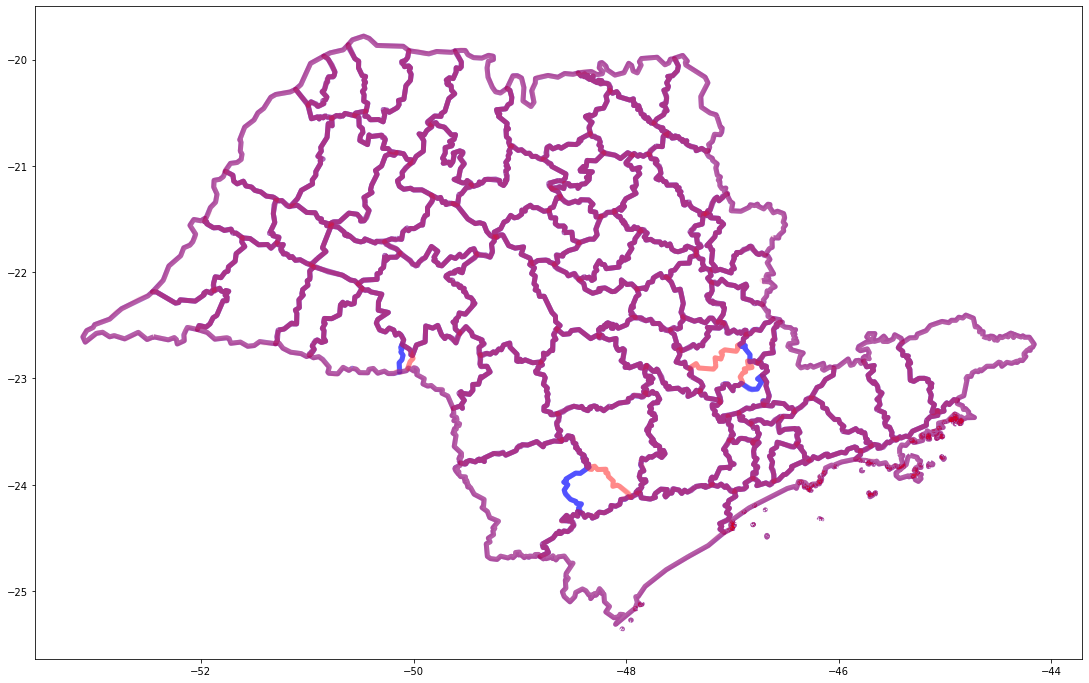

In [17]:
import matplotlib.pyplot as plt

UF = 'SP'

# plot the health regions shape
fig, ax = plt.subplots(figsize=(22, 12))

regions_shape = gpd.read_file("../data/%s/regions.shp"%UF)
regions_shape[regions_shape['year']==2019].plot(ax=ax, facecolor='none', alpha=0.5, edgecolor='b', lw=5)
regions_shape[regions_shape['year']==2017].plot(ax=ax, facecolor='none', alpha=0.3, edgecolor='r', lw=5)
gpd.GeoSeries(gpd.read_file("../data/%s/state.shp"%(UF))['geometry']).plot(ax=ax, color="w", alpha=0.1, linestyle='-', edgecolor="r", lw=5)


In [ ]:
reg_df = mun_df.merge(pd.DataFrame(R.values(), R.keys(), columns=[reg]), how = 'left', left_on = ['code'], right_index=True)[[reg, 'geometry']].dissolve(by=reg)

(-53.557548850399954,
 -43.71392784559992,
 -25.63691697714999,
 -19.5007385958499)

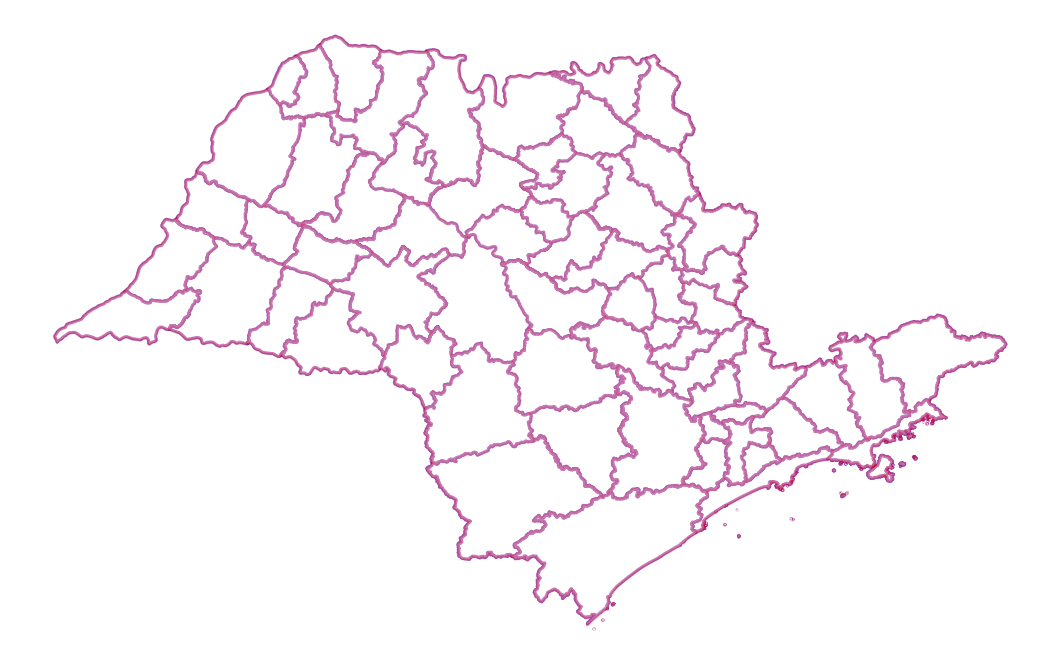

In [63]:
import matplotlib.pyplot as plt

# plot the health regions shape
fig, ax = plt.subplots(figsize=(22, 12))
# gpd.GeoSeries(mun_df['geometry']).plot(ax=ax, color="w", edgecolor="grey", lw=1)
gpd.GeoSeries(reg_df['geometry']).plot(ax=ax, color="w", alpha=0.5, linestyle='-', edgecolor="b", lw=3)
gpd.GeoSeries(reg_2017_df['geometry']).plot(ax=ax, color="w", alpha=0.25, linestyle='-', edgecolor="r", lw=3)
# gpd.GeoSeries(communities_gdf['geometry']).plot(ax=ax, color="w", alpha=0.2, linestyle='-', edgecolor="r", lw=3)
gpd.GeoSeries(gpd.read_file("../data/%s/state.shp"%(UF))['geometry']).plot(ax=ax, color="w", alpha=0.2, linestyle='-', edgecolor="r", lw=3)
ax.axis("off")

# Implementing metrics to compare network partitions

 - Using ['scikit learn' python module](https://scikit-learn.org/stable/index.html)

In [42]:
# from sklearn.metrics.cluster import adjusted_rand_score
# from sklearn.metrics.cluster import v_measure_score #, completeness_score, homogeneity_score
# # from sklearn.metrics import f1_score # F-measure

# # from sklearn.metrics import jaccard_score
# from sklearn.metrics.cluster import adjusted_mutual_info_score
# from sklearn.metrics.cluster import fowlkes_mallows_score

In [3]:
# #FOR REGIONS
# year = 2011
# if init_year >= 2011: year = init_year
# if init_year > 2017: year = 2017

# # import regions and municipalities relation
# reg_mun_df = pd.read_csv('../data/%s/regions/%s_regions_table_%d.csv'%(UF, UF, year)).sort_values(by='CD_MUN')

# # get regions and municipalities relation arrays
# R = {mun[0]:mun[1] for mun in reg_mun_df.values}

In [5]:
pd.read_csv('../data/%s/regions/macroregions_latlong_%d.csv'%(UF, 2020)).sort_values(by='CD_MUN')


CD_MUN       macroregion                                    latlong
0   330010   Metropolitana I   [-43.93088259914695, -22.50640773396086]
1   330015  Macrorregião III  [-41.74084505657541, -21.799306433880908]
2   330020  Macrorregião III  [-41.74084505657541, -21.799306433880908]
3   330022   Metropolitana I   [-43.93088259914695, -22.50640773396086]
4   330023  Macrorregião III  [-41.74084505657541, -21.799306433880908]
..     ...               ...                                        ...
87  330600   Metropolitana I   [-43.93088259914695, -22.50640773396086]
88  330610   Metropolitana I   [-43.93088259914695, -22.50640773396086]
89  330615  Macrorregião III  [-41.74084505657541, -21.799306433880908]
90  330620   Metropolitana I   [-43.93088259914695, -22.50640773396086]
91  330630   Metropolitana I   [-43.93088259914695, -22.50640773396086]

[92 rows x 3 columns]

In [44]:
# #FOR MACROREGIONS
# # import regions and municipalities relation
# year = 2020
# reg_mun_df = pd.read_csv('../data/%s/regions/macroregions_latlong_%d.csv'%(UF, 2020)).sort_values(by='CD_MUN')

# # get regions and municipalities relation arrays
# R = {mun[0]:mun[1] for mun in reg_mun_df.values}

In [45]:
# none_flow_mun = reg_mun_df[reg_mun_df['CD_MUN'].isin(flows.sort_values(by='mun_res')['mun_res'].unique())==False]['CD_MUN']
# for code in none_flow_mun:
#     R.pop(code, None)

In [46]:
# print("Escolha o método (entre 1 e 4): ")
# x = 2 #int(input())

# if x == 1:
#     index = adjusted_rand_score(list(R.values()), list(im.get_modules().values()))*100
#     index_name = 'Adjusted Rand Index'
# elif x == 2:
#     index = v_measure_score(list(R.values()), list(im.get_modules().values()))*100
#     index_name = 'V-Measure'
# elif x == 3:
#     index = adjusted_mutual_info_score(list(R.values()), list(im.get_modules().values()))*100
#     index_name = 'Adjusted Mutual Info Score'
# elif x == 4:
#     index = fowlkes_mallows_score(list(R.values()), list(im.get_modules().values()))*100
#     index_name = 'Fowlkes Mallows Score'  
# else:
#     index_name = 'Invalid option!'

# print(index_name)
# index_df = pd.read_csv("../../dashboard-regionalizacao-sus/data/comm_similarity_reg.csv", index_col='year')
# index_df.loc[init_year, diag[:-1]] = index
# print(index_df)
# index_df.to_csv("../../dashboard-regionalizacao-sus/data/comm_similarity_reg.csv")

Escolha o método (entre 1 e 4): 
V-Measure


# Comparing partitions Health Regions and Infomap detected commnities

In [175]:
from palettable.colorbrewer.qualitative import Set3_12, Set1_9, Dark2_8
import random

palette = Set3_12.hex_colors + Set1_9.hex_colors + Dark2_8.hex_colors
# random.shuffle(palette)

In [176]:
communities = len(mun_df['community'].unique())

for comm in range(len(palette)):
    if(comm < communities):
        mun_df.loc[mun_df['community']==comm+1,'color'] = palette[comm]
        mun_df.loc[mun_df['community']==comm+1,'hatch'] = " "
    
    if(communities > len(palette)): #falta completar com o caso de communities > len(palettes)
        mun_df.loc[mun_df['community']==len(palette)+comm+1,'color'] = palette[comm]
        mun_df.loc[mun_df['community']==len(palette)+comm+1,'hatch'] = "//"
    
    if(communities > 2*len(palette)): #faltcompletar com o caso de communities > 2*len(palettes)
        if(comm < 5):  
            mun_df.loc[mun_df['community']==2*len(palette)+comm+1,'color'] = palette[comm]
            mun_df.loc[mun_df['community']==2*len(palette)+comm+1,'hatch'] = "."

In [177]:
# title_initial = '\npara os dados entre %d e %d\n'%(init_year, init_year+4)
title_initial = '\npara os dados de %d\n'%(year)
plt, ax = draw_communities(im, title_initial, '', available_year, save=True)

TypeError: cannot unpack non-iterable NoneType object

In [13]:
# import matplotlib.pyplot as plt
# fig = plt.figure()
# ax = fig.add_axes([0,0,2,1])
# x = list(range(len(palette)))
# y = [10]*len(palette)
# ax.bar(x,y,color=palette,hatch="")
# x = list(range(len(palette),len(palette)*2))
# ax.bar(x,y,color=palette,hatch="//")
# x = list(range(len(palette)*2,len(palette)*2+5))
# ax.bar(x,y[:5],color=palette[:5],hatch=".")
# plt.show()

In [19]:
mun_df

CD_MUN                name SIGLA  AREA_KM2  \
0   3300100      Angra dos Reis    RJ   813.420   
1   3300159             Aperibé    RJ    94.542   
2   3300209            Araruama    RJ   638.276   
3   3300225               Areal    RJ   110.724   
4   3300233  Armação dos Búzios    RJ    70.977   
..      ...                 ...   ...       ...   
87  3306008           Três Rios    RJ   322.843   
88  3306107             Valença    RJ  1300.767   
89  3306156           Varre-Sai    RJ   201.938   
90  3306206           Vassouras    RJ   536.073   
91  3306305       Volta Redonda    RJ   182.105   

                                             geometry    code  centroid_x  \
0   MULTIPOLYGON (((-44.15109 -23.21602, -44.15076...  330010  -44.352753   
1   POLYGON ((-42.12536 -21.60155, -42.12535 -21.6...  330015  -42.134666   
2   POLYGON ((-42.18387 -22.55144, -42.18349 -22.5...  330020  -42.292909   
3   POLYGON ((-43.03716 -22.16429, -43.03672 -22.1...  330022  -43.121538   
4   MULTIPOLYGON (((-41.91855 -22.81574, -41.91836...  330023  -41.949551   
..                                                ...     ...         ...   
87  POLYGON ((-43.00221 -22.03284, -43.00235 -22.0...  330600  -43.112152   
88  POLYGON ((-43.76395 -22.06751, -43.76412 -22.0...  330610  -43.857526   
89  POLYGON ((-41.77550 -20.79987, -41.77536 -20.7...  330615  -41.829710   
90  POLYGON ((-43.46193 -22.21606, -43.46061 -22.2...  330620  -43.569730   
91  POLYGON ((-44.08659 -22.40631, -44.01314 -22.4...  330630  -44.088931   

    centroid_y  community    color hatch  
0   -22.986551          4  #984EA3        
1   -21.652292          5  #CCEBC5        
2   -22.755347          3  #666666        
3   -22.235399          9  #FCCDE5        
4   -22.776209          3  #666666        
..         ...        ...      ...   ...  
87  -22.124731          9  #FCCDE5        
88  -22.234225          4  #984EA3        
89  -20.892927          5  #CCEBC5        
90  -22.358558          8  #FFED6F        
91  -22.490923          4  #984EA3        

[92 rows x 11 columns]

In [47]:
# from matplotlib.offsetbox import AnchoredText

# # title_initial = '\npara os dados entre %d e %d\n'%(init_year, init_year+4)
# title_initial = '\npara os dados de %d\n'%(init_year)
# plt, ax = draw_communities(im, title_initial, '', year)

# at = AnchoredText(
#     "%.1f%% de semelhança entre \nas regiões de saúde e \nas comunidades*"%index, 
#     prop=dict(size=36), frameon=True, loc='lower left')
# at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
# ax.add_artist(at)
# note = AnchoredText(
#     "                           * utilizando a métrica de comparação de partições '%s'"%index_name, 
#     prop=dict(size=20), frameon=False, loc='lower left', bbox_to_anchor=(0, 0))
# ax.add_artist(note)
# # plt.savefig("/home/gabriely/Mestrado/visualizing-health-regionalization-brazil/community/images/%s/%d.png"%(index_name, init_year), bbox_inches='tight')

----------------

In [48]:
infomap_result = pd.DataFrame(im.modules, columns=['mun_code', 'community'])

In [49]:
mun_df = mun_df.merge(infomap_result, how = 'left', left_on = ['code'], right_on = ['mun_code'])

In [50]:
# from shapely.ops import cascaded_union
# from shapely.geometry import Polygon, MultiPolygon
# communities_boundary = []

# for community in mun_df[mun_df['community'].notna()]['community'].unique():
#     mun_polygons = mun_df[mun_df['community']==community]['geometry'].values
#     community_polygon = cascaded_union(mun_polygons)
    
    
#     if community_polygon.type == 'MultiPolygon':
#         community_polygon = list(community_polygon)
#         multipoly = []
#         for _ in range(2):
#             maxx = max(community_polygon, key=lambda a: a.area)
#             poly = Polygon(maxx.exterior)
#             multipoly.append(poly)
#             community_polygon.remove(maxx)
#         communities_boundary.append(MultiPolygon(multipoly))
#     else:
#         poly = Polygon(community_polygon.exterior)
#         communities_boundary.append(poly)


Text(0.5, 1.0, 'Detected communities in the State of RJ (9 regions)')

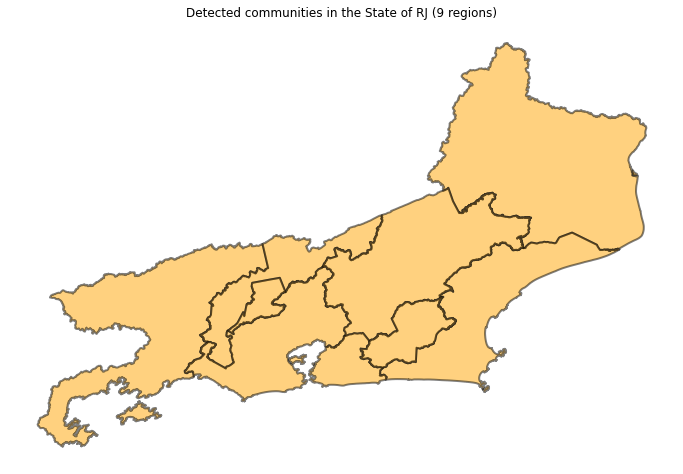

In [51]:
# import matplotlib.pyplot as plt

# # plot the health regions shape
# fig, ax = plt.subplots(figsize=(12, 10))
# #gpd.GeoSeries(mun_df['geometry']).plot(ax=ax, color="orange", edgecolor="darkcyan", lw=1)
# gpd.GeoSeries(communities_boundary).plot(ax=ax, color="orange", alpha=0.5, edgecolor="k", lw=2)
# ax.axis("off")
# plt.title("Detected communities in the State of %s (%d regions)"%(UF, len(communities_boundary)))

In [53]:
# macro = ''
# # macro = 'macro_'

# # saving communities shape to file

# gdf = gpd.GeoDataFrame({
#     'community': mun_df[mun_df['community'].notna()]['community'].unique(),
#     'geometry': communities_boundary
# })

# gdf['geometry'] = gdf['geometry'].simplify(tolerance=0.01)
# # gdf.to_file("../data/%s/communities/%scomm_%d.shp"%(UF, macro, init_year))
# # gdf.to_file("../../dashboard-regionalizacao-sus/data/shapes/communities/%scomm_%d.shp"%(macro, init_year))
# # For diagnosis
# gdf.to_file("../data/%s/communities/diagnosis/%scomm_%d.shp"%(UF, macro, init_year))
# gdf.to_file("../../dashboard-regionalizacao-sus/data/shapes/communities/diagnosis/%s%scomm_%d.shp"%(diag, macro, init_year))

-----------

In [ ]:
# import pandas as pd

# data = {'init year': list(range(2000, 2016)),
#         'Adjusted Rand Index':  [0]*16,
#         'V-Measure': [0]*16,
#         'Adjusted Mutual Info Score': [0]*16,
#         'Fowlkes Mallows Score': [0]*16
#         }

# df = pd.DataFrame(data)

In [ ]:
# df.loc[init_year-2000, index_name] = index

In [ ]:
# df.to_csv(index=False)

In [351]:
# from bokeh.plotting import figure, show, output_notebook
# # from bokeh.models import HoverTool
# UF = 'CE'
# df = pd.read_csv('comparing_%s.csv'%UF)

# # prepare some data
# x = df['init year'].to_list()
# y1 = df['Adjusted Rand Index'].to_list()
# y2 = df['V-Measure'].to_list()
# y3 = df['Adjusted Mutual Info Score'].to_list()
# y4 = df['Fowlkes Mallows Score'].to_list()

# # create a new plot with a title and axis labels
# p = figure(title="Algoritmos de comparação de partições - %s"%uf_name, x_axis_label="Ano de início", 
#            y_axis_label="Nível de semelhança (%)", y_range=(0, 100))
# # p.add_tools(HoverTool())

# # add multiple renderers
# # p.scatter(x, y1, marker="square", fill_color="blue")
# p.line(x, y2, legend_label="V-Measure", line_color="red", line_width=2)
# p.line(x, y3, legend_label="Adjusted Mutual Info Score", line_color="green", line_width=2)
# p.line(x, y4, legend_label="Fowlkes Mallows Score", line_color="yellow", line_width=2)
# p.line(x, y1, legend_label="Adjusted Rand Index", line_color="blue", line_width=2)

# # show the results
# output_notebook(hide_banner=True)
# show(p)

In [352]:
# from bokeh.plotting import figure, show, output_notebook
# import pandas as pd
# # from bokeh.models import HoverTool
# UF = 'CE'
# df = pd.read_csv('comparing_%s_single_year.csv'%UF)

# # prepare some data
# x = df['year'].to_list()
# y1 = df['Adjusted Rand Index'].to_list()
# y2 = df['V-Measure'].to_list()
# y3 = df['Adjusted Mutual Info Score'].to_list()
# y4 = df['Fowlkes Mallows Score'].to_list()

# # create a new plot with a title and axis labels
# p = figure(title="Algoritmos de comparação de partições - %s"%uf_name, 
#            x_axis_label="Ano", y_axis_label="Nível de semelhança (%)", y_range=(0, 100))
# # p.add_tools(HoverTool())

# # add multiple renderers
# # p.scatter(x, y1, marker="square", fill_color="blue")
# p.line(x, y2, legend_label="V-Measure", line_color="red", line_width=2)
# p.line(x, y3, legend_label="Adjusted Mutual Info Score", line_color="green", line_width=2)
# p.line(x, y4, legend_label="Fowlkes Mallows Score", line_color="yellow", line_width=2)
# p.line(x, y1, legend_label="Adjusted Rand Index", line_color="blue", line_width=2)
# p.legend.location = "bottom_right"

# # show the results
# output_notebook(hide_banner=True)
# show(p)